# Proyecto: Análisis de Mercado Inmobiliario II

Analizaremos nuevamente la base de datos de <i>Properati</i>, sólo que ahora empleando herramientas más avanzadas. Con esto, se pretende encontrar un mejor modelo que el que entonces se seleccionó para predecir el precio de los tres tipos de propiedad ahí estudiados. Para ello, seguiremos trabajando con las mismas condiciones en las que se desarrolló tal modelo en el análisis previo; a saber, el objeto de este análisis serán únicamente las tres propiedades de interés en Capital Federal.

## Parte A - Transformación de datos.

Comenzaremos descargando las librerías que utilizaremos a lo largo de este análisis.

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec

import matplotlib as pyplot

import seaborn as sns

import xgboost as xgb

import graphviz as graphviz

import missingno as msno

from scipy.stats import iqr

from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor
from xgboost import plot_importance
from xgboost import plot_tree

from graphviz import Digraph
from graphviz import Graph

Ahora, vamos a descargar nuestro <i>dataset</i> original.

In [2]:
df = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

A continuación, filtraremos el <i>dataset</i> de acuerdo a las condiciones que requerimos, tanto de zona como de tipo de propiedad.

In [3]:
properties = ['Departamento', 'Casa', 'PH']
zone = ['Capital Federal']

df1 = df.loc[(df['l2'].isin(zone)) & (df['property_type'].isin(properties))]

Hay columnas que para efectos de nuestro análisis no son útiles por lo que, a fin de simplificar nuestros datos, las eliminaremos.

In [4]:
df2 = df1.drop(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'currency',
                'title', 'description', 'operation_type'], axis = 1)

Para tener una idea más clara del <i>dataset</i> con el que trabajaremos, veamos cómo son los primeros cinco renglones de este así como su tamaño.

In [5]:
df2.head()

l3  rooms  bedrooms  bathrooms  surface_total  surface_covered  \
0  San Cristobal    7.0       7.0        2.0          140.0            140.0   
1          Boedo    2.0       1.0        2.0           70.0             58.0   
2        Palermo    2.0       1.0        1.0           45.0             45.0   
3        Palermo    2.0       1.0        1.0           85.0             50.0   
5   Villa Crespo    2.0       1.0        1.0           56.0             56.0   

      price property_type  
0  153000.0  Departamento  
1  159000.0            PH  
2  125000.0            PH  
3  295000.0            PH  
5  150000.0            PH

In [6]:
df2.shape

(91485, 8)

### a) Outliers

Con ayuda de <i>boxplots</i>, veamos si tenemos <i>outliers</i> en nuestro <i>dataset</i> respecto a los tipos de propiedad.

Text(0, 0.5, 'Rooms')

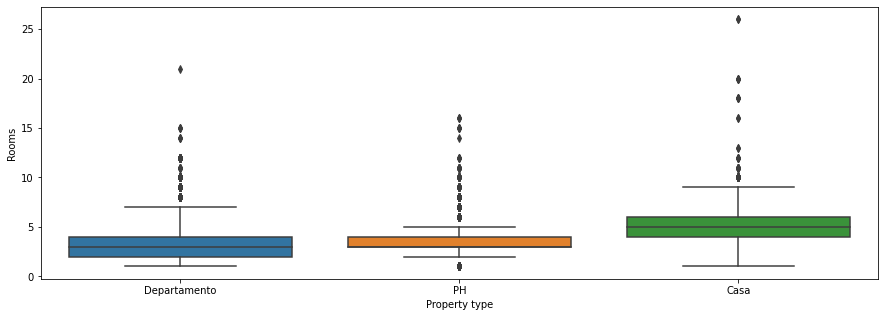

In [7]:
plt.figure(figsize = (15, 5))
ax = sns.boxplot(x = 'property_type', y = 'rooms', data = df2)
plt.xlabel('Property type')
plt.ylabel('Rooms')

Text(0, 0.5, 'Bedrooms')

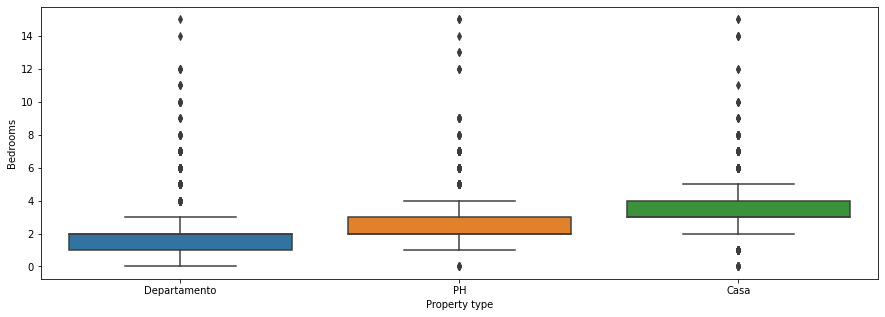

In [8]:
plt.figure(figsize = (15, 5))
ax = sns.boxplot(x = 'property_type', y = 'bedrooms', data = df2)
plt.xlabel('Property type')
plt.ylabel('Bedrooms')

Text(0, 0.5, 'Bathrooms')

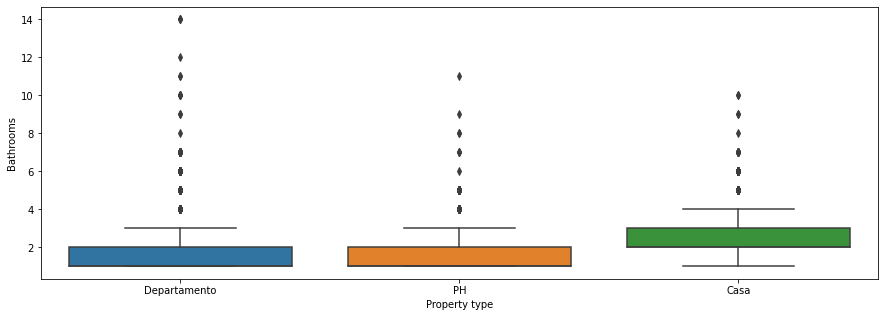

In [9]:
plt.figure(figsize = (15, 5))
ax = sns.boxplot(x = 'property_type', y = 'bathrooms', data = df2)
plt.xlabel('Property type')
plt.ylabel('Bathrooms')

Text(0, 0.5, 'Total surface')

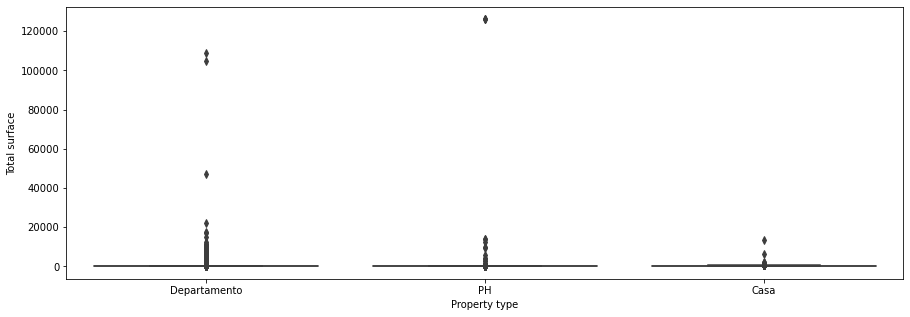

In [10]:
plt.figure(figsize = (15, 5))
ax = sns.boxplot(x = 'property_type', y = 'surface_total', data = df2)
plt.xlabel('Property type')
plt.ylabel('Total surface')

Text(0, 0.5, 'Covered surface')

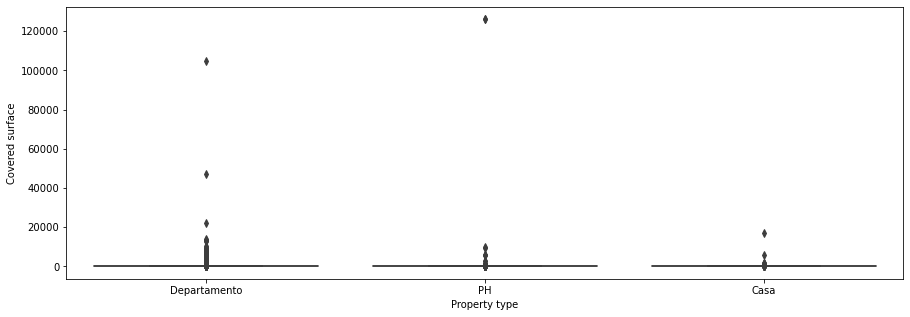

In [11]:
plt.figure(figsize = (15, 5))
ax = sns.boxplot(x = 'property_type', y = 'surface_covered', data = df2)
plt.xlabel('Property type')
plt.ylabel('Covered surface')

Text(0, 0.5, 'Price (USD)')

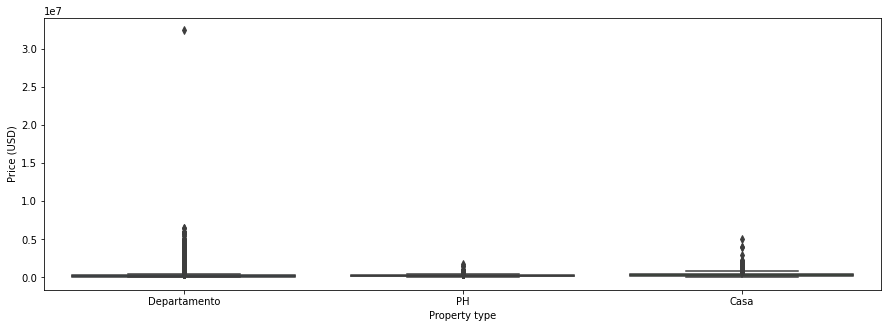

In [12]:
plt.figure(figsize = (15, 5))
ax = sns.boxplot(x = 'property_type', y = 'price', data = df2)
plt.xlabel('Property type')
plt.ylabel('Price (USD)')

De los anteriores <i>boxplots</i> se desprende la existencia de <i>outliers</i> en nuestro <i>dataset</i>. Usemos el <b>IQR</b> para el tratamiento de estos y veamos en cada caso cómo va cambiando el <i>boxplot</i> respectivo.

In [13]:
q1, q3 = np.nanpercentile(df2['rooms'], 25), np.nanpercentile(df2['rooms'], 75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

df_filtered = df2[~((df2['rooms'] < lower_limit) | (df2['rooms'] > upper_limit))]

print(iqr)

2.0


Text(0, 0.5, 'Rooms')

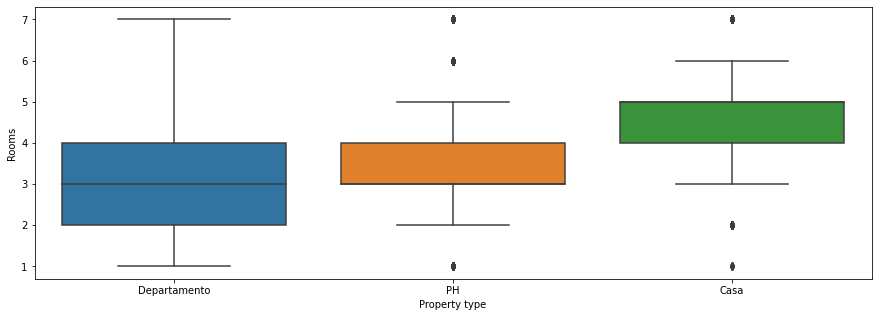

In [14]:
plt.figure(figsize = (15, 5))
ax = sns.boxplot(x = 'property_type', y = 'rooms', data = df_filtered)
plt.xlabel('Property type')
plt.ylabel('Rooms')

In [15]:
q1, q3 = np.nanpercentile(df2['bedrooms'], 25), np.nanpercentile(df2['bedrooms'], 75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

df_filtered = df_filtered[~((df_filtered['bedrooms'] < lower_limit) | (df_filtered['bedrooms'] > upper_limit))]

print(iqr)

2.0


Text(0, 0.5, 'Bedrooms')

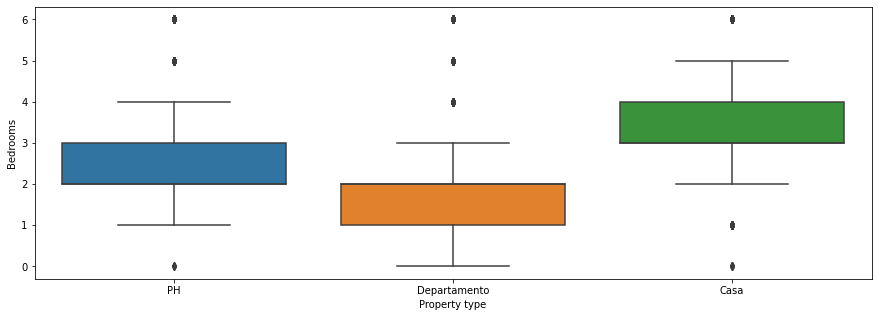

In [16]:
plt.figure(figsize = (15, 5))
ax = sns.boxplot(x = 'property_type', y = 'bedrooms', data = df_filtered)
plt.xlabel('Property type')
plt.ylabel('Bedrooms')

In [17]:
q1, q3 = np.nanpercentile(df2['bathrooms'], 25), np.nanpercentile(df2['bathrooms'], 75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

df_filtered = df_filtered[~((df_filtered['bathrooms'] < lower_limit) | (df_filtered['bathrooms'] > upper_limit))]

print(iqr)

1.0


Text(0, 0.5, 'Bathrooms')

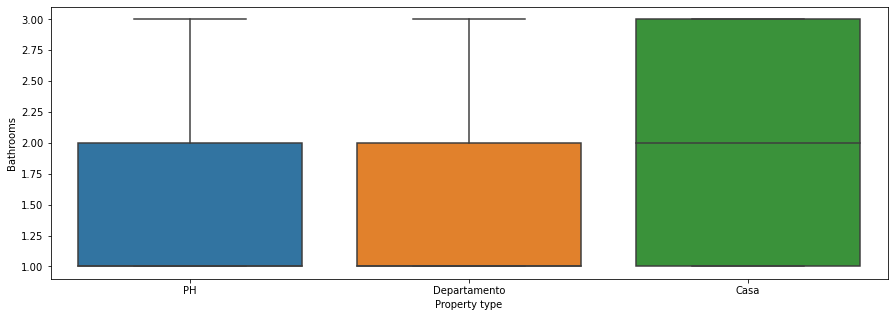

In [18]:
plt.figure(figsize = (15, 5))
ax = sns.boxplot(x = 'property_type', y = 'bathrooms', data = df_filtered)
plt.xlabel('Property type')
plt.ylabel('Bathrooms')

In [19]:
q1, q3 = np.nanpercentile(df2['surface_total'], 25), np.nanpercentile(df2['surface_total'], 75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

df_filtered = df_filtered[~((df_filtered['surface_total'] < lower_limit) |
                            (df_filtered['surface_total'] > upper_limit))]

print(iqr)

62.0


Text(0, 0.5, 'Total surface')

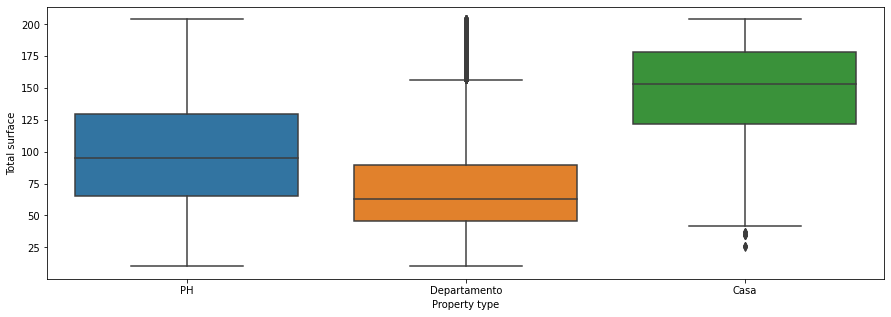

In [20]:
plt.figure(figsize = (15, 5))
ax = sns.boxplot(x = 'property_type', y = 'surface_total', data = df_filtered)
plt.xlabel('Property type')
plt.ylabel('Total surface')

In [21]:
q1, q3 = np.nanpercentile(df2['surface_covered'], 25), np.nanpercentile(df2['surface_covered'], 75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

df_filtered = df_filtered[~((df_filtered['surface_covered'] < lower_limit) |
                            (df_filtered['surface_covered'] > upper_limit))]

print(iqr)

52.0


Text(0, 0.5, 'Covered surface')

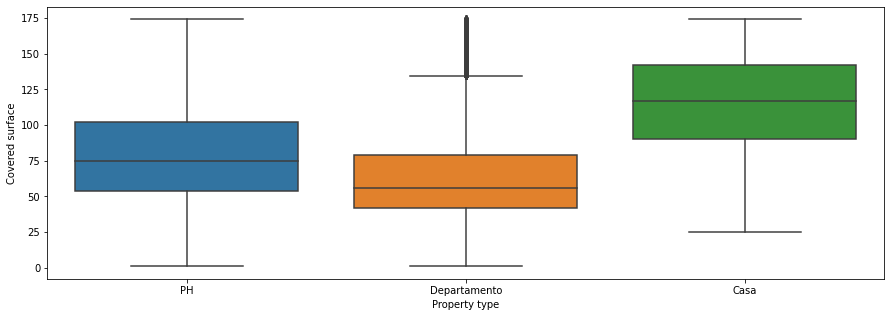

In [22]:
plt.figure(figsize = (15, 5))
ax = sns.boxplot(x = 'property_type', y = 'surface_covered', data = df_filtered)
plt.xlabel('Property type')
plt.ylabel('Covered surface')

In [23]:
q1, q3 = np.nanpercentile(df2['price'], 25), np.nanpercentile(df2['price'], 75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

df_filtered = df_filtered[~((df_filtered['price'] < lower_limit) | (df_filtered['price'] > upper_limit))]

print(iqr)

159000.0


Text(0, 0.5, 'Price (USD)')

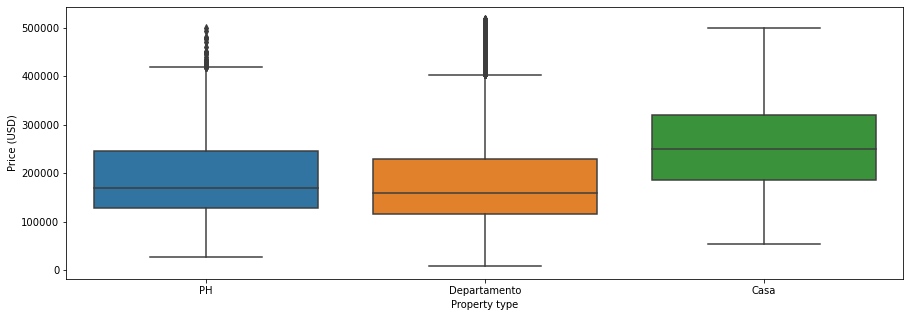

In [24]:
plt.figure(figsize = (15, 5))
ax = sns.boxplot(x = 'property_type', y = 'price', data = df_filtered)
plt.xlabel('Property type')
plt.ylabel('Price (USD)')

Ahora, veamos cómo cambió el tamaño de nuestro <i>dataset</i> removiendo los <i>outliers</i> mediante el método del <b>IQR</b>.

In [25]:
df_filtered.shape

(79937, 8)

Verifiquemos si los valores faltantes que teníamos continúan presentes después de este primer tratamiento a nuestro <i>dataset</i>.

In [26]:
df_filtered.isna().sum()

l3                    0
rooms                 0
bedrooms              0
bathrooms          2028
surface_total      8280
surface_covered    8571
price                 0
property_type         0
dtype: int64

### b) Valores faltantes

Hagamos un gráfico con nuestras variables y sus valores faltantes para ver si hay alguna correlación entre ellos.

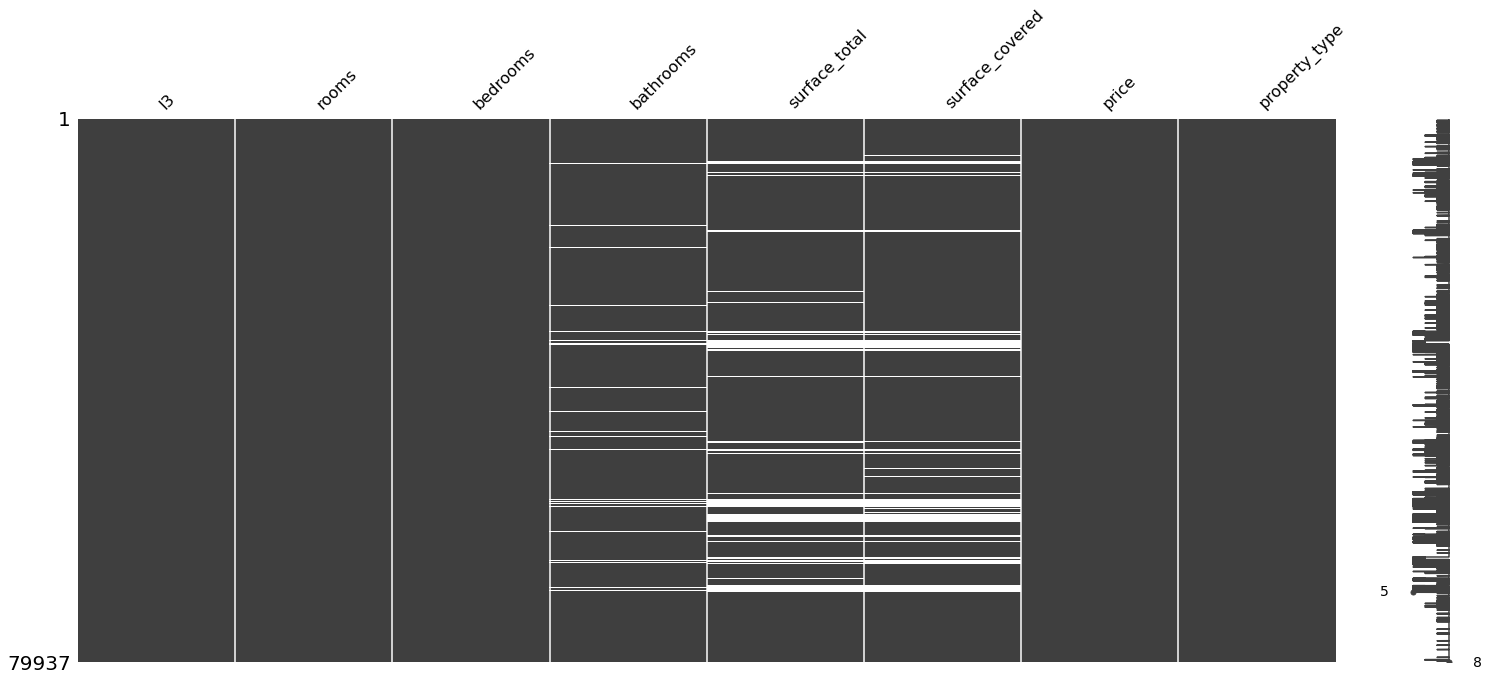

In [27]:
msno.matrix(df_filtered)

En el gráfico anterior se aprecia que los valores faltantes de la variable <i><b>bathrooms</b></i> son <b>MCAR <i>(Missing Completely At Random)</i></b> mientras que los valores faltantes de las variables <i><b>surface_total</b></i> y <i><b>surface_covered</b></i> son <b>MAR <i>(Missing At Random)</i></b>.

Ahora, con ayuda de un <i>pariplot</i> veamos cómo están distribuidos los valores de la varialbe <i><b>bathrooms</b></i> sobre el resto.

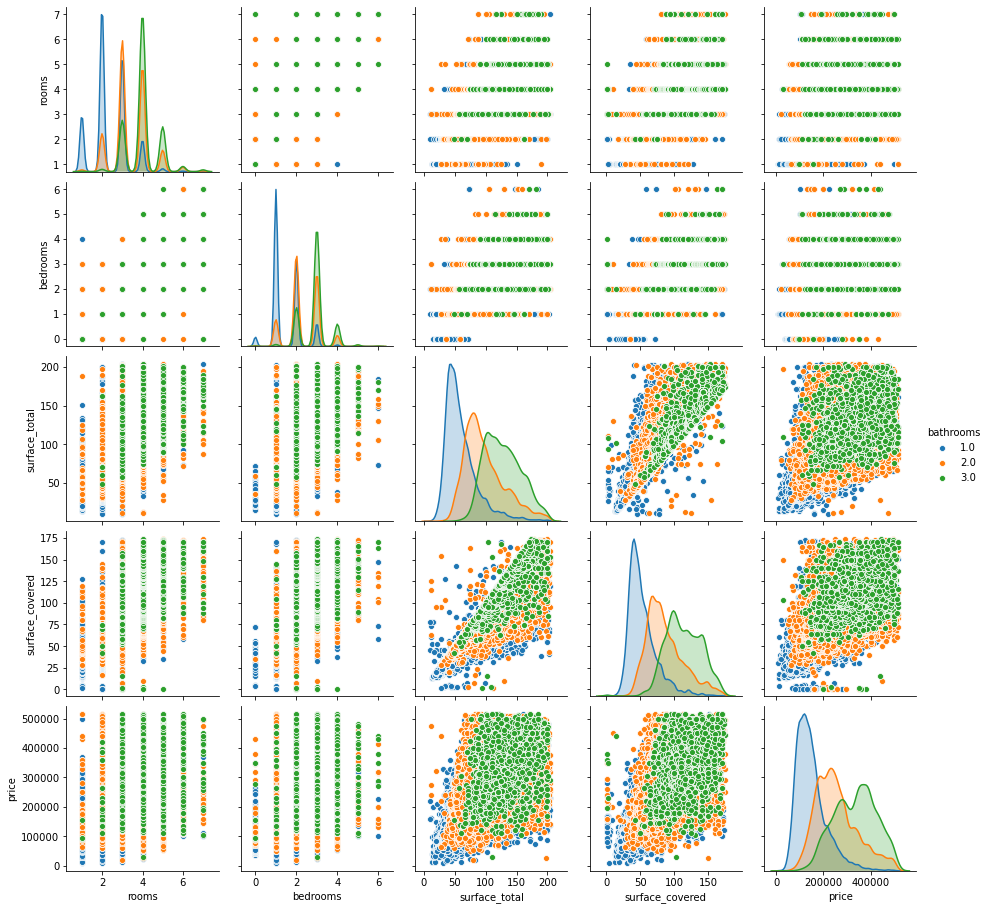

In [28]:
sns.pairplot(df_filtered, hue = 'bathrooms')

Del <i>pairplot</i> se desprende que las variables <i><b>surface_total</b></i>, <b><i>surface_covered</i></b> y <i><b>price</b></i> segmentan bien a la variable <i><b>bathrooms</b></i>.

De todo lo anterior se concluye que para imputar los valores faltantes hacer uso de <b>KNNImputer</b> de <i>Scikit-Learn</i> es lo más adecuado. Pero antes, para encontrar el valor óptimo para el hiperparámetro `n_neighbors`, vía <b>GridSearchCV</b> correremos varios modelos de vecinos más cercanos para encontrar el mejor. Luego, haremos `n_neighbors` igual al número de vecinos que <b>GridSeachCV</b> nos arroje.

Para aplicar lo anterior, crearemos un nuevo <i>dataset</i> sin valores faltantes.

In [29]:
df_filtered_copy = df_filtered.copy()
df_filtered_copy.dropna(inplace = True)

A continuación, seleccionamos las variables independientes y la variable objetivo.

In [30]:
X = df_filtered_copy.drop(['l3', 'surface_covered', 'rooms', 'bedrooms', 'property_type',
                           'price'], axis = 1)
y = df_filtered_copy['surface_covered']

**Obs:** Si bien <i><b>price</b></i> tiene una alta correlación con nuestras variables de interés, al ser esta nuestra variable objetivo debemos de excluirla como argumento de nuestros modelos.

Dividimos los datos en <i>train</i> y <i>test</i>. Se considera que el número de datos con el que contamos nos permite utilizar sólo un 90% de estos para entrenamientoy el 10% restante para prueba.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)

**Obs:** dado que las variables continuas que utilizaremos están en la misma escala, no hay necesidad de normalizarlas. <b>Para el resto de este Proyecto este será nuestro criterio</b>, cuando aplique.

Definamos al modelo con el que trabajeremos.

In [32]:
knn = KNeighborsRegressor()

Ahora, definimos la grilla con la variable que queremos optimizar.

In [33]:
param_grid = {'n_neighbors': np.arange(1, 6)}

Podemos ahora definir el <b>GridSearchCV</b> que utilizaremos.

In [34]:
knn_grid = GridSearchCV(knn, param_grid = param_grid, cv = 5)

Entrenamos al <b>GridSearchCV</b> con la grilla definida arriba y `cv` con tamaño 5.

In [35]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5])})

Imprmimos nuestro mejor parámetro, de acuerdo a `knn_grid`, así como el mejor <i>score</i>.

In [36]:
print('Best parameteres: ' + str(knn_grid.best_params_))
print('Best score: ' + str(knn_grid.best_score_))

Best parameteres: {'n_neighbors': 5}
Best score: 0.8542938062931615


Ahora, imputemos los valores faltantes usando como hiperparámetro a `best_params_[n_neighbors]`.

In [37]:
X = df_filtered[['bathrooms', 'surface_total', 'surface_covered']]
imputer = KNNImputer(n_neighbors = knn_grid.best_params_['n_neighbors'])
df_filled = imputer.fit_transform(X)

Ahora, hagamos a `df_filled` un <i>DataFrame</i>.

In [38]:
df_filled = pd.DataFrame(df_filled, columns = ['bathrooms', 'surface_total', 'surface_covered'])

Corroboremos que, efectivamente, los datos faltantes en estas variables han sido imputados.

In [39]:
df_filled.isna().sum()

bathrooms          0
surface_total      0
surface_covered    0
dtype: int64

Ahora, debemos de tener el <i>dataset</i> con el que vamos a trabajar ya con los valores faltantes imputados. Para ello, en una copia de nuestro <i>dataset</i> original eliminaremos las variables con valores faltantes y <b><i>price</i></b> y agregaremos las columnas del <i>DataFrame</i> `df_filled`. Además, como los valores de la variable <b><i>bathrooms</i></b> en `df_filled` posiblemente no son enteros, los redondearemos para que en esta variable no tengamos valores sin sentido.

In [40]:
df_complete = df_filtered.copy()
df_complete = df_complete.reset_index(drop = True)
df_complete.drop(['bathrooms', 'surface_total', 'surface_covered'], axis = 1, inplace = True)
df_complete['bathrooms'] = df_filled['bathrooms']
df_complete['bathrooms'] = round(df_complete['bathrooms'], 0)
df_complete['surface_total'] = df_filled['surface_total']
df_complete['surface_covered'] = df_filled['surface_covered']

Veamos ahora cómo quedan nuestros primeros registros en nuestro nuevo <i>DataFrame</i> y el tamaño que tiene.

In [41]:
df_complete.head()

l3  rooms  bedrooms     price property_type  bathrooms  \
0         Boedo    2.0       1.0  159000.0            PH        2.0   
1       Palermo    2.0       1.0  125000.0            PH        1.0   
2       Palermo    2.0       1.0  295000.0            PH        1.0   
3  Villa Crespo    2.0       1.0  150000.0            PH        1.0   
4  Villa Crespo    2.0       1.0  159500.0            PH        1.0   

   surface_total  surface_covered  
0           70.0             58.0  
1           45.0             45.0  
2           85.0             50.0  
3           56.0             56.0  
4           70.0             70.0

In [42]:
df_complete.shape

(79937, 8)

Volvamos a verificar que ya no tenemos valores faltantes.

In [43]:
df_complete.isna().sum()

l3                 0
rooms              0
bedrooms           0
price              0
property_type      0
bathrooms          0
surface_total      0
surface_covered    0
dtype: int64

### c) Validación de datos

Viendo cómo son las variables de nuestro <i>dataset</i> se evidencia que una condición que se debe de cumplir es que <i><b>surface_covered</b></i> sea menor o igual a <i><b>surface_total</b></i>. Veamos si esto ocurre, obteniendo el número de registros que no satisfacen esta condición.

In [44]:
df_check = df_complete[df_complete.surface_total < df_complete.surface_covered]
df_check.shape

(670, 8)

Veamos ahora qué porcentaje de nuestros datos presentan esta inconsistencia.

In [45]:
print((len(df_check) * 100) / len(df_complete))

0.8381600510401942


Considerando que estos registros representan aproximadamente sólo el 0,84% de nuestro <i>dataset</i> y que no es posible corregirlos de manera fehaciente, los eliminaremos a fin de trabajar únicamente con datos consistentes.

Hagámoslo pues y veamos ahora de qué tamaño queda nuestro <i>DataFrame</i>.

In [46]:
df_complete = df_complete.loc[df_complete['surface_covered'] <= df_complete['surface_total']]
df_complete.shape

(79267, 8)

### d) Comparación de <i>performance</i> respecto al Proyecto 1

Ahora, con este nuevo <i>dataset</i> ya depurado veamos cómo se comporta el modelo seleccionado en el Proyecto 1.

El modelo seleccionado fue un `DecisionTree de profundidad 3`, tomando como potenciales variables independientes aquellas numéricas y finalmente seleccionando las dos más correlacionadas con nuestra variable objetivo, <i><b>price</b></i>, y se decidió utilizar el <b>MAE</b> como métrica.

Veamos en nuestro nuevo <i>DataFrame</i>, `df_complete`, cómo están correlacionadas nuestras variables.

In [47]:
df_complete.corr()

rooms  bedrooms     price  bathrooms  surface_total  \
rooms            1.000000  0.939627  0.594291   0.520840       0.697044   
bedrooms         0.939627  1.000000  0.575474   0.520091       0.667837   
price            0.594291  0.575474  1.000000   0.616143       0.691994   
bathrooms        0.520840  0.520091  0.616143   1.000000       0.582164   
surface_total    0.697044  0.667837  0.691994   0.582164       1.000000   
surface_covered  0.762686  0.740042  0.730350   0.627162       0.911373   

                 surface_covered  
rooms                   0.762686  
bedrooms                0.740042  
price                   0.730350  
bathrooms               0.627162  
surface_total           0.911373  
surface_covered         1.000000

En el <i>dataset</i> del Proyecto 1, las dos variables más correlacionadas con <i><b>precio</b></i> fueron <i><b>surface_total</b></i> y <i><b>bathrooms</b></i>; ahora esta última cambia por <i><b>surface_covered</b></i>.

Seleccionemos las variables independientes y la variable objetivo.

In [48]:
X = df_complete.drop(['l3', 'property_type', 'price', 'rooms', 'bedrooms', 'bathrooms'],
                     axis = 1)
y = df_complete['price']

Luego, dividamos los datos para entrenamiento y para evaluación.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)

Determinemos la profundidad adecuada de nuestro árbol de decisión. Para ello, hagamos primero una prueba con varias posibles profundidades viendo cuál es el <b>MAE</b> de cada una de ellas.

In [50]:
mae_t_train = []
mae_t_test = []

depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for d in depth:
    tree_regressor = DecisionTreeRegressor(max_depth = d)
    tree_regressor.fit(X_train, y_train)
    
    y_train_pred = tree_regressor.predict(X_train)
    y_test_pred = tree_regressor.predict(X_test)
    
    tree_mae_train = mean_absolute_error(y_train, y_train_pred)
    tree_mae_test = mean_absolute_error(y_test, y_test_pred)
    
    mae_t_train.append(tree_mae_train)
    mae_t_test.append(tree_mae_test)
    
print('The MAE for trainning in each depth is:\n')
print(mae_t_train)
print('The MAE for test in each depth is:\n')
print(mae_t_test)

The MAE for trainning in each depth is:

[53966.76503583491, 47331.87708645427, 45081.61177427917, 44054.47202745064, 43317.02445573021, 42460.29599597278, 41850.4533319531, 41229.090563825885, 40424.07272439131, 39687.599407089576, 38950.805715547285, 38169.29370306573, 37344.16089481508, 36621.90639256517, 35887.37522794117]
The MAE for test in each depth is:

[53544.37844965171, 47129.369247575196, 45020.17886959417, 43936.37681801095, 43123.15763226483, 42177.37433989807, 41584.02074935455, 41237.148135448006, 40674.97930981042, 40361.19254481648, 39727.284631241266, 39011.95875335013, 38778.45881198247, 38489.28415898468, 38229.72727519857]


Veamos ahora cómo es el histograma de los errores ($y - y_{predicho}$) así como el gráfico de dispersión de $y$ contra $y_{predicho}$ para el conjunto de <i>test</i>.

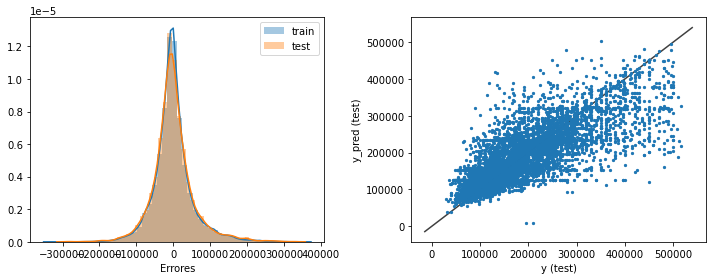

In [51]:
plt.figure(figsize = (10, 4))

plt.subplot(1, 2, 1)
sns.distplot(y_train - y_train_pred, bins = 50, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 50, label = 'test')
plt.xlabel('Errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s = 5)
    
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])
       ]
    
ax.plot(lims, lims, 'k-', alpha = 0.75, zorder = 0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()

Veamos en una gráfica cómo son las curvas del <b>MAE</b> de entrenamiento y de evaluación.

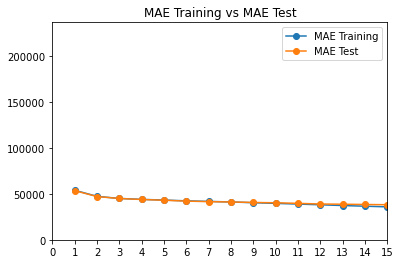

In [52]:
%matplotlib inline
plt.plot(range(1, 16, 1), mae_t_train, 'o-', label = 'MAE Training')
plt.plot(range(1, 16, 1), mae_t_test, 'o-', label = 'MAE Test')
plt.xticks(range(0,max(depth) + 1, 1))
plt.xlim((0, max(depth)))
plt.ylim((0, 237000))
plt.legend(loc = 'best')
plt.title('MAE Training vs MAE Test')
plt.show()

Se considera que la mejor profundidad para el árbol de decisión es 2.

Veamos cuál es el error en la evaluación.

In [53]:
mae_t_test[1]

47129.369247575196

Veamos los resultados del mejor modelo del Proyecto anterior.

Estos fueron los gráficos del histograma de errores y del de dispersión de `y` contra `y_pred`.

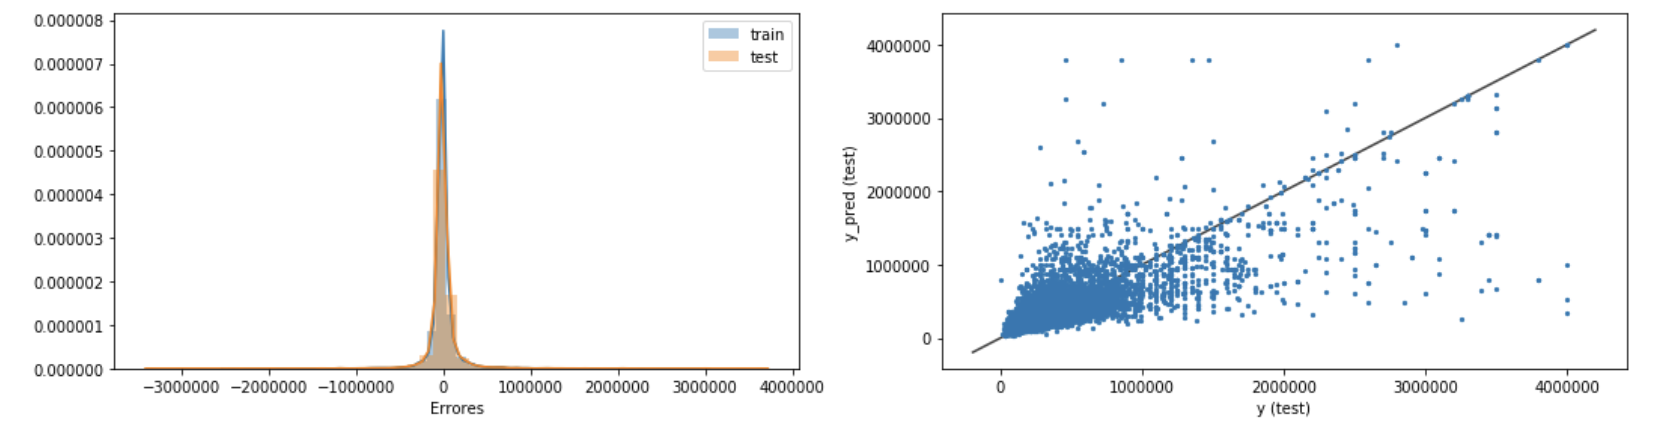

Y este el gráfico de la métrica en el entrenamiento contra la métrica en la evaluación así como el <b>MAE</b> en la evaluación.

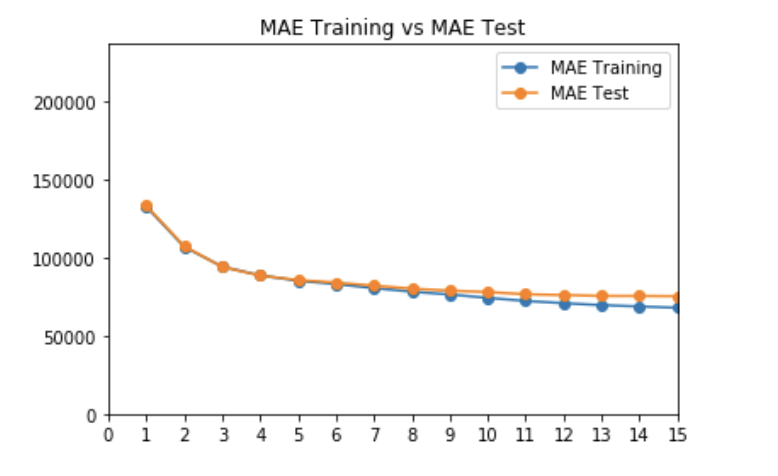

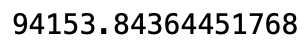

### - Conclusiones

El <i>performance</i> del modelo mejoró fuertemente respecto al del proyecto anterior. Evidentemente, el trabajo de preprocesamiento del <i>dataset</i> que ahora se hizo, específicamente el tratamiento de los <i>outliers</i> y la imputación de valores faltantes, tuvo muchísimo impacto lo cual también se evidencia tanto en el diagrama de dispersión como en el histograma de errores.

## Parte B - Modelos avanzados.

Para esta parte, desarrollaremos un modelo de `Regresión Lineal con atributos polinomiales` y uno de `XGboost` (`Tree Booster`), ambos con `cross_validation`. En ambos casos, comenzaremos con sus valores por defecto, veremos cómo se comportan y, posteriormente, intentaremos optimizarlos mediante la elección de hiperparámetros adecuados con ayuda de `GridSearchCV` y `RandomizedSearcCV` y, para la Regresión Lineal, regularizaciones `Ridge` y `Lasso`. Finalmente, compararemos el <i>performance</i> de todos ellos y seleccionaremos el mejor modelo.

Como modelo <i>Benchmark</i> tomaremos el modelo recién evaluado (`Decision Tree con profundidad igual a 2`).

Antes, para poder utilizar las variables <b><i>l3</i></b> y <b><i>property_type</i></b>, si así lo queremos, haremos un <b>One-Hot Encoding</b> sobre ellas y veremos cómo quedan los primeros cinco renglones de nuestro nuevo <i>DataFrame</i>.

In [54]:
df_extended = pd.get_dummies(data = df_complete, columns = ['l3', 'property_type'],
                             prefix = ['Neighborhood', 'Property type'],
                             prefix_sep = ' ')
df_extended.head()

rooms  bedrooms     price  bathrooms  surface_total  surface_covered  \
0    2.0       1.0  159000.0        2.0           70.0             58.0   
1    2.0       1.0  125000.0        1.0           45.0             45.0   
2    2.0       1.0  295000.0        1.0           85.0             50.0   
3    2.0       1.0  150000.0        1.0           56.0             56.0   
4    2.0       1.0  159500.0        1.0           70.0             70.0   

   Neighborhood Abasto  Neighborhood Agronomía  Neighborhood Almagro  \
0                    0                       0                     0   
1                    0                       0                     0   
2                    0                       0                     0   
3                    0                       0                     0   
4                    0                       0                     0   

   Neighborhood Balvanera  ...  Neighborhood Villa Pueyrredón  \
0                       0  ...                              0   
1                       0  ...                              0   
2                       0  ...                              0   
3                       0  ...                              0   
4                       0  ...                              0   

   Neighborhood Villa Real  Neighborhood Villa Riachuelo  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0                             0   

   Neighborhood Villa Santa Rita  Neighborhood Villa Soldati  \
0                              0                           0   
1                              0                           0   
2                              0                           0   
3                              0                           0   
4                              0                           0   

   Neighborhood Villa Urquiza  Neighborhood Villa del Parque  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   Property type Casa  Property type Departamento  Property type PH  
0                   0                           0                 1  
1                   0                           0                 1  
2                   0                           0                 1  
3                   0                           0                 1  
4                   0                           0                 1  

[5 rows x 66 columns]

### a) Regresión Lineal

Seleccionamos a nuestras variables independientes y a nuestra variable objetivo.

In [55]:
X = df_extended.drop('price', axis = 1)
y = df_extended['price']

Dividimos nuestros datos en aquellos de prueba, tomando el 10% del total, y aquellos de entrenamiento, que constarán del 90% restante.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)

A continuación, incorporaremos atributos polinomiales mediante <b>PolynomialFeatures</b>, con sus valores por defecto.

Para lo anterior, no incluimos aquellas variables con valores binarios pues las potencias de sus valores siguen siendo ellos mismos, para cualquier <i>n</i>, y únicamente complejizarían el modelo innecesariamente.

In [57]:
columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
reg_poly = make_column_transformer((PolynomialFeatures(include_bias = False), columns),
                                    remainder = 'passthrough')
X_train_p = reg_poly.fit_transform(X_train)
X_test_p = reg_poly.fit_transform(X_test)

Ahora, entrenaremos una Regresión Lineal con estos atributos polinomiales e imprimiremos sus coeficientes y la ordenada al origen.

In [58]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_p, y_train)

coef_lin_reg = list(lin_reg.coef_.flatten())
print('Coefficients:', coef_lin_reg, '\n')
print(f'Intercept: {lin_reg.intercept_}')

Coefficients: [13586.61162171493, 29750.844817154917, 44693.24202067218, 983.7007795769405, 1103.0278577919503, -776.1200869354832, -5814.494476552024, -8058.252548049473, 321.2504333568254, -132.9965956895976, -281.53566340317775, 1439.9533628427953, 200.313132482539, -312.93159393482074, -4486.414005906287, 262.0941385967176, -47.96127939629537, -8.7995501658188, -3.2470323204179294, 7.239184351783479, 2850.1623621891536, 10291.926148951196, 3406.934947204098, -20873.069015904362, 8389.507722291877, 49787.55136834323, 60164.44749258066, -37479.24093678231, -8587.697693579048, 15710.674911182337, -38620.948326725185, -10636.815781901514, 10022.881918310091, 33407.840971366335, 31085.5570678786, -19368.428827593798, -36558.515090599496, -14332.737374984968, -26887.68388231777, 84186.6719311619, -8827.363210292871, -27444.49866568281, -19797.571612694126, -8187.178568546565, 55921.16673319126, -25488.61374548537, 59513.94923997764, -34928.06759650832, 4348.7519831519085, -16769.25066580

### - Análisis del peso de las variables

Veamos ahora qué variables son las que más peso tienen en términos de sus coeficientes.

Para ello, definimos una lista con los nombres de las variables así como un <i>DataFrame</i> cuyos renglones serán esta lista y los coeficientes de la regularización su columna. Finalmente, graficamos el <i>DataFrame</i> obtenido.

In [59]:
coef_names = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'rooms2',
         'rooms*bedrooms', 'rooms*bathrooms', 'rooms*surface_total', 'rooms*surface_covered',
         'bedrooms2', 'bedrooms*bathrooms', 'bedrooms*surface_total', 'bedrooms*surface_covered',
         'bathrooms2', 'bathrooms*surface_total', 'bathrooms*surface_covered', 'surface_total2',
         'sufrace_total*surface_covered', 'surface_covered2', 'Neighborhood Abasto',
         'Neighborhood Agronomía', 'Neighborhood Almagro', 'Neighborhood Balvanera',
         'Neighborhood Barracas', 'Neighborhood Barrio Norte', 'Neighborhood Belgrano',
         'Neighborhood Boca', 'Neighborhood Boedo', 'Neighborhood Caballito',
         'Neighborhood Catalinas', 'Neighborhood Centro / Microcentro',
         'Neighborhood Chacarita', 'Neighborhood Coghlan', 'Neighborhood Colegiales',
         'Neighborhood Congreso', 'Neighborhood Constitución', 'Neighborhood Flores',
         'Neighborhood Floresta', 'Neighborhood Las Cañitas', 'Neighborhood Liniers',
         'Neighborhood Mataderos', 'Neighborhood Monserrat', 'Neighborhood Monte Castro',
         'Neighborhood Nuñez', 'Neighborhood Once','Neighborhood Palermo',
         'Neighborhood Parque Avellaneda', 'Neighborhood Parque Centenario',
         'Neighborhood Parque Chacabuco', 'Neighborhood Parque Chas',
         'Neighborhood Parque Patricios', 'Neighborhood Paternal', 'Neighborhood Pompeya',
         'Neighborhood Puerto Madero', 'Neighborhood Recoleta', 'Neighborhood Retiro',
         'Neighborhood Saavedra', 'Neighborhood San Cristobal', 'Neighborhood San Nicolás',
         'Neighborhood San Telmo', 'Neighborhood Tribunales', 'Neighborhood Velez Sarsfield',
         'Neighborhood Versalles', 'Neighborhood Villa Crespo', 'Neighborhood Villa Devoto',
         'Neighborhood Villa General Mitre', 'Neighborhood Villa Lugano',
         'Neighborhood Villa Luro', 'Neighborhood Villa Ortuzar',
         'Neighborhood Villa Pueyrredón', 'Neighborhood Villa Real',
         'Neighborhood Villa Riachuelo', 'Neighborhood Villa Santa Rita',
         'Neighborhood Villa Soldati', 'Neighborhood Villa Urquiza',
         'Neighborhood Villa del Parque', 'Property type Casa', 'Property type Departamento',
         'Property type PH']

In [60]:
coef_importance = pd.DataFrame()
index_ = coef_names
coef_importance['Coefficients'] = coef_lin_reg
coef_importance.index = index_
coef_importance

Coefficients
rooms                          13586.611622
bedrooms                       29750.844817
bathrooms                      44693.242021
surface_total                    983.700780
surface_covered                 1103.027858
...                                     ...
Neighborhood Villa Urquiza     34965.990277
Neighborhood Villa del Parque   3255.799550
Property type Casa             10852.941395
Property type Departamento      7398.549508
Property type PH              -18251.490903

[80 rows x 1 columns]

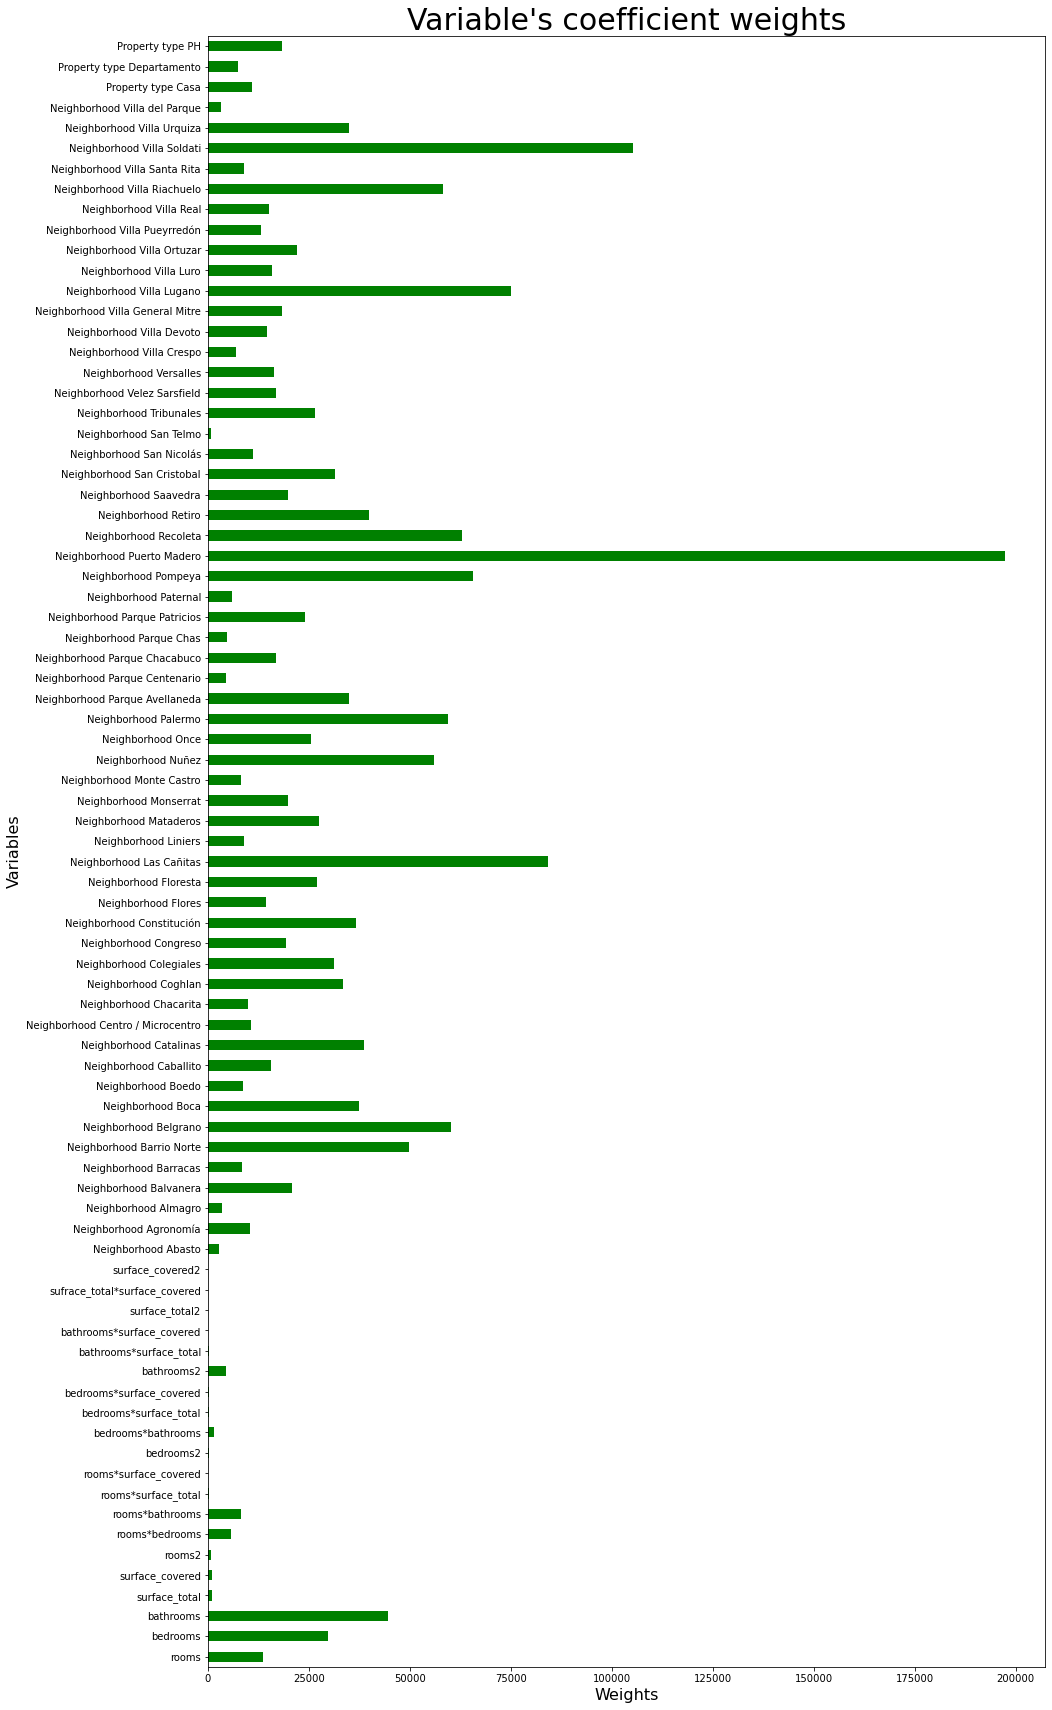

In [61]:
plt.figure(figsize = (15,30))
index = coef_names
ax = np.abs(coef_importance['Coefficients']).plot.barh(color = 'g')
plt.xlabel('Weights', fontsize = 16)
plt.ylabel('Variables', fontsize = 16)
plt.title("Variable's coefficient weights", fontsize = 30)
plt.show()

De lo anterior, se sigue que las variables que más peso tienen en esta regresión son <i><b>Neighborhood Puerto Madero</b></i>, <i><b>Neighborhood Villa Soldati</b></i> y <i><b>Neighborhood Las Cañitas</b></i>.

Veamos cuáles son sus coeficientes.

In [62]:
print(coef_importance.loc['Neighborhood Puerto Madero'], '\n')
print(coef_importance.loc['Neighborhood Villa Soldati'], '\n')
print(coef_importance.loc['Neighborhood Las Cañitas'])

Coefficients    197332.764149
Name: Neighborhood Puerto Madero, dtype: float64 

Coefficients   -105277.583726
Name: Neighborhood Villa Soldati, dtype: float64 

Coefficients    84186.671931
Name: Neighborhood Las Cañitas, dtype: float64


Esto nos dice que conforme el valor de las variables <i><b>Neighborhood Puerto Madero</b></i> y <i><b>Neighborhood Las Cañitas</b></i> tiendan a crecer, el promedio de nuestra variable objetivo, <i><b>price</b></i>, también tiende a crecer, mientras que conforme la variable <i><b>Neighborhood Villa Soldati</b></i> tiende a crecer, nuestra variable objetivo tiende a decrecer.

Ahora, aplicaremos `cross_val_score` e imprimiremos nuestras métricas así como la métrica promedio y su desviación estándard.

In [63]:
cv_p = abs(cross_val_score(lin_reg, X_train_p, y_train, scoring = 'neg_root_mean_squared_error',
                         cv = 5))
print('The average RMSE and its standard deviation is:', abs(cv_p.mean()), '±',
      (abs(cv_p.std())), '\n')
print('The 5 RMSE are:', *cv_p)

The average RMSE and its standard deviation is: 46832.76354683918 ± 462.64265687962137 

The 5 RMSE are: 46907.73086038774 47311.07596159895 46428.29672689165 46183.412649115206 47333.30153620239


Definimos la función `evaluar_regresion` para ver cómo se comportan nuestros modelos, haciendo un histograma de errores de <i>Train</i> y <i>Test</i> así como un diagrama de dispersión de `y` contra `y_pred`.

In [64]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Root Mean Squared Error in Train: {rmse_train}')
    print(f'Root Mean Squared Error in Test: {rmse_test}')
    
    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (10, 4))
    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'Train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'Test')
    plt.xlabel('Errores')
    plt.legend()
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s = 2)
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    ax.plot(lims, lims, 'k-', alpha = 0.75, zorder = 0)
    plt.xlabel('y(test)')
    plt.ylabel('y_pred(test)')
    plt.tight_layout()
    plt.show()

Evaluemos ahora a nuestro modelo con nuestra función.

Root Mean Squared Error in Train: 46766.70039315665
Root Mean Squared Error in Test: 46099.83572336388


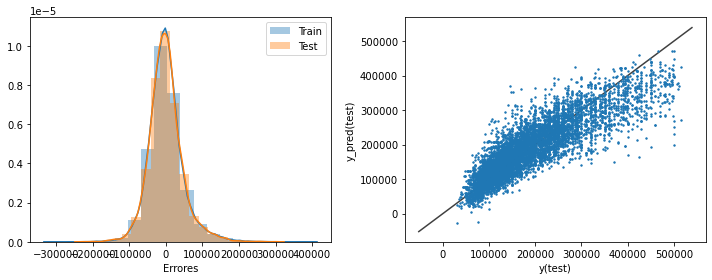

In [65]:
evaluate_model(lin_reg, X_train_p, X_test_p, y_train, y_test)

El modelo arroja una métrica ligeramente inferior que la media del `cross_val_score` para el <i>Test</i>. Sin embargo, ya es ligeramente mejor que el <i>Benchmark</i>.

**- Regularización**

Apliquemos ahora modelos de Regularización, tanto `Ridge` como `Lasso` con sus valores por defecto, y veamos si nuestra métrica logra mejorarse.

Comencemos con `Ridge`. Definamos nuestro modelo, entrenémoslo e imprimamos sus coeficientes así como la ordenada al origen.

In [66]:
reg_ridge = Ridge()
reg_ridge.fit(X_train_p, y_train)

coef_reg_ridge = list(reg_ridge.coef_.flatten())
print('Coefficients:', coef_reg_ridge, '\n')
print(f'Intercept: {reg_ridge.intercept_}')

Coefficients: [13565.37052278403, 29734.377699876917, 44628.79830956142, 983.2068008569266, 1105.0101266628042, -780.8317374591174, -5802.900902430371, -8034.0058191218095, 321.4446711541949, -133.38481332375483, -289.62071764496466, 1413.5264032726577, 200.3728173441382, -312.42247144572656, -4472.0571471953845, 262.30219813126706, -48.14526596849414, -8.798537798353536, -3.2604767803509342, 7.240950200683756, 2607.134147916161, 9988.251930600416, 3170.7919098736593, -21099.911469130027, 8139.297486102184, 49528.57319799661, 59911.49064257278, -37574.90622862356, -8807.000074218984, 15470.697169935138, -31087.023606329745, -10848.822169738023, 9774.602376729228, 33105.87522874107, 30824.39764269775, -19568.59175084684, -36699.20713854509, -14559.357870318596, -27080.068635012605, 83764.67993361049, -9049.147740243949, -27622.87181294794, -20001.952765677946, -8403.068633157001, 55646.664640285926, -25682.570196696528, 59269.778530132055, -34969.329982048366, 4107.550277028532, -16972.

### - Análisis del peso de las variables

Veamos ahora qué variables son las que más peso tienen en términos de sus coeficientes.

In [67]:
coef_importance = pd.DataFrame()
index_ = coef_names
coef_importance['Coefficients'] = coef_reg_ridge
coef_importance.index = index_
coef_importance

Coefficients
rooms                          13565.370523
bedrooms                       29734.377700
bathrooms                      44628.798310
surface_total                    983.206801
surface_covered                 1105.010127
...                                     ...
Neighborhood Villa Urquiza     34717.980189
Neighborhood Villa del Parque   3021.073943
Property type Casa             10828.758421
Property type Departamento      7418.412497
Property type PH              -18247.170919

[80 rows x 1 columns]

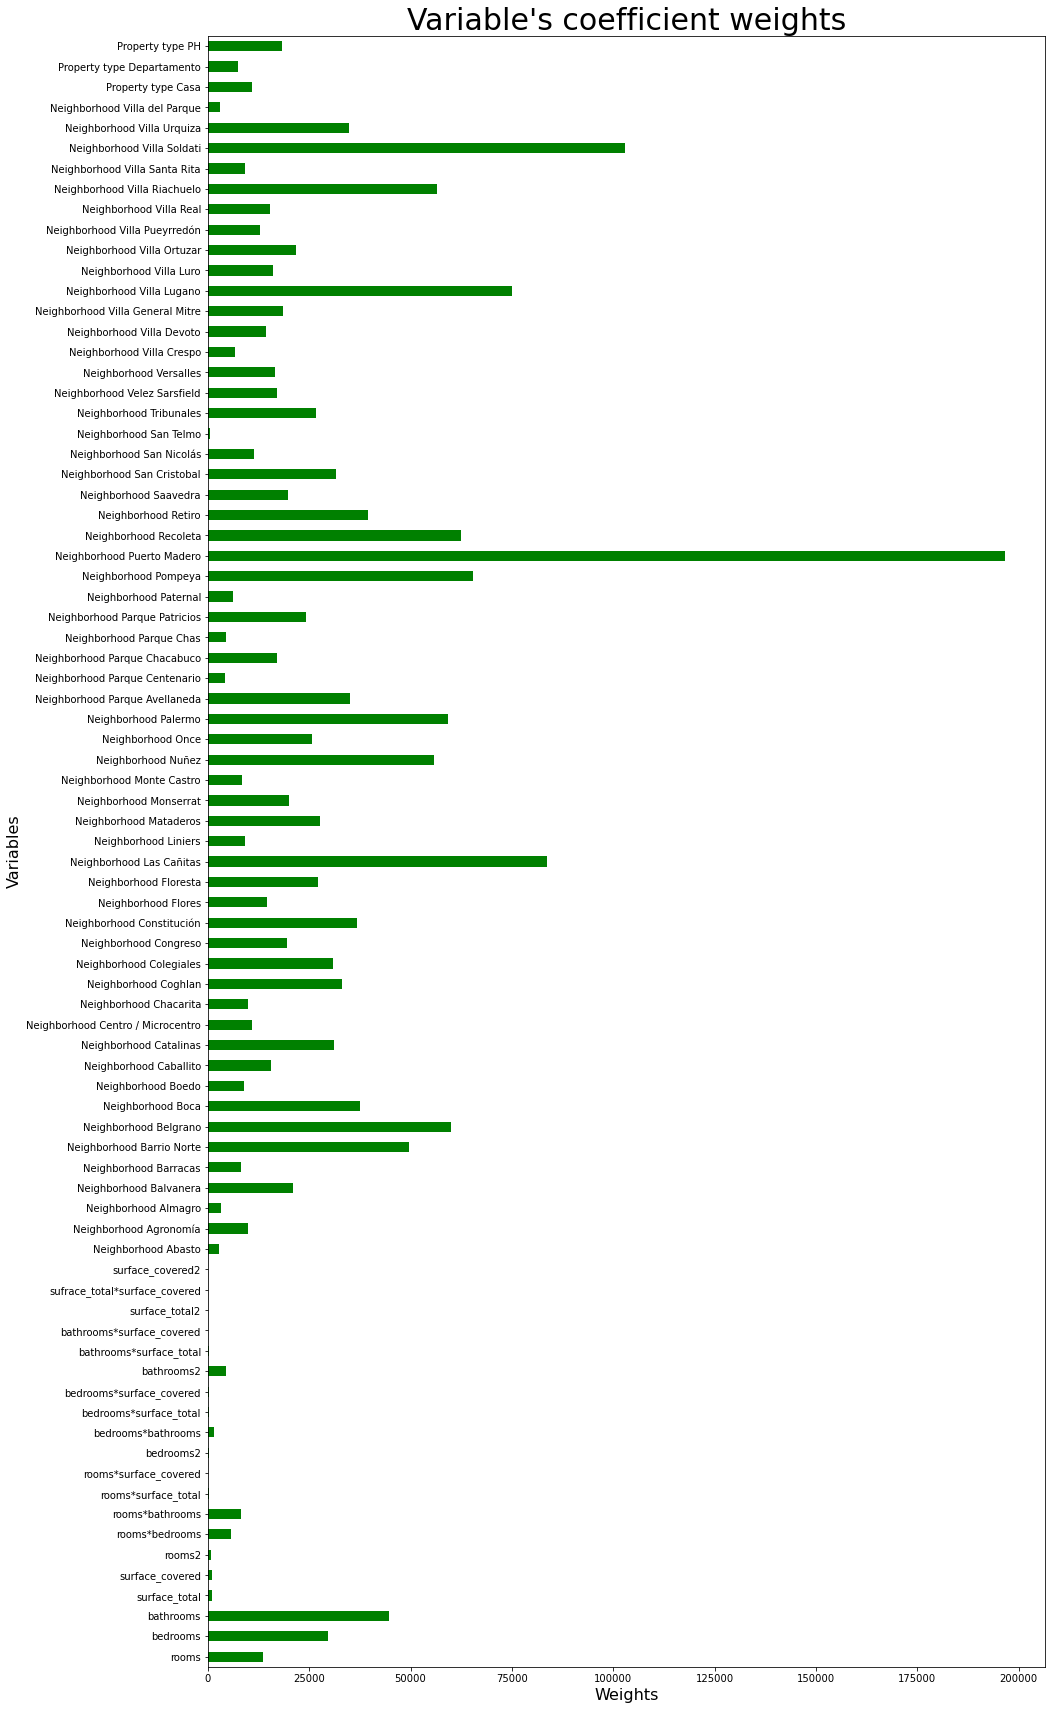

In [68]:
plt.figure(figsize = (15,30))
index = coef_names
ax = np.abs(coef_importance['Coefficients']).plot.barh(color = 'g')
plt.xlabel('Weights', fontsize = 16)
plt.ylabel('Variables', fontsize = 16)
plt.title("Variable's coefficient weights", fontsize = 30)
plt.show()

De lo anterior, se sigue que las variables que más peso tienen en esta regresión son <i><b>Neighborhood Puerto Madero</b></i>, <i><b>Neighborhood Villa Soldati</b></i> y <i><b>Neighborhood Las Cañitas</b></i>.

Veamos cuáles son sus coeficientes.

In [69]:
print(coef_importance.loc['Neighborhood Puerto Madero'], '\n')
print(coef_importance.loc['Neighborhood Villa Soldati'], '\n')
print(coef_importance.loc['Neighborhood Las Cañitas'])

Coefficients    196663.595618
Name: Neighborhood Puerto Madero, dtype: float64 

Coefficients   -102852.305873
Name: Neighborhood Villa Soldati, dtype: float64 

Coefficients    83764.679934
Name: Neighborhood Las Cañitas, dtype: float64


Esto nos dice que conforme el valor de las variables <i><b>Neighborhood Puerto Madero</b></i> y <i><b>Neighborhood Las Cañitas</b></i> tiendan a crecer, el promedio de nuestra variable objetivo, <i><b>price</b></i>, también tiende a crecer, mientras que conforme la variable <i><b>Neighborhood Villa Soldati</b></i> tiende a crecer, nuestra variable objetivo tiende a decrecer.

Hagamos ahora un `cross_val_score`.

In [70]:
cv_r = abs(cross_val_score(reg_ridge, X_train_p, y_train, scoring = 'neg_root_mean_squared_error',
                         cv = 5))
print('The average RMSE and its standard deviation is:', abs(cv_r.mean()), '±',
      (abs(cv_r.std())), '\n')
print('The 5 RMSEs are:', *cv_r)

The average RMSE and its standard deviation is: 46832.666556902266 ± 462.52413110865837 

The 5 RMSEs are: 46906.60238057955 47310.82660572651 46427.741313872306 46184.30073125721 47333.86175307576


Y ahora, evaluemos a este modelo.

Root Mean Squared Error in Train: 46766.82436222601
Root Mean Squared Error in Test: 46098.304128101656


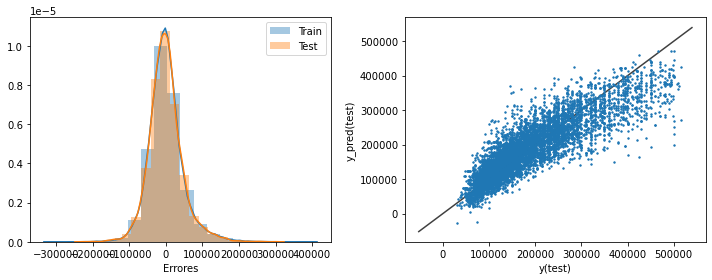

In [71]:
evaluate_model(reg_ridge, X_train_p, X_test_p, y_train, y_test)

Vemos que después de regularizar nuestra métrica en el <i>Test</i> es ligeramente inferior a la promedio arrojada en el `cross_val_score` y es prácticamente igual a la obtenida mediante `lin_reg`.

Veamos ahora qué resultados obtenemos al regularizar mediante `Lasso`. Así, definamos nuestro modelo, entrenémoslo e imprimamos sus coeficientes así como la ordenada al origen.

In [72]:
import warnings
warnings.filterwarnings('ignore')

reg_lasso = Lasso()
reg_lasso.fit(X_train_p, y_train)

coef_reg_lasso = list(reg_lasso.coef_.flatten())
print('Coefficients:', coef_reg_lasso, '\n')
print(f'Intercept: {reg_ridge.intercept_}')

Coefficients: [11901.629324747824, 31411.988137287797, 42407.30874480645, 997.1607671079106, 1094.0361102827417, -1628.7285098432183, -3900.4985319035936, -5341.973314656255, 340.0382752685356, -165.45630671921845, -1344.5919679320125, -1211.643222677183, 178.68892264178092, -280.00759665131733, -4417.048959686709, 261.2808496555703, -58.314610554880396, -9.502293677154686, -1.574371308691171, 6.43619723971678, 6918.444529207532, 13843.995400057158, 7670.3573817349725, -16566.271308831176, 12557.551943760976, 54082.59926515776, 64395.38900624862, -33029.77696879744, -4261.462528556357, 19966.454171900463, -16274.073289751434, -6039.024307224458, 14052.141791968374, 37531.63003820912, 35279.5534077321, -14900.638597499854, -32081.381191266057, -10036.020616805365, -22535.800423863107, 88356.13775315943, -4523.671248342853, -23161.54648931967, -15240.845633674542, -3794.694693395825, 60118.97879075912, -21132.661859530603, 63812.78601322949, -30255.296677817554, 8589.503905796575, -12410

### - Análisis del peso de las variables

Veamos ahora qué variables son las que más peso tienen en términos de sus coeficientes.

In [73]:
coef_importance = pd.DataFrame()
index_ = coef_names
coef_importance['Coefficients'] = coef_reg_lasso
coef_importance.index = index_
coef_importance

Coefficients
rooms                          11901.629325
bedrooms                       31411.988137
bathrooms                      42407.308745
surface_total                    997.160767
surface_covered                 1094.036110
...                                     ...
Neighborhood Villa Urquiza     39181.921893
Neighborhood Villa del Parque   7449.575589
Property type Casa             16290.019164
Property type Departamento     13103.292471
Property type PH              -12486.249556

[80 rows x 1 columns]

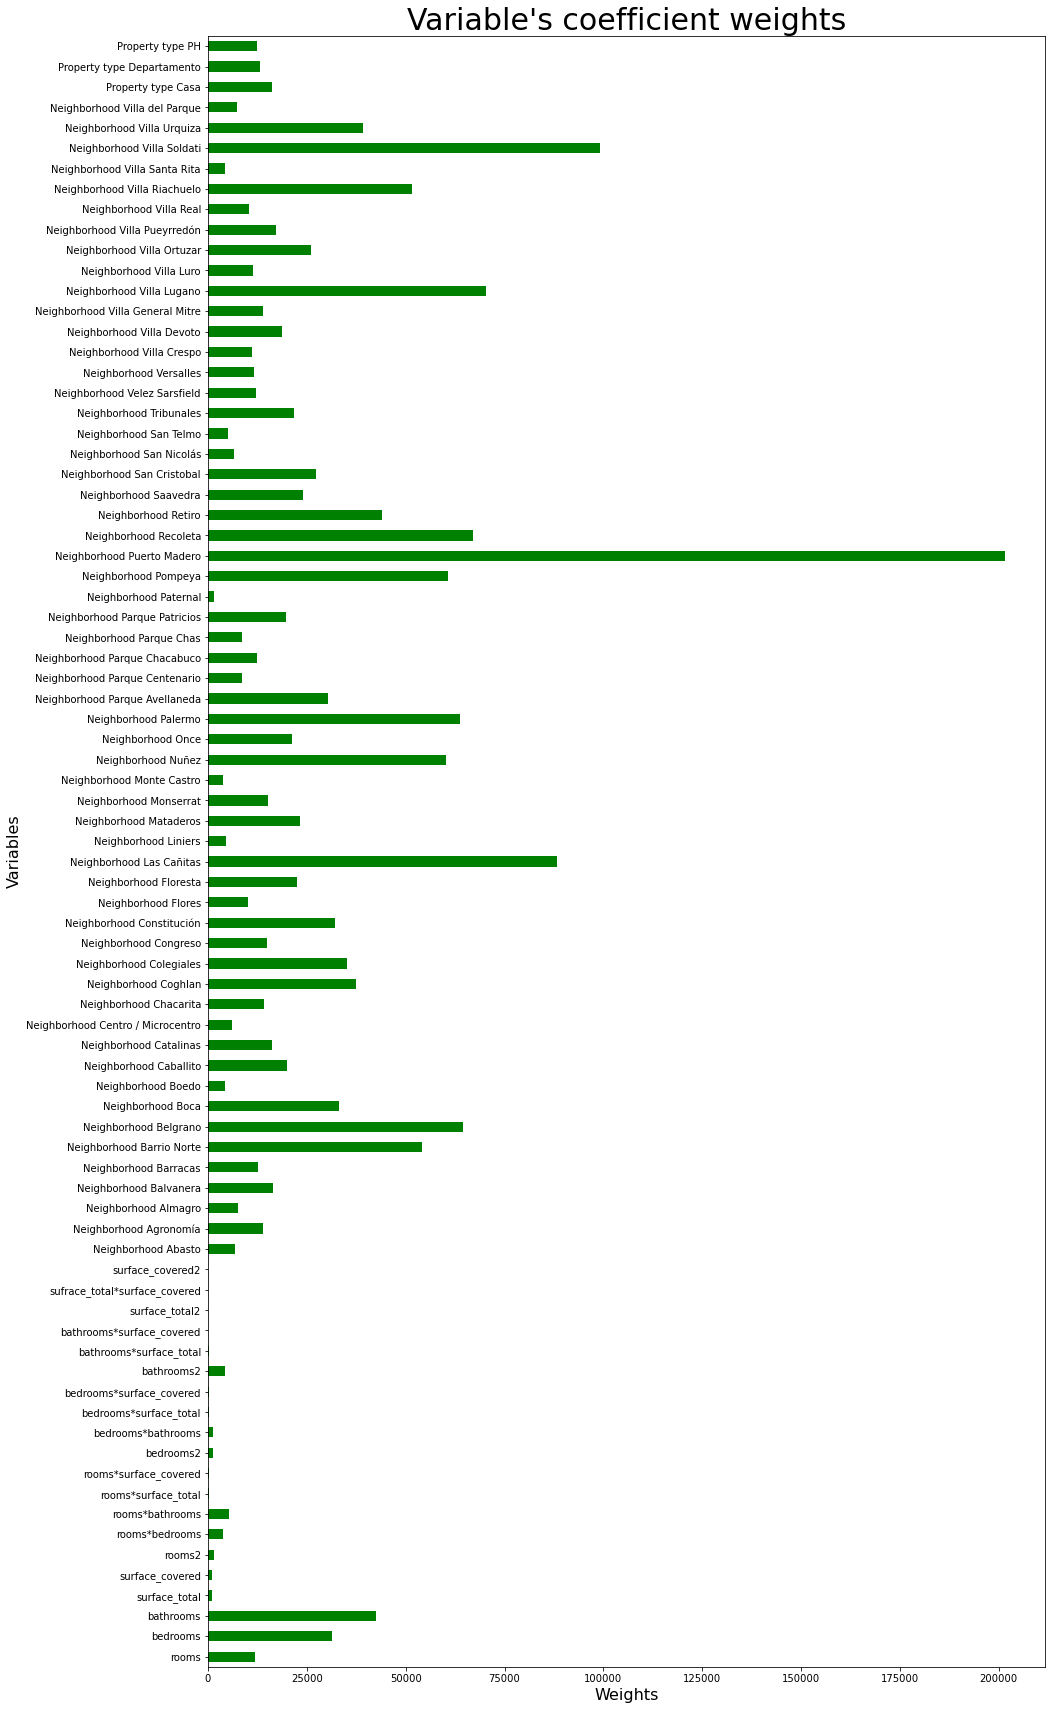

In [74]:
plt.figure(figsize = (15,30))
index = coef_names
ax = np.abs(coef_importance['Coefficients']).plot.barh(color = 'g')
plt.xlabel('Weights', fontsize = 16)
plt.ylabel('Variables', fontsize = 16)
plt.title("Variable's coefficient weights", fontsize = 30)
plt.show()

De lo anterior, se sigue que las variables que más peso tienen en esta regresión son nuevamente <i><b>Neighborhood Puerto Madero</b></i>, <i><b>Neighborhood Villa Soldati</b></i> y <i><b>Neighborhood Las Cañitas</b></i>.

Veamos cuáles son sus coeficientes.

In [75]:
print(coef_importance.loc['Neighborhood Puerto Madero'], '\n')
print(coef_importance.loc['Neighborhood Villa Soldati'], '\n')
print(coef_importance.loc['Neighborhood Las Cañitas'])

Coefficients    201599.232338
Name: Neighborhood Puerto Madero, dtype: float64 

Coefficients   -99218.016257
Name: Neighborhood Villa Soldati, dtype: float64 

Coefficients    88356.137753
Name: Neighborhood Las Cañitas, dtype: float64


Como en `Ridge`, conforme el valor de las variables <i><b>Neighborhood Puerto Madero</b></i> y <i><b>Neighborhood Las Cañitas</b></i> tiendan a crecer, el promedio de nuestra variable objetivo, <i><b>price</b></i>, también tiende a crecer, mientras que conforme la variable <i><b>Neighborhood Villa Soldati</b></i> tiende a crecer, nuestra variable objetivo tiende a decrecer.

Aplicamos `cross_val_score`.

In [76]:
cv_l = abs(cross_val_score(reg_lasso, X_train_p, y_train, scoring = 'neg_root_mean_squared_error',
                         cv = 5))
print('The average RMSE and its standard deviation is:', abs(cv_l.mean()), '±',
      (abs(cv_l.std())), '\n')
print('The 5 RMSEs are:', *cv_l)

The average RMSE and its standard deviation is: 46833.00773586241 ± 463.735932154471 

The 5 RMSEs are: 46899.54074249691 47313.128041960445 46436.35318576549 46178.470487771585 47337.546221317665


Ahora, evaluemos nuestro modelo y veamos nuestra métrica tanto en los datos de entrenamiento como en los de prueba.

Root Mean Squared Error in Train: 46770.345793214256
Root Mean Squared Error in Test: 46102.892746074045


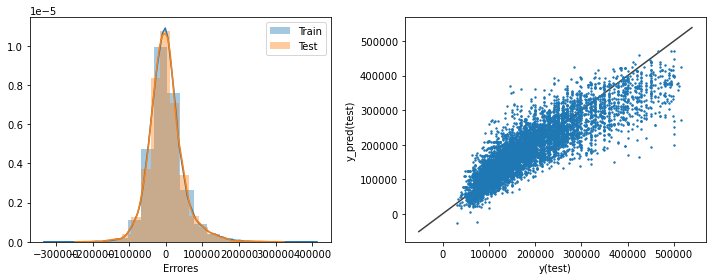

In [77]:
evaluate_model(reg_lasso, X_train_p, X_test_p, y_train, y_test)

Nuevamene, respecto a la media obtenida por `cross_val_score` la métrica mejora ligeramente.

Esta regularización deja nuestra métrica prácticamente igual respecto a `lin_reg` y a `reg_ridge`.

**Conclusiones:** En términos de la métrica, los tres modelos tienen el mismo <i>performance</i>. Aun cuando en teoría el regularizar tiene como consecuencia el eliminar variables que 'jalan' la varianza, en este caso no se aprecia tal efecto pues las variables cuyos coeficientes tienen el mayor peso en los tres modelos fueron las mismas y los respectivos coeficientes varían ligeramente entre ellos. Así, dado que regularizar no pareció aportar ventaja alguna, se considera que hasta aquí el mejor modelo es `lin_reg`.

### - Optimización de hiperparámetros

Veamos ahora si optimizando los hiperparámetros de nuestros modelos mediante <b>GridSearchCV</b> podemos mejorar la métrica.

Comenzamos con la Regularización Lineal con atributos polinomiales. Definamos nuestro modelo.

In [78]:
lin_reg_gs = LinearRegression()

Definimos la regresión polinomial que utilizaremos, aplicándola únicamente sobre nuestras varialbes independientes no binarias, así como el <i>pipeline</i> que usaremos.

In [79]:
columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

reg_poly = make_column_transformer((PolynomialFeatures(include_bias = False), columns),
                                    remainder = 'passthrough')

pipeline_poly = make_pipeline(reg_poly, lin_reg_gs)

A continuación, definimos la grilla que utilizaremos así como sus parámetros.

In [80]:
param_grid = {'columntransformer__polynomialfeatures__degree': np.arange(6),
              'linearregression__fit_intercept': [True, False]}

Ahora, instanciamos el <b>GridSearchCV</b> que utilizaremos.

In [81]:
lin_reg_gs_grid = GridSearchCV(pipeline_poly, param_grid, cv = 5,
                       scoring = 'neg_root_mean_squared_error')

Y ahora, entrenamos al <b>GridSearchCV</b>.

In [82]:
lin_reg_gs_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('polynomialfeatures',
                                                                         PolynomialFeatures(include_bias=False),
                                                                         ['rooms',
                                                                          'bedrooms',
                                                                          'bathrooms',
                                                                          'surface_total',
                                                                          'surface_covered'])])),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'columntransformer__polynomialfeatur

Imprimimos en pantalla los mejores parámetros y nuestro mejor <i>score</i>.

In [83]:
print('Best parameters: ' + str(lin_reg_gs_grid.best_params_))
print('Best Score: ' + str(abs(lin_reg_gs_grid.best_score_)) + '\n')

Best parameters: {'columntransformer__polynomialfeatures__degree': 4, 'linearregression__fit_intercept': True}
Best Score: 45821.40176490902



Entrenamos ahora la regresión polinomial con estos parámetros y definimos nuestros nuevos conjuntos de entrenamiento y de prueba.

In [84]:
reg_poly_gs = make_column_transformer((PolynomialFeatures(include_bias = False,
           degree = lin_reg_gs_grid.best_params_['columntransformer__polynomialfeatures__degree']),
           columns), remainder = 'passthrough')

X_train_p = reg_poly_gs.fit_transform(X_train)
X_test_p = reg_poly_gs.transform(X_test)

Y finalmente, entrenamos a nuestra regresión lineal con `X_train_p` e `y_train`.

In [85]:
lin_reg_gs.fit(X_train_p, y_train)

LinearRegression()

Veamos cuáles son los coeficientes de este modelo así como su intersección con el eje de las ordenadas.

In [86]:
coef_lin_reg_gs = list(lin_reg_gs.coef_.flatten())
print('Coefficients:', coef_lin_reg_gs, '\n')
print(f'Intercept: {lin_reg_gs.intercept_}')

Coefficients: [7859766.700982377, 9300.616462000859, -3306.9510839626423, 527.8035007914224, 1296.4968994573665, 13861.379157826594, -40061.67989547043, -14460449.75550344, 3127.2524272769547, -1947.3637978186343, 28655.256692884588, 11770.3918233938, 817.6045187124232, -1426.1607379701015, -7730.045389075724, 848.5648201509291, 335.89566494545693, -19.255137380227097, -101.52930786304205, 106.02826699091383, -4820.678177589569, 6935.900215010404, 8097.868608249642, -990.7722517726543, 1017.5958223464604, 15452.482630959159, -37491.88732102015, 246.05928570107062, -163.94088918751186, 7886050.28379877, 624.2465600668256, -388.5445816150923, -42.55743501515826, 104.5423153770389, -80.88361967593664, -6272.101576884372, 5262.942982836083, 415.09714986401013, -1396.9630459706668, 10484.87234556635, 998.9649109360334, -723.9861340942534, -24.12793069210602, 19.587325376836816, 37.863535238895565, -10079.869064283092, 942.4583873150498, -615.2642242040006, -47.52533718549239, 17.29870715918

### - Análisis del peso de las variables

Veamos ahora qué variables son las que más peso tienen en términos de sus coeficientes.

Dado que el grado del polinomio cambió, debemos redefinir nuestra lista de variables.

In [87]:
coef_names_gs = ['rooms','bedrooms','bathrooms','surface_total','surface_covered','rooms^2','rooms_bedrooms','rooms_bathrooms',
            'rooms_surface_total','rooms_surface_covered','bedrooms^2','bedrooms_bahrooms','bedrooms_surface_total',
            'bedrooms_surface_covered','bathrooms^2','bathrooms_surface_total','bathrooms_surface_covered','surface_total^2',
            'surface_total_surface_covered','surfce_covered^2','rooms^3','rooms^2_bedrooms','rooms^2_bathrooms',
            'rooms^2_surface_total','rooms^2_surface_covered','rooms_bedrooms^2','rooms_bedrooms_bathrooms',
            'rooms_bedrooms_surface_otal','rooms_bedrooms_surface_covered','rooms_bathrooms^2','rooms_bathrooms_surface_total',
            'rooms_bathrooms_surface_covered','rooms_surface_total^2','rooms_surface_total_surface_covered','rooms_surface_covered^2',
            'bedrooms^3','bedrooms^2_bathrooms','bedrooms^2_surface_total','bedrooms^2_surfac_covered','bedrooms_bathrooms^2',
            'bedrooms_bathrooms_surface_total','bedrooms_bathrooms_surface_covered','bedrooms_surface_total^2',
            'bedrooms_surface_total_surface_covered','bedrooms_urface_covered^2','bathrooms^3','bathrooms^2_surface_total',
            'bathrooms^2_surface_covered','bathrooms_surface_total^2','bathrooms_surface_total_surface_covered',
            'bathrooms_surface_coveed^2','surface_total^3','surface_total^2_surface_covered','surface_total_surface_covered^2',
            'surface_covered^3','rooms^4','rooms^3_bedrooms','rooms^3_bathrooms','rooms^3_surface_total',
            'rooms^3_surface_covered','rooms^2_bedrooms^2','rooms^2_bedrooms_bathrooms','rooms^2_bedrooms_surface_total',
            'rooms^2_bedrooms_surface_covered','rooms^2_bathrooms^2','rooms^2_bathroos_surface_total',
            'rooms^2_bathrooms_surface_covered','rooms^2_surface_total^2','rooms^2_surface_total_surface_covered',
            'rooms^2_surface_covered^2','rooms_bedrooms^3','rooms_bedrooms^2bathrooms','rooms_bedrooms^2_surface_total',
            'rooms_bedrooms^2_surface_covered','rooms_bedrooms_bathrooms^2','rooms_bedrooms_bathrooms_surface_total',
            'rooms_bedrooms_bathrooms_surface_overed','rooms_bedrooms_surface_total^2',
            'rooms_bedrooms_surface_total_surface_covered','rooms_bedrooms_surface_covered^2','rooms_bathrooms^3',
            'rooms_bathrooms^2_surface_total','roomsbathrooms^2_surface_covered','rooms_bathrooms_surface_total^2',
            'rooms_bathrooms_surface_total_surface_covered','rooms_bathrooms_surface_covered^2','rooms_surface_total^3',
            'rooms_surfae_total^2_surface_covered','rooms_surface_total_surface_covered^2','rooms_surface_covered^3',
            'bedrooms^4','bedrooms^3_bathrooms','bedrooms^3_surface_total','bedrooms^3_surface_covered',
            'bedrooms^2_bathrooms^2','bedrooms^2_bathrooms_surface_total','bedrooms^2_bathrooms_surface_covered',
            'bedrooms^2_surface_total^2','bedrooms^2_surface_total_surface_covered','bedrooms2_surface_covered^2',
            'bedrooms_bathrooms^3','bedrooms_bathrooms^2_surface_total','bedrooms_bathrooms^2_surface_covered',
            'bedrooms_bathrooms_surface_total^2','bedrooms_bathrooms_surfac_total_surface_covered',
            'bedrooms_bathrooms_surface_covered^2','bedrooms_surface_total^3','bedrooms_surface_total^2_surface_covered',
            'bedrooms_surface_total_surface_covered^2','bedroos_surface_covered^3','bathrooms^4',
            'bathrooms^3_surface_total','bathrooms^3_surface_covered','bathrooms^2_surface_total^2',
            'bathrooms^2_surface_total_surface_covered','bathrooms^2_surace_covered^2','bathrooms_surface_total^3',
            'bathrooms_surface_total^2_surface_covered','bathrooms_surface_total_surface_covered^2',
            'bathrooms_surface_covered^3','surface_total^4','surace_total^3_surface_covered',
            'surface_total^2_surface_covered^2','surface_total_surface_covered^3','surface_covered^4','Neighborhood Abasto',
            'Neighborhood Agronomía', 'Neighborhood Almagro', 'Neighborhood Balvanera',
            'Neighborhood Barracas', 'Neighborhood Barrio Norte', 'Neighborhood Belgrano',
            'Neighborhood Boca', 'Neighborhood Boedo', 'Neighborhood Caballito',
            'Neighborhood Catalinas', 'Neighborhood Centro / Microcentro',
            'Neighborhood Chacarita', 'Neighborhood Coghlan', 'Neighborhood Colegiales',
            'Neighborhood Congreso', 'Neighborhood Constitución', 'Neighborhood Flores',
            'Neighborhood Floresta', 'Neighborhood Las Cañitas', 'Neighborhood Liniers',
            'Neighborhood Mataderos', 'Neighborhood Monserrat', 'Neighborhood Monte Castro',
            'Neighborhood Nuñez', 'Neighborhood Once','Neighborhood Palermo',
            'Neighborhood Parque Avellaneda', 'Neighborhood Parque Centenario',
            'Neighborhood Parque Chacabuco', 'Neighborhood Parque Chas',
            'Neighborhood Parque Patricios', 'Neighborhood Paternal', 'Neighborhood Pompeya',
            'Neighborhood Puerto Madero', 'Neighborhood Recoleta', 'Neighborhood Retiro',
            'Neighborhood Saavedra', 'Neighborhood San Cristobal', 'Neighborhood San Nicolás',
            'Neighborhood San Telmo', 'Neighborhood Tribunales', 'Neighborhood Velez Sarsfield',
            'Neighborhood Versalles', 'Neighborhood Villa Crespo', 'Neighborhood Villa Devoto',
            'Neighborhood Villa General Mitre', 'Neighborhood Villa Lugano',
            'Neighborhood Villa Luro', 'Neighborhood Villa Ortuzar',
            'Neighborhood Villa Pueyrredón', 'Neighborhood Villa Real',
            'Neighborhood Villa Riachuelo', 'Neighborhood Villa Santa Rita',
            'Neighborhood Villa Soldati', 'Neighborhood Villa Urquiza',
            'Neighborhood Villa del Parque','Property type Casa', 'Property type Departamento',
            'Property type PH']

In [88]:
coef_importance = pd.DataFrame()
index_ = coef_names_gs
coef_importance['Coefficients'] = coef_lin_reg_gs
coef_importance.index = index_
coef_importance

Coefficients
rooms                          7.859767e+06
bedrooms                       9.300616e+03
bathrooms                     -3.306951e+03
surface_total                  5.278035e+02
surface_covered                1.296497e+03
...                                     ...
Neighborhood Villa Urquiza     3.335445e+04
Neighborhood Villa del Parque  2.510242e+03
Property type Casa             6.868351e+03
Property type Departamento     8.431944e+03
Property type PH              -1.530030e+04

[185 rows x 1 columns]

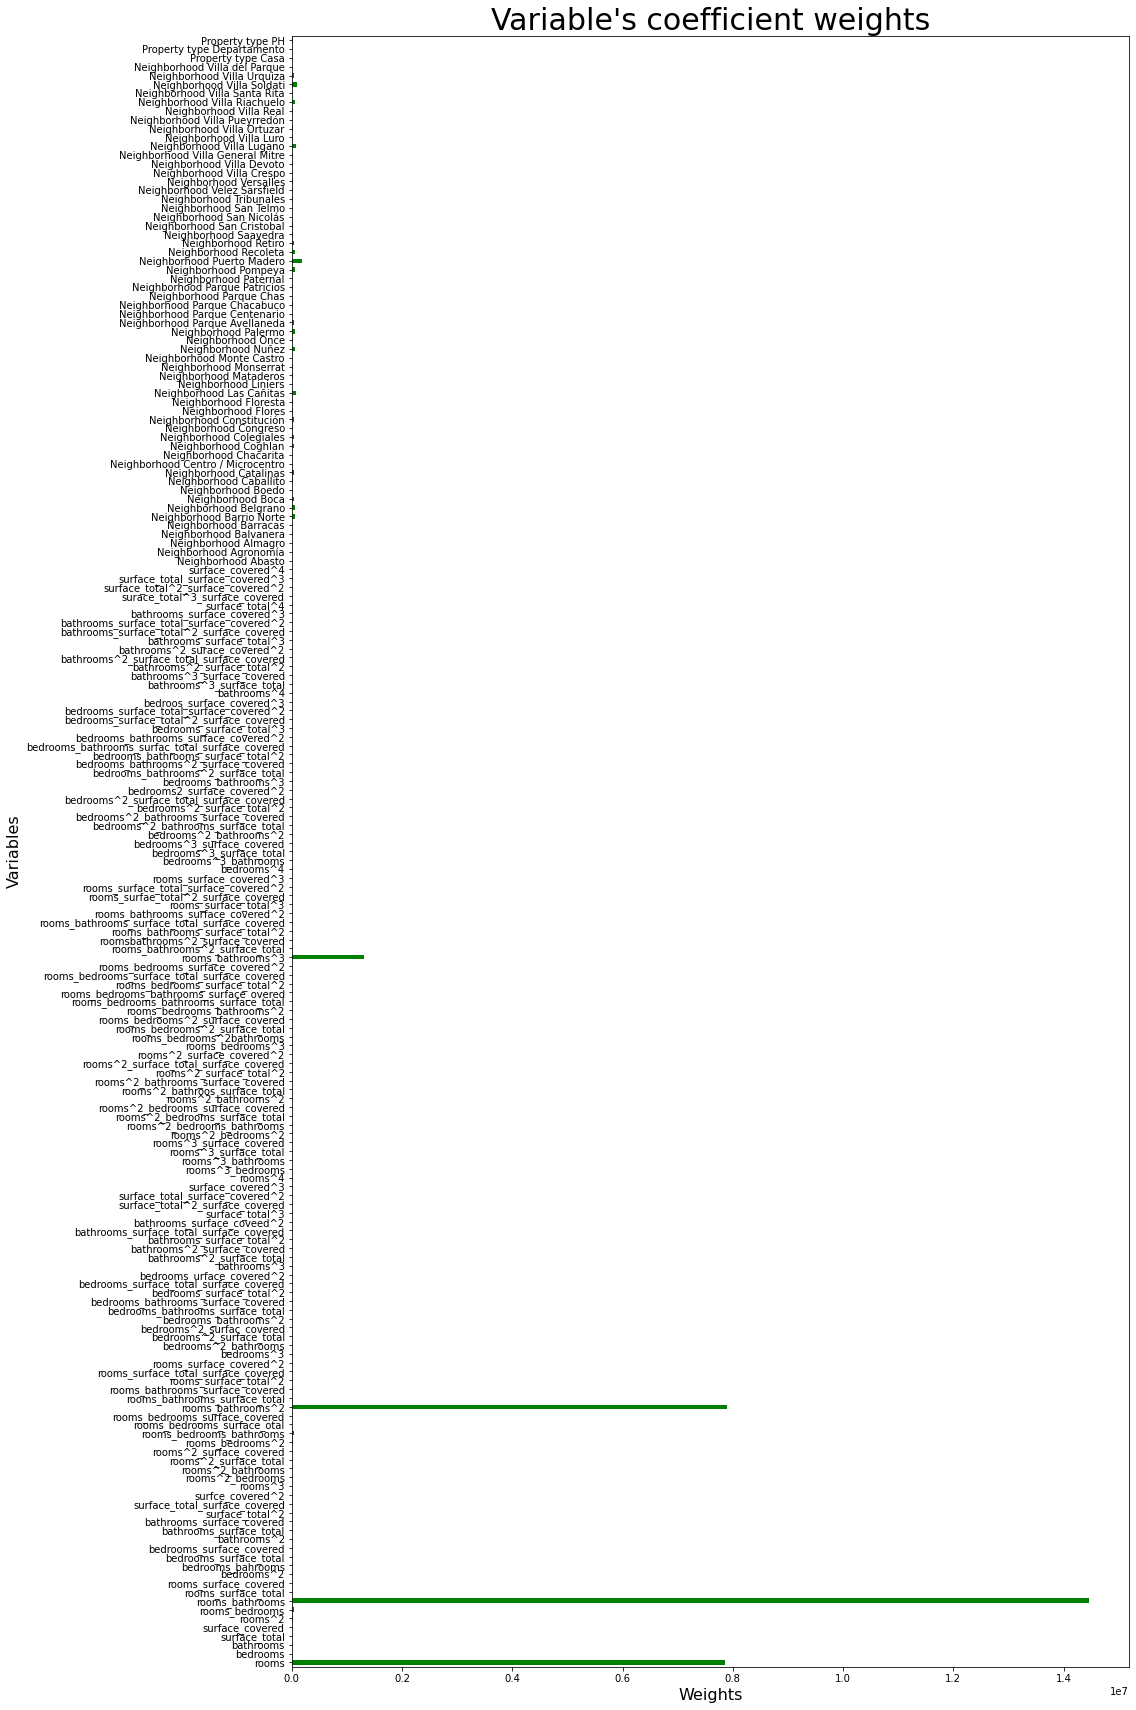

In [89]:
plt.figure(figsize = (15,30))
index = coef_names_gs
ax = np.abs(coef_importance['Coefficients']).plot.barh(color = 'g')
plt.xlabel('Weights', fontsize = 16)
plt.ylabel('Variables', fontsize = 16)
plt.title("Variable's coefficient weights", fontsize = 30)
plt.show()

De lo anterior, se sigue que las variables que más peso tienen en esta regresión son nuevamente <i><b>rooms_bathrooms</b></i>, <i><b>rooms_bathrooms^2</b></i> y <i><b>rooms</b></i>.

Veamos cuáles son sus coeficientes.

In [90]:
print(coef_importance.loc['rooms'], '\n')
print(coef_importance.loc['rooms_bathrooms'], '\n')
print(coef_importance.loc['rooms_bathrooms^2'])

Coefficients    7.859767e+06
Name: rooms, dtype: float64 

Coefficients   -1.446045e+07
Name: rooms_bathrooms, dtype: float64 

Coefficients    7.886050e+06
Name: rooms_bathrooms^2, dtype: float64


Vemos que conforme el valor de las variables <i><b>rooms</b></i> y <i><b>rooms_bathrooms^2</b></i> tiendan a crecer, el promedio de nuestra variable objetivo, <i><b>price</b></i>, también tiende a crecer, mientras que conforme la variable <i><b>rooms_bathrooms</b></i> tiende a crecer, nuestra variable objetivo tiende a decrecer.

Y ahora, evaluamos a nuestro modelo.

Root Mean Squared Error in Train: 45488.37619669361
Root Mean Squared Error in Test: 45291.242044959996


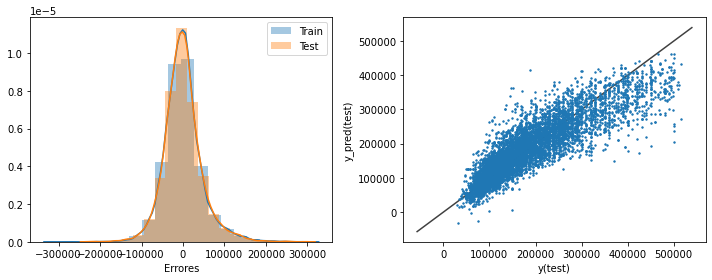

In [91]:
evaluate_model(lin_reg_gs, X_train_p, X_test_p, y_train, y_test)

La métrica mejora ligeramente respecto al mejor <i>score</i> obtenido vía el `cv` del <b>GridSearchCV</b> y es también ligeramente mejor a la del modelo `lin_reg`.

### - Regularización (hiperparámetros optimizados)

Comenzaremos probando con `Ridge`.

In [92]:
reg_ridge_gs = Ridge()
param_grid_r = {'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
grid_r = GridSearchCV(estimator = reg_ridge_gs, param_grid = param_grid_r, cv = 5)

Ahora, entrenamos a `grid_r` e imprimimos el mejor parámetro `alpha`.

In [93]:
grid_r.fit(X_train_p, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]})

Imprimimos en pantalla nuestro mejor parámetro.

In [94]:
print('Best parameters: ' + str(grid_r.best_params_) + '\n')
print('Best Score: ' + str(abs(lin_reg_gs_grid.best_score_)))

Best parameters: {'alpha': 1}

Best Score: 45821.40176490902


Entrenemos ahora a nuestro modelo, con el mejor `alpha` y veamos cómo son las pendientes.

In [95]:
reg_ridge_gs = Ridge(alpha = grid_r.best_params_['alpha'])
reg_ridge_gs.fit(X_train_p, y_train)

coef_reg_ridge_gs = list(reg_ridge_gs.coef_.flatten())
print('Coefficients:', coef_reg_ridge_gs, '\n')
print(f'Intercept: {reg_ridge_gs.intercept_}')

Coefficients: [-21018.07366976387, 6996.247941236689, -3238.0649793716316, 505.4857244850601, 1294.404732321789, 10859.93102109418, -33271.34238587001, -9802.308141355508, 3138.0412965045134, -1964.9611877373434, 24984.807602338788, 10635.976534203262, 825.1313594846816, -1395.7625528614353, -7583.286769718914, 840.1973303281407, 331.79069549766615, -19.109174380534895, -101.59965242711205, 106.19347446324689, -4209.21871111266, 6108.800482631, 7648.5183196932385, -965.0274109277206, 1013.5400945429425, 15060.151430253845, -36488.32977922164, 174.40851702645355, -164.93091309142633, 3762.146681377948, 613.8928371737042, -359.97032586395187, -42.76279573131674, 104.92991401266548, -81.09921711291989, -5664.920191070413, 4967.173725707419, 459.28932169799447, -1394.6002982914508, 10713.867945171034, 1011.9431567637855, -751.7630998425107, -24.01678754067212, 19.330109539567744, 37.97061710891849, -9881.005642368953, 949.0605023923694, -621.0550267398809, -47.469597968461116, 17.165810807

### - Análisis del peso de las variables

In [96]:
coef_importance = pd.DataFrame()
index_ = coef_names_gs
coef_importance['Coefficients'] = coef_reg_ridge_gs
coef_importance.index = index_
coef_importance

Coefficients
rooms                         -21018.073670
bedrooms                        6996.247941
bathrooms                      -3238.064979
surface_total                    505.485724
surface_covered                 1294.404732
...                                     ...
Neighborhood Villa Urquiza     33087.271588
Neighborhood Villa del Parque   2255.358481
Property type Casa              6844.082294
Property type Departamento      8452.568659
Property type PH              -15296.650944

[185 rows x 1 columns]

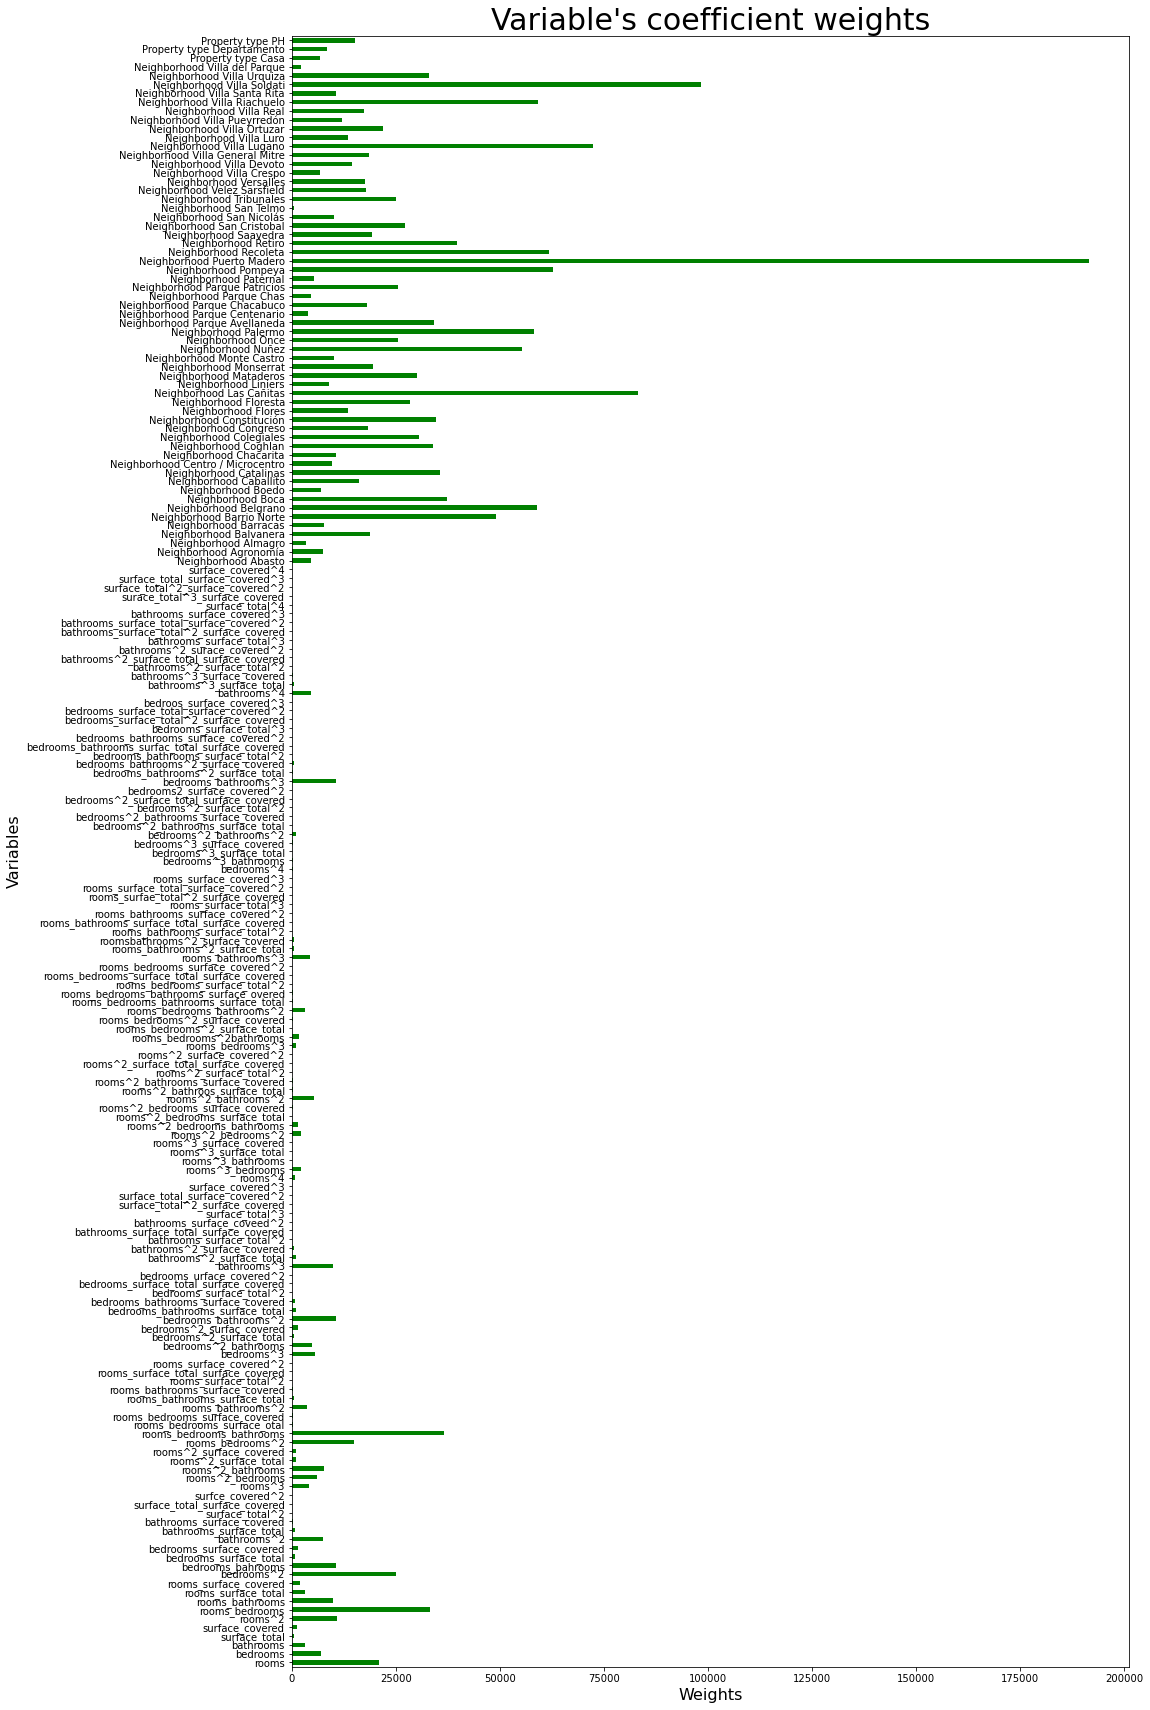

In [97]:
plt.figure(figsize = (15,30))
index = coef_names_gs
ax = np.abs(coef_importance['Coefficients']).plot.barh(color = 'g')
plt.xlabel('Weights', fontsize = 16)
plt.ylabel('Variables', fontsize = 16)
plt.title("Variable's coefficient weights", fontsize = 30)
plt.show()

De lo anterior, se sigue que las variables que más peso tienen en esta regresión son nuevamente <i><b>Neighborhood Puerto Madero</b></i>, <i><b>Neighborhood Villa Soldati</b></i> y <i><b>Neighborhood Las Cañitas</b></i>.

Veamos cuáles son sus coeficientes.

In [98]:
print(coef_importance.loc['Neighborhood Puerto Madero'], '\n')
print(coef_importance.loc['Neighborhood Villa Soldati'], '\n')
print(coef_importance.loc['Neighborhood Las Cañitas'])

Coefficients    191581.206146
Name: Neighborhood Puerto Madero, dtype: float64 

Coefficients   -98439.005661
Name: Neighborhood Villa Soldati, dtype: float64 

Coefficients    83202.633081
Name: Neighborhood Las Cañitas, dtype: float64


Como en las regularizaciones anteriores, conforme el valor de las variables <i><b>Neighborhood Puerto Madero</b></i> y <i><b>Neighborhood Las Cañitas</b></i> tiendan a crecer, el promedio de nuestra variable objetivo, <i><b>price</b></i>, también tiende a crecer, mientras que conforme la variable <i><b>Neighborhood Villa Soldati</b></i> tiende a crecer, nuestra variable objetivo tiende a decrecer.

Evaluamos nuestro modelo.

Root Mean Squared Error in Train: 45488.584914008745
Root Mean Squared Error in Test: 45288.73391408211


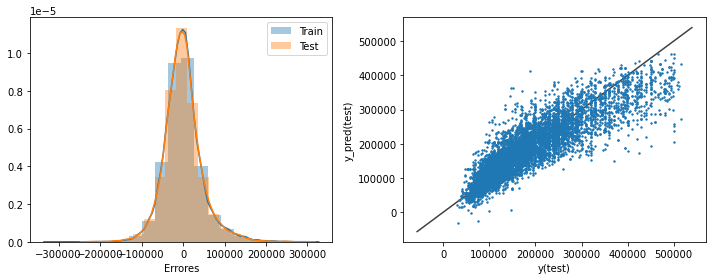

In [99]:
evaluate_model(reg_ridge_gs, X_train_p, X_test_p, y_train, y_test)

Nuestra métrica, nuevamente, mejora de forma ligera respecto al mejor <i>score</i> obtenido del `cv` del <b>GridSearchCV</b> y es prácticamente la misma que obtuvimos con `lin_reg_gs`.

Veamos ahora qué ocurre con `Lasso` con sus hiperparámetros seleccionados mediante <b>GridSearch</b>.

In [100]:
reg_lasso_gs = Lasso()
param_grid_l = {'alpha': [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]}
grid_l = GridSearchCV(estimator = reg_lasso_gs, param_grid = param_grid_l, cv = 5)

In [101]:
%%time

grid_l.fit(X_train_p, y_train)

CPU times: user 32min 51s, sys: 2.58 s, total: 32min 54s
Wall time: 4min 7s


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01]})

Imprimimos en pantalla los mejores parámetros.

In [102]:
print('Best parameters: ' + str(grid_l.best_params_) + '\n')
print('Best Score: ' + str(abs(lin_reg_gs_grid.best_score_)))

Best parameters: {'alpha': 5e-05}

Best Score: 45821.40176490902


Entrenamos al modelo con el mejor parámetro.

In [103]:
reg_lasso_gs = Lasso(alpha = grid_l.best_params_['alpha'])
reg_lasso_gs.fit(X_train_p, y_train)

coef_reg_lasso_gs = list(reg_lasso_gs.coef_.flatten())
print('Coefficients:', coef_reg_lasso_gs, '\n')
print(f'Intercept: {reg_lasso_gs.intercept_}')

Coefficients: [15515.959256570932, 23274.74317062949, 49715.67951563725, 593.8303432350591, 839.7125965846121, -4508.9141699486345, -3861.8475371193886, 2396.8337731579036, 353.3291927955991, -190.0827018586795, -6893.862977415643, -1403.998002920963, 462.9072146376709, -237.18724852967523, -11449.012352569318, 139.9107932814724, -18.584165695349988, -8.87857901258772, 3.1541933244187983, 6.249471416062798, 382.5996772177131, -223.7352305712997, -942.3999709709514, 15.785222490031746, -16.342135325497203, 1303.5777588319613, -3177.75858764769, 17.7969199812768, -23.096135142213388, 1624.776276404684, 51.07200511470413, -33.20507259996779, -0.3295783202683759, 0.46790465021452815, -0.09501404955079357, 1087.4491891996358, -3338.5787952520586, 12.141890317600584, -36.29107760151126, 2074.008768434544, 75.8826448130172, -30.8464579173716, -0.5545841428563298, 1.0145936726472806, -0.3034586432598603, -157.2349320772454, 37.24980426860208, -51.322709850763914, -1.3208876981522144, -0.036024

**- Análisis del peso de las variables**

In [104]:
coef_importance = pd.DataFrame()
index_ = coef_names_gs
coef_importance['Coefficients'] = coef_reg_lasso_gs
coef_importance.index = index_
coef_importance

Coefficients
rooms                          15515.959257
bedrooms                       23274.743171
bathrooms                      49715.679516
surface_total                    593.830343
surface_covered                  839.712597
...                                     ...
Neighborhood Villa Urquiza     13889.449475
Neighborhood Villa del Parque -17315.631828
Property type Casa             22013.258208
Property type Departamento     22788.757482
Property type PH               -2927.559309

[185 rows x 1 columns]

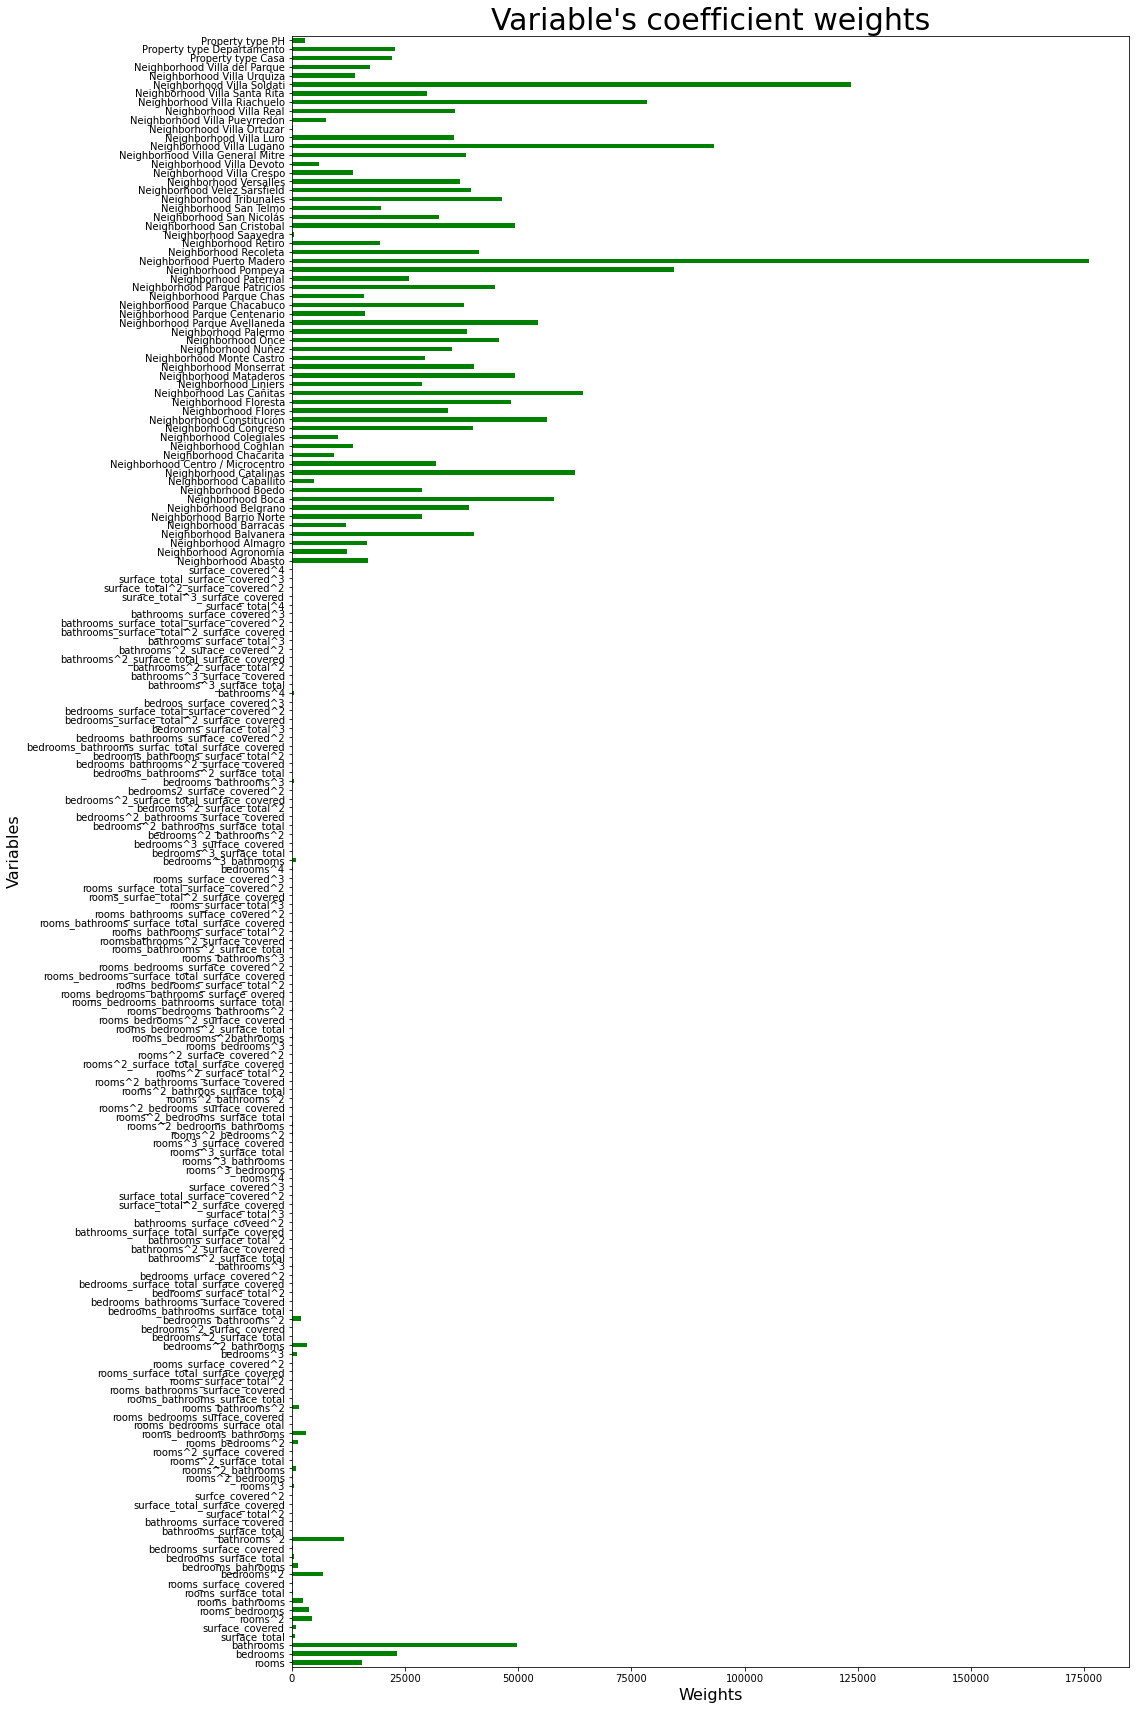

In [105]:
plt.figure(figsize = (15,30))
index = coef_names_gs
ax = np.abs(coef_importance['Coefficients']).plot.barh(color = 'g')
plt.xlabel('Weights', fontsize = 16)
plt.ylabel('Variables', fontsize = 16)
plt.title("Variable's coefficient weights", fontsize = 30)
plt.show()

De lo anterior, se sigue que las variables que más peso tienen en esta regresión son nuevamente <i><b>Neighborhood Puerto Madero</b></i>, <i><b>Neighborhood Villa Soldati</b></i> y <i><b>Neighborhood Villa Lugano</b></i>.

Veamos cuáles son sus coeficientes.

In [106]:
print(coef_importance.loc['Neighborhood Puerto Madero'], '\n')
print(coef_importance.loc['Neighborhood Villa Soldati'], '\n')
print(coef_importance.loc['Neighborhood Villa Lugano'])

Coefficients    176041.872582
Name: Neighborhood Puerto Madero, dtype: float64 

Coefficients   -123529.77928
Name: Neighborhood Villa Soldati, dtype: float64 

Coefficients   -93290.693551
Name: Neighborhood Villa Lugano, dtype: float64


Vemos que conforme el valor de la variable <i><b>Neighborhood Puerto Madero</b></i> tiende a crecer, el promedio de nuestra variable objetivo, <i><b>price</b></i>, también tiende a crecer, mientras que conforme las variables <i><b>Neighborhood Villa Soldati</b></i> y <i><b>Neighborhood Villa Lugano</b></i> tienden a crecer, nuestra variable objetivo tiende a decrecer.

Evaluamos nuestro modelo.

Root Mean Squared Error in Train: 46066.010478960656
Root Mean Squared Error in Test: 45611.108221380135


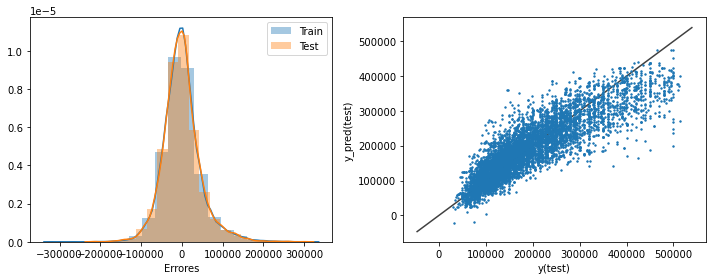

In [107]:
evaluate_model(reg_lasso_gs, X_train_p, X_test_p, y_train, y_test)

La métrica respecto al mejor <i>score</i> obtenido del `cv` del <b>GridSearchCV</b> mejora ligeramente. Sin embargo, empeora levemente respecto a `reg_ridge_gs`.

**- Conclusiones**

El modelo que mejor optimizó nuestra métrica fue `reg_ridge_gs`. Aun así, la mejora no es significativa respecto a `lin_reg`.

En estos casos en los que los hiperparámetros de los modelos fueron optimizados sí se aprecia el efecto de las regularizaciones al destacar a las varibles que realmente tienen peso, en contraste con `lin_reg_gs`. Sin embargo, `reg_ridge_gs` y `lin_reg` consideran a las mismas variables como las de mayor peso y sus coeficientes son similares, por lo que no se aprecia la ventaja de la regularización de este primero sobre el último.

De los modelos hasta ahora considerados, se cree que el más óptimo es `lin_reg`.

### b) Ensamble de Árboles (XGboost)

Para esta parte, transformaremos ligeramente los nombres de algunas de nuestras variables en el <i>DataFrame</i>, para poder generar árboles independientes de cada modelo de `XGboost`. Hagámoslo y veamos los últmos cinco registros del mismo.

In [108]:
data_xgb_gs = df_extended.copy()
data_xgb_gs.columns = data_xgb_gs.columns.str.replace(" ", "_")
data_xgb_gs.tail()

rooms  bedrooms     price  bathrooms  surface_total  surface_covered  \
79932    3.0       2.0  475000.0        2.0           82.0             82.0   
79933    3.0       2.0  178000.0        1.0           84.0             84.0   
79934    5.0       2.0  298000.0        2.0          114.0             95.0   
79935    3.0       2.0  480000.0        2.0          144.0            134.0   
79936    3.0       2.0  420000.0        2.0          145.0            145.0   

       Neighborhood_Abasto  Neighborhood_Agronomía  Neighborhood_Almagro  \
79932                    0                       0                     0   
79933                    0                       0                     0   
79934                    0                       0                     0   
79935                    0                       0                     0   
79936                    0                       0                     0   

       Neighborhood_Balvanera  ...  Neighborhood_Villa_Pueyrredón  \
79932                       0  ...                              0   
79933                       0  ...                              0   
79934                       0  ...                              0   
79935                       0  ...                              0   
79936                       0  ...                              0   

       Neighborhood_Villa_Real  Neighborhood_Villa_Riachuelo  \
79932                        0                             0   
79933                        0                             0   
79934                        0                             0   
79935                        0                             0   
79936                        0                             0   

       Neighborhood_Villa_Santa_Rita  Neighborhood_Villa_Soldati  \
79932                              0                           0   
79933                              0                           0   
79934                              0                           0   
79935                              0                           0   
79936                              0                           0   

       Neighborhood_Villa_Urquiza  Neighborhood_Villa_del_Parque  \
79932                           0                              0   
79933                           0                              0   
79934                           0                              0   
79935                           0                              0   
79936                           0                              0   

       Property_type_Casa  Property_type_Departamento  Property_type_PH  
79932                   0                           1                 0  
79933                   0                           0                 1  
79934                   0                           0                 1  
79935                   0                           0                 1  
79936                   0                           1                 0  

[5 rows x 66 columns]

Hecho lo anterior, nuevamente definimos nuestras variables independientes y nuestra variable objetivo.

In [109]:
X = data_xgb_gs.drop('price', axis = 1)
y = data_xgb_gs['price']

Dividimos nuestros datos en aquellos de prueba y aquellos de entrenamiento.

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)

Y ahora sí, definimos nuestro modelo con sus valores por defecto.

In [111]:
model_xgb = XGBRegressor(objective = 'reg:squarederror')

Ahora, hacemos `cross_val_score` e imprimimos nuestra métrica promedio con su desviación estándard promedio así como las 5 métricas obtenidas.

In [112]:
cv_xgb = abs(cross_val_score(model_xgb, X_train, y_train, cv = 5,
                            scoring = 'neg_root_mean_squared_error'))
print('The average RMSE and its standard deviation is:', abs(cv_xgb.mean()), '±',
      (abs(cv_xgb.std())), '\n')
print('The 5 RMSE are:', *cv_xgb)

The average RMSE and its standard deviation is: 46136.328721154554 ± 423.972241299817 

The 5 RMSE are: 46289.79915411107 46573.515692793066 45550.1098481292 45721.547782628986 46546.671128110465


Procedemos a entrenar al modelo.

In [113]:
model_xgb.fit(X_train, y_train)

XGBRegressor(objective='reg:squarederror')

Mediante `plot_importance` veremos el peso de las 10 variables que más aportan a este modelo.

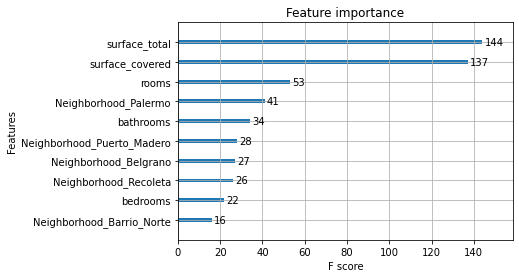

In [114]:
plot_importance(model_xgb, max_num_features = 10)
plt.show()

Del gráfico anterior se sigue que las variables más importantes para este modelo fueron <i><b>surface_total</b></i>, <i><b>surface_covered</b></i> y <i><b>rooms</b></i>.

Y ahora, evaluamos nuestro modelo para ver su desempeño.

Root Mean Squared Error in Train: 45889.52545109012
Root Mean Squared Error in Test: 45402.86312371665


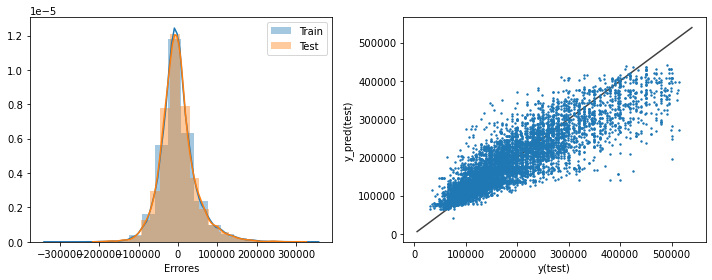

In [115]:
evaluate_model(model_xgb, X_train, X_test, y_train, y_test)

Este modelo tiene, en términos de optimización de la métrica, un mejor desempeño que cualquiera de los de Regresión Lineal. Además, es prácticamente igual de rápido de obtener que una regularización lineal.

Veamos si esta situación mejora aún más al optimizar sus hiperparámetros.

### - Optimización de hiperparámetros

Comenzamos definiendo nuevamente nuestro modelo.

In [116]:
model_xgb_gs_l2 = XGBRegressor(objective = 'reg:squarederror')

Definamos los parámetros que queremos optimizar. Para ello, debemos tener en cuenta que tenemos que entrenar dos modelos; a saber, uno que considere el hiperparámetro `lambda` ignorando el hiperparámetro `alpha` y viceversa, para obtener correctamente lo que serían las regularizaciones `L2` y `L1`, respectivamente. Esta metodología se estableció durante las sesiones con nuestro mentor.

Así pues, procedamos a definir los parámetros a optimizar de nuestro primer modelo.

In [117]:
param_grid_l2 = {'eta': [.2, .3, .4], 'lambda': [.01, .1, 1], 'subsample': [.3, .5, .7],
                'max_leaves': [0, 1, 2], 'num_parallel_tree': [1, 2, 3], 'gamma': [0, 10, 20],
                'max_depth': [5, 6, 7]}

random_xgb_l2 = RandomizedSearchCV(estimator = model_xgb_gs_l2,
                                   param_distributions = param_grid_l2,
                                   scoring = 'neg_root_mean_squared_error', random_state = 0, 
                                   n_iter = 100, cv = 5)

**Obs:** originalmente se intentó una grilla más robusta, es decir, con más parámetros que se considera pueden tener un impacto relevante en el desempeño del modelo así como rangos un poco más amplios. Sin embargo, después de más de 8 horas la máquina no terminó de entrenar al modelo, aun cambiando de <b>GridSearchCV</b> a <b>RandomizedSearchCV</b>. De ahí que el método que se utilizó es este último, pero con parámetros y rangos más restringidos. Sobre esto último, en aquellos casos en los que los parámetros seleccionados toman valores por defecto, digamos <i>k</i>, se decidió probar con valores alrededor de <i>k</i> y <i>k</i> mismo.

Procedemos a entrenar a `random_xgb_l2`.

In [118]:
%%time

random_xgb_l2.fit(X_train, y_train)

CPU times: user 4h 29min 31s, sys: 12.3 s, total: 4h 29min 43s
Wall time: 4h 29min 43s


RandomizedSearchCV(cv=5, estimator=XGBRegressor(objective='reg:squarederror'),
                   n_iter=100,
                   param_distributions={'eta': [0.2, 0.3, 0.4],
                                        'gamma': [0, 10, 20],
                                        'lambda': [0.01, 0.1, 1],
                                        'max_depth': [5, 6, 7],
                                        'max_leaves': [0, 1, 2],
                                        'num_parallel_tree': [1, 2, 3],
                                        'subsample': [0.3, 0.5, 0.7]},
                   random_state=0, scoring='neg_root_mean_squared_error')

Imprimimos en pantalla los mejores parámetros.

In [119]:
print('Best parameters: ' + str(random_xgb_l2.best_params_))

Best parameters: {'subsample': 0.5, 'num_parallel_tree': 2, 'max_leaves': 2, 'max_depth': 7, 'lambda': 0.1, 'gamma': 10, 'eta': 0.3}


Ahora, entrenamos a nuestro modelo con estos parámetros.

In [120]:
model_xgb_gs_l2 = XGBRegressor(objective = 'reg:squarederror',
                            eta = random_xgb_l2.best_params_['eta'],
                            gamma = random_xgb_l2.best_params_['gamma'],
                            reg_lambda = random_xgb_l2.best_params_['lambda'],
                            max_depth = random_xgb_l2.best_params_['max_depth'],
                            num_parallel_tree =
                                            random_xgb_l2.best_params_['num_parallel_tree'],
                            subsample = random_xgb_l2.best_params_['subsample'])

model_xgb_gs_l2.fit(X_train, y_train)

XGBRegressor(eta=0.3, gamma=10, max_depth=7, num_parallel_tree=2,
             objective='reg:squarederror', reg_lambda=0.1, subsample=0.5)

Ahora, mediante `plot_importance` veremos el peso de las 10 variables que más aportan a este modelo.

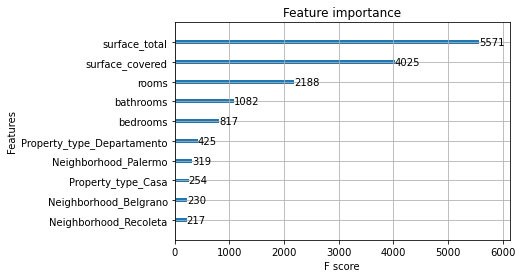

In [121]:
plot_importance(model_xgb_gs_l2, max_num_features = 10)
plt.show()

De lo anterior claramente de desprende que `surface_total` y `surface_covered` y `rooms` son nuestras variables más relevantes para este modelo. Respecto a `model_xgb` la importancia de las primeras dos variables es más acentuada.

Finalmente, evaluamos nuestro modelo.

Root Mean Squared Error in Train: 38561.053940287646
Root Mean Squared Error in Test: 39351.773803645636


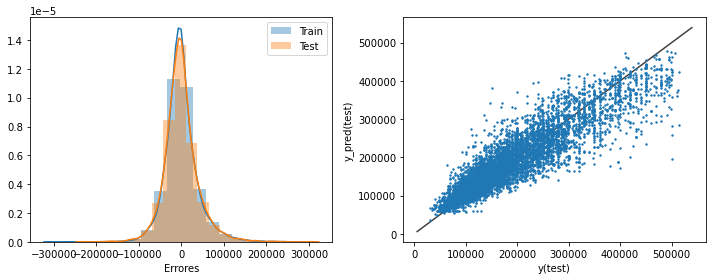

In [122]:
evaluate_model(model_xgb_gs_l2, X_train, X_test, y_train, y_test)

La métrica mejora sensiblemente respecto a `model_xgb`.

Ahora, definamos a nuestro próximo modelo y los parámetros a utilizar (que serán los mismos que en el anterior, excepto que haremos el parámetro `lambda = 0`, pues por defecto es igual a 1, y probaremos valores para el hiperparámetro `alpha`).

In [123]:
model_xgb_gs_l1 = XGBRegressor(objective = 'reg:squarederror')

In [124]:
param_grid_l1 = {'eta': [.2, .3, .4], 'lambda': [0], 'alpha': [.001, .005, .01, .05, .1, .5, 1],
                 'subsample': [.3, .5, .7], 'max_leaves': [0, 1, 2],
                 'num_parallel_tree': [1, 2, 3], 'gamma': [0, 10, 20], 'max_depth': [5, 6, 7]}

random_xgb_l1 = RandomizedSearchCV(estimator = model_xgb_gs_l1,
                                   param_distributions = param_grid_l1,
                                   scoring = 'neg_root_mean_squared_error', random_state = 0, 
                                   n_iter = 100, cv = 5)

In [125]:
%%time

random_xgb_l1.fit(X_train, y_train)

CPU times: user 4h 25min 43s, sys: 12.3 s, total: 4h 25min 55s
Wall time: 4h 25min 55s


RandomizedSearchCV(cv=5, estimator=XGBRegressor(objective='reg:squarederror'),
                   n_iter=100,
                   param_distributions={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1,
                                                  0.5, 1],
                                        'eta': [0.2, 0.3, 0.4],
                                        'gamma': [0, 10, 20], 'lambda': [0],
                                        'max_depth': [5, 6, 7],
                                        'max_leaves': [0, 1, 2],
                                        'num_parallel_tree': [1, 2, 3],
                                        'subsample': [0.3, 0.5, 0.7]},
                   random_state=0, scoring='neg_root_mean_squared_error')

Imprimimos en pantalla los mejores parámetros.

In [126]:
print('Best parameters: ' + str(random_xgb_l1.best_params_))

Best parameters: {'subsample': 0.5, 'num_parallel_tree': 2, 'max_leaves': 1, 'max_depth': 7, 'lambda': 0, 'gamma': 10, 'eta': 0.2, 'alpha': 0.001}


Ahora, entrenamos a nuestro modelo con estos parámetros.

In [127]:
model_xgb_gs_l1 = XGBRegressor(objective = 'reg:squarederror',
                            eta = random_xgb_l1.best_params_['eta'],
                            gamma = random_xgb_l1.best_params_['gamma'],
                            reg_lambda = random_xgb_l1.best_params_['lambda'],
                            max_depth = random_xgb_l1.best_params_['max_depth'],
                            num_parallel_tree =
                                            random_xgb_l1.best_params_['num_parallel_tree'],
                            subsample = random_xgb_l1.best_params_['subsample'])

model_xgb_gs_l1.fit(X_train, y_train)

XGBRegressor(eta=0.2, gamma=10, max_depth=7, num_parallel_tree=2,
             objective='reg:squarederror', reg_lambda=0, subsample=0.5)

Veamos ahora el peso de las 10 variables que más aportan a este modelo.

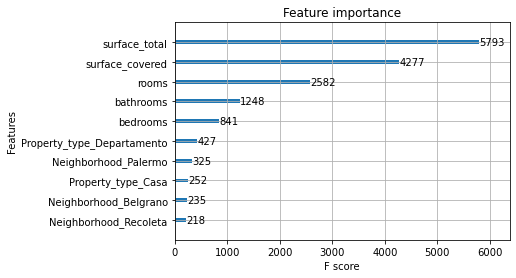

In [128]:
plot_importance(model_xgb_gs_l1, max_num_features = 10)
plt.show()

Como en `model_xgb`, del anterior gráfico se de desprende que <i><b>surface_total</b></i>, <i><b>surface_covered</b></i> y <i><b>rooms</b></i> son nuestras variables más relevantes para el modelo, con similar importancia en ambos.

Evaluamos nuestro modelo.

Root Mean Squared Error in Train: 38538.93807719041
Root Mean Squared Error in Test: 39448.03654772971


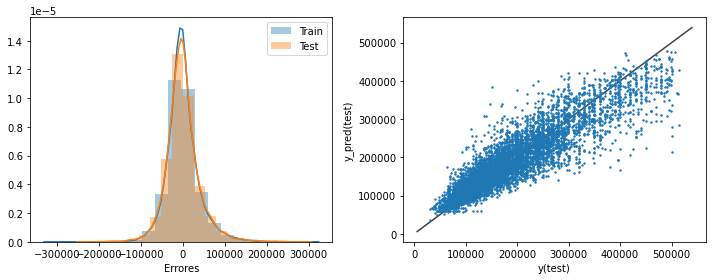

In [129]:
evaluate_model(model_xgb_gs_l1, X_train, X_test, y_train, y_test)

La métrica es ligeramente inferior que en `model_xgb_l2`.

### - Árboles individuales de los modelos de XGboost.

Generaremos tres árboles independientes para cada modelo de `XGboost`, los analizaremos y en la siguiente sección plasmaremos nuestras conclusiones al respecto.

Comenzamos con los tres árboles para `model_xgb`.

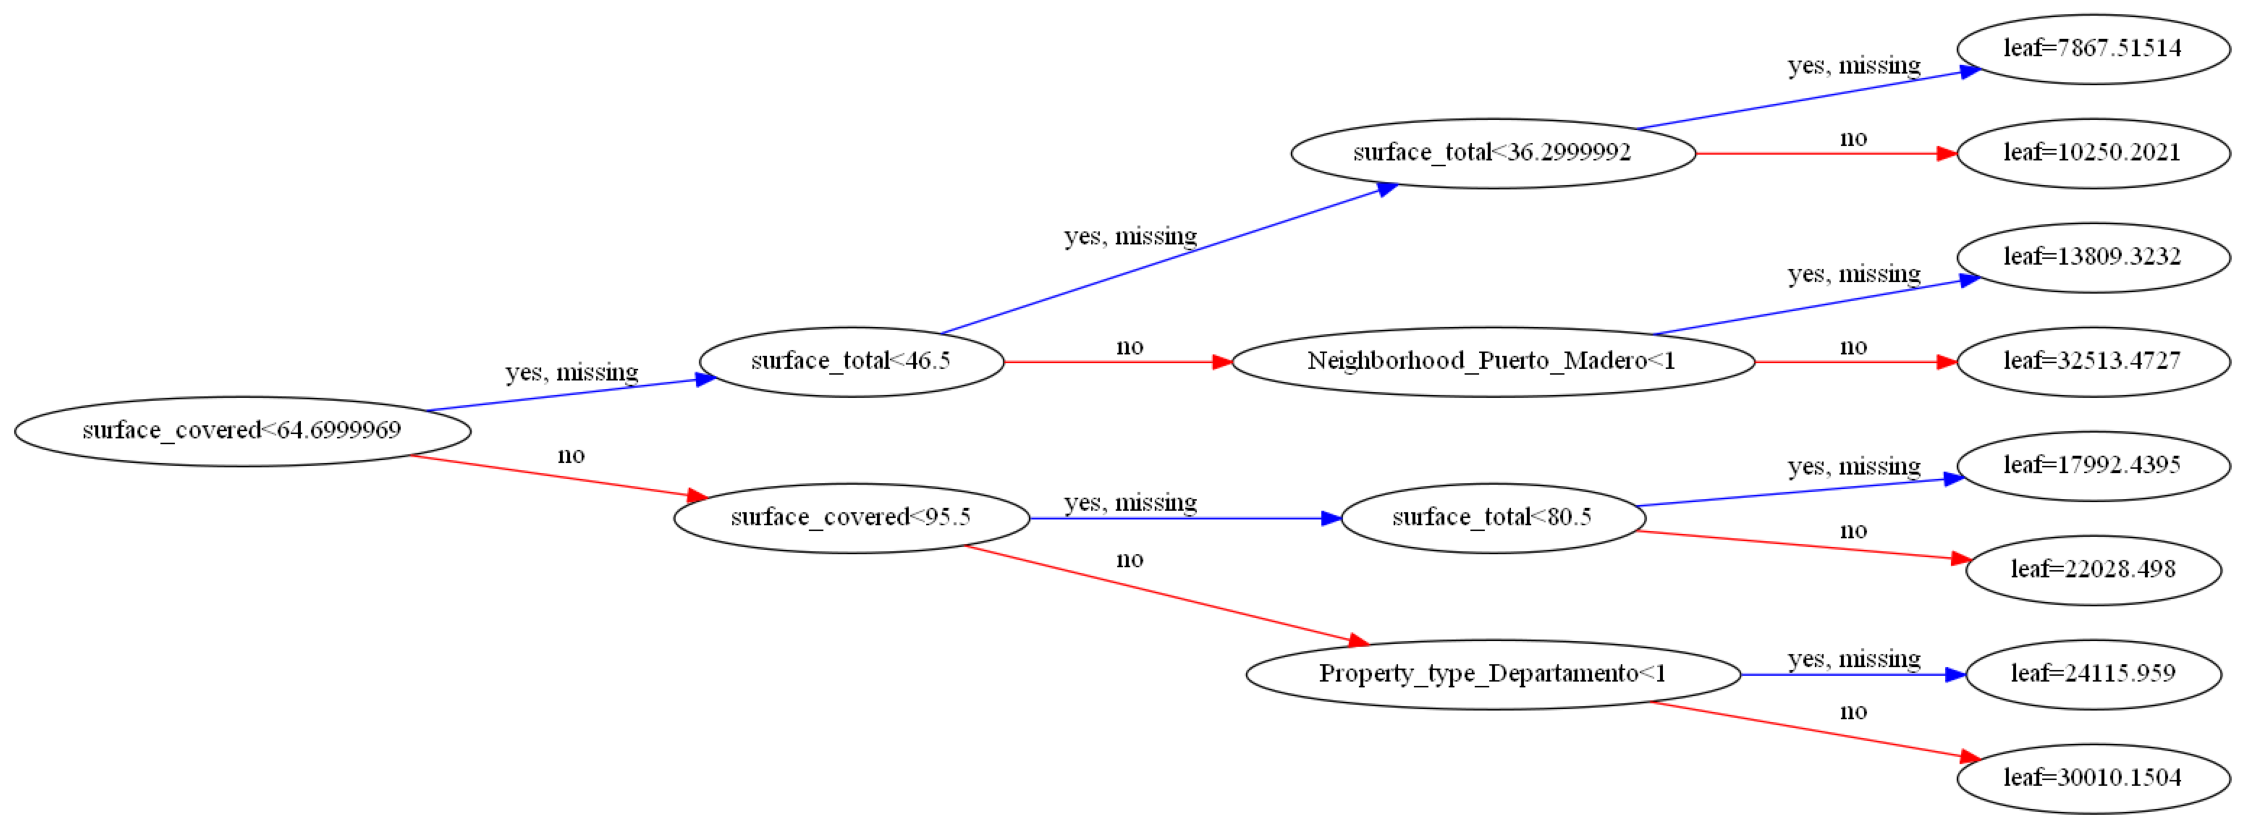

In [132]:
fig, ax = plt.subplots(figsize = (40, 40))
plot_tree(model_xgb, num_trees = 1, ax = ax, rankdir = 'LR')
plt.show()

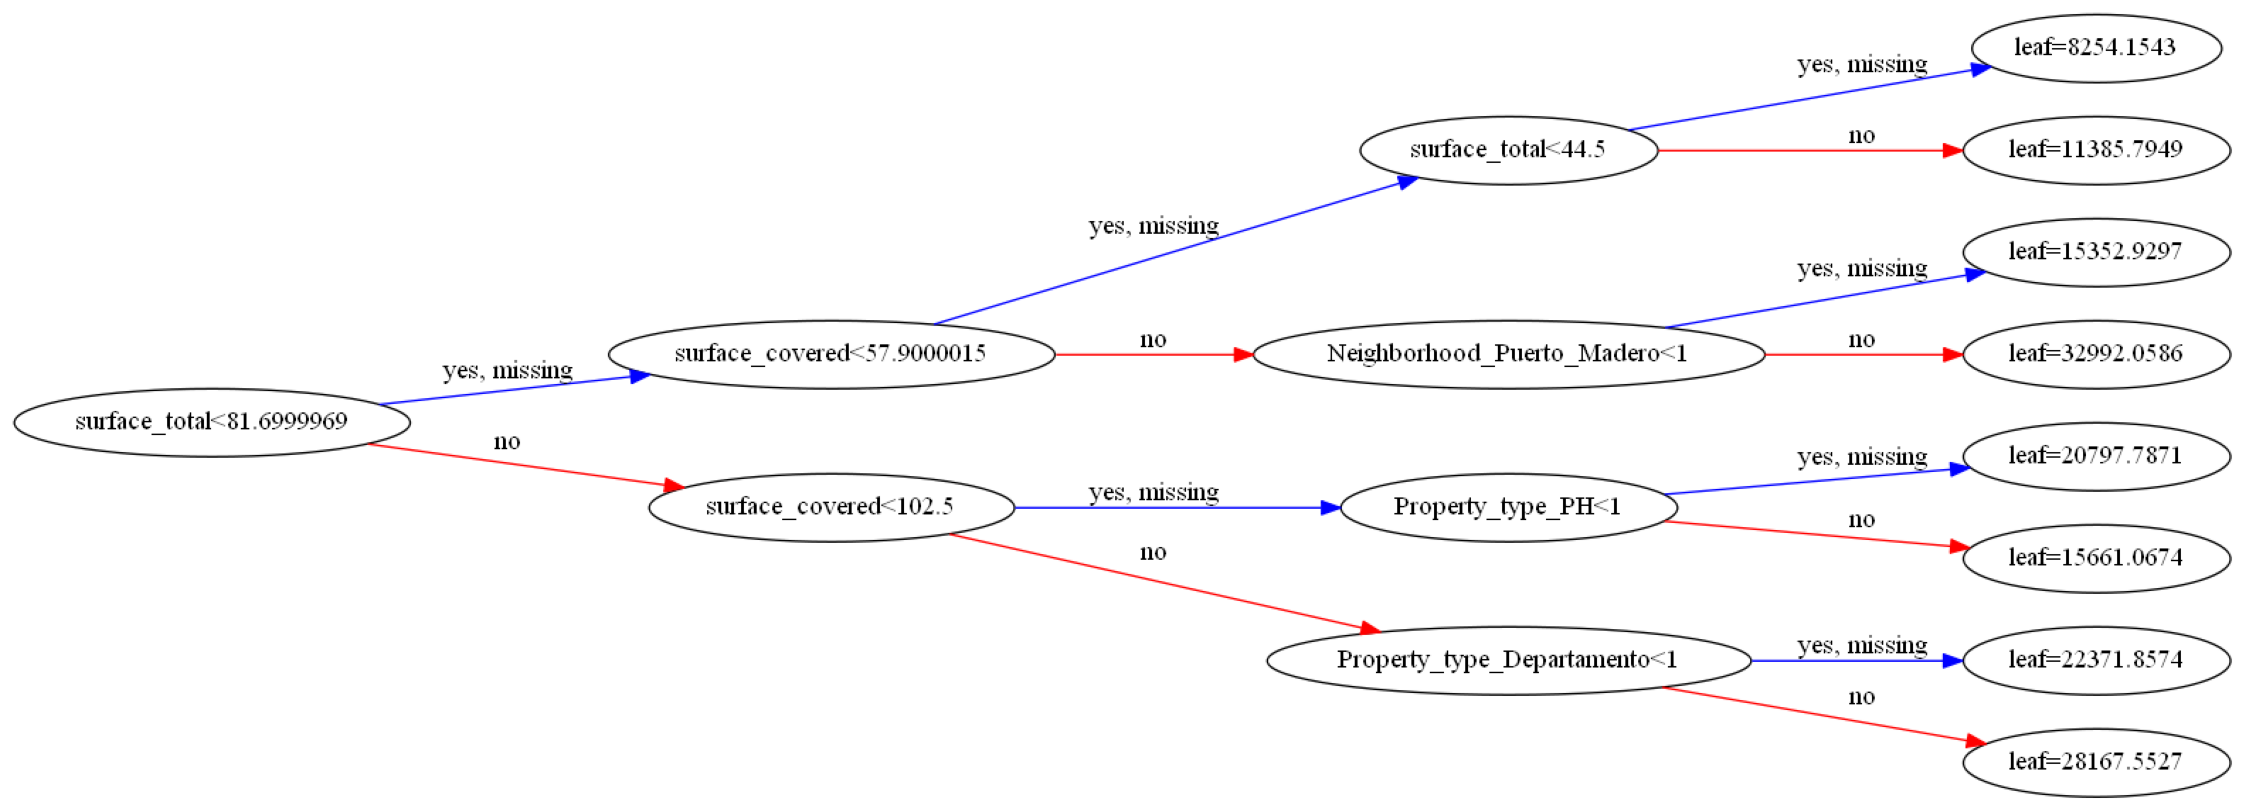

In [133]:
fig, ax = plt.subplots(figsize = (40, 40))
plot_tree(model_xgb, num_trees = 2, ax = ax, rankdir = 'LR')
plt.show()

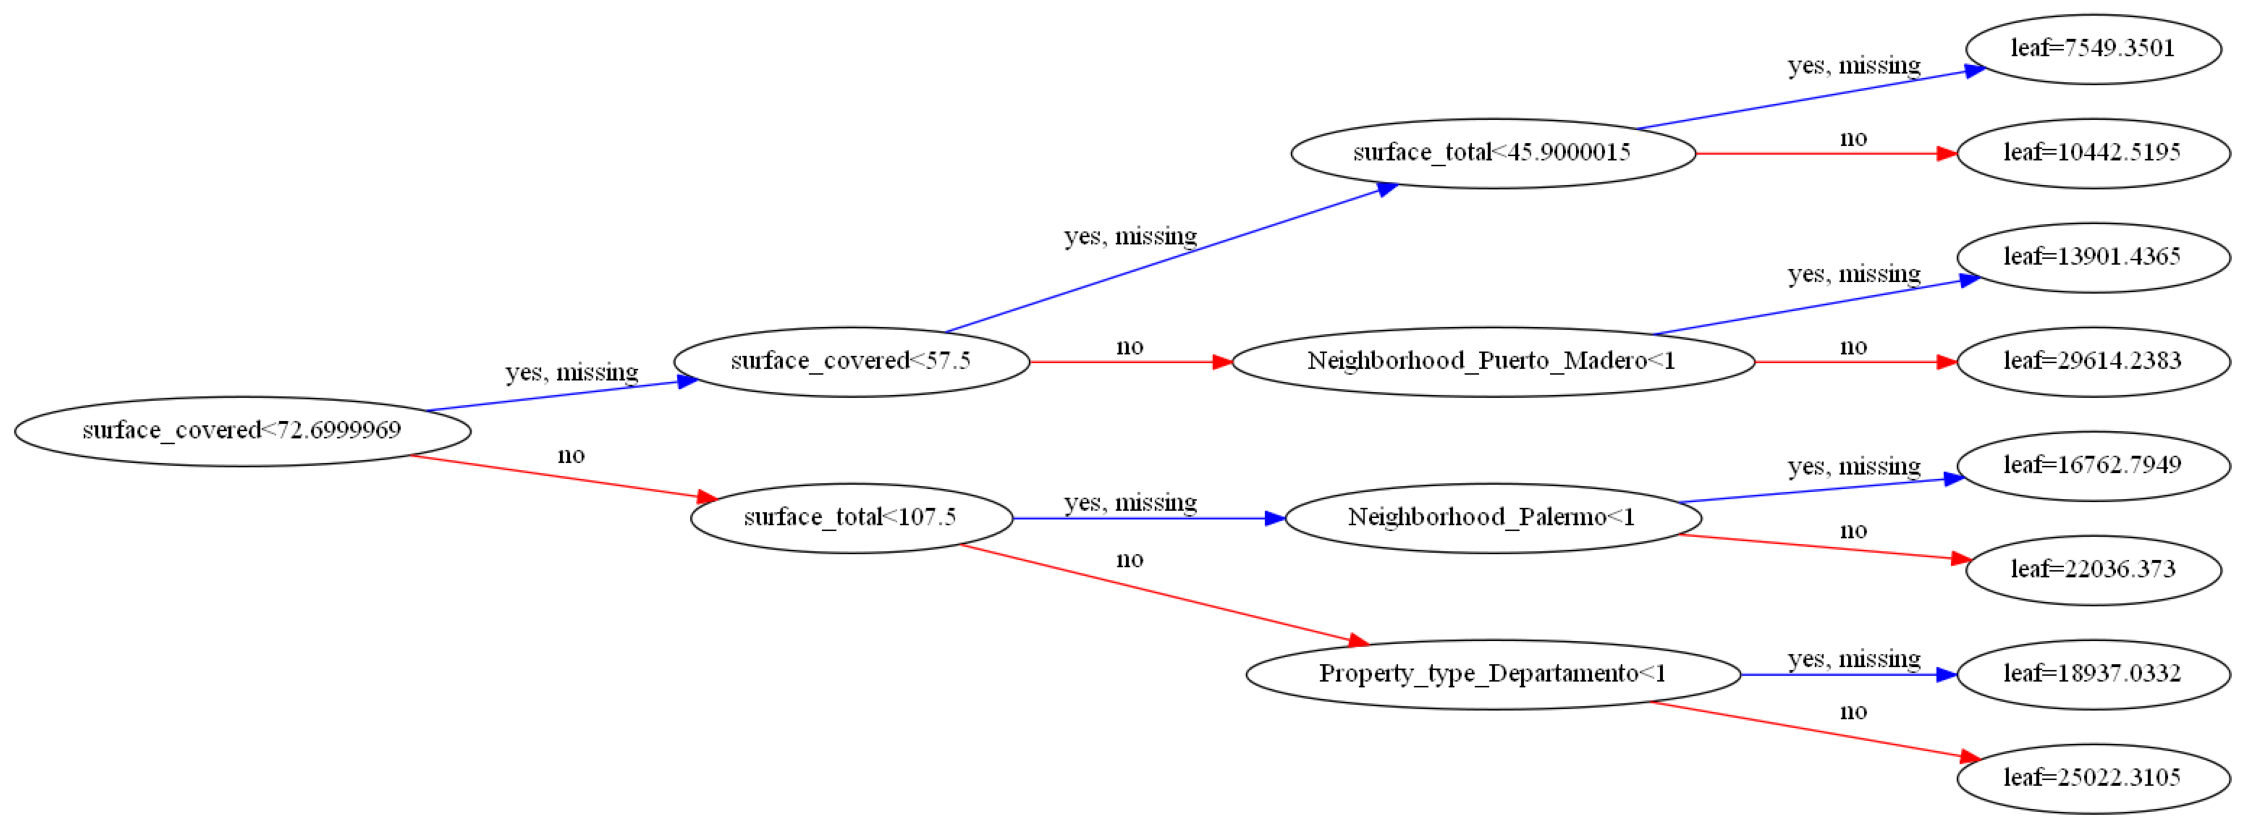

In [134]:
fig, ax = plt.subplots(figsize = (40, 40))
plot_tree(model_xgb, num_trees = 3, ax = ax, rankdir = 'LR')
plt.show()

Pasamos ahora a generar los árboles de `model_xgb_gs_l2`.

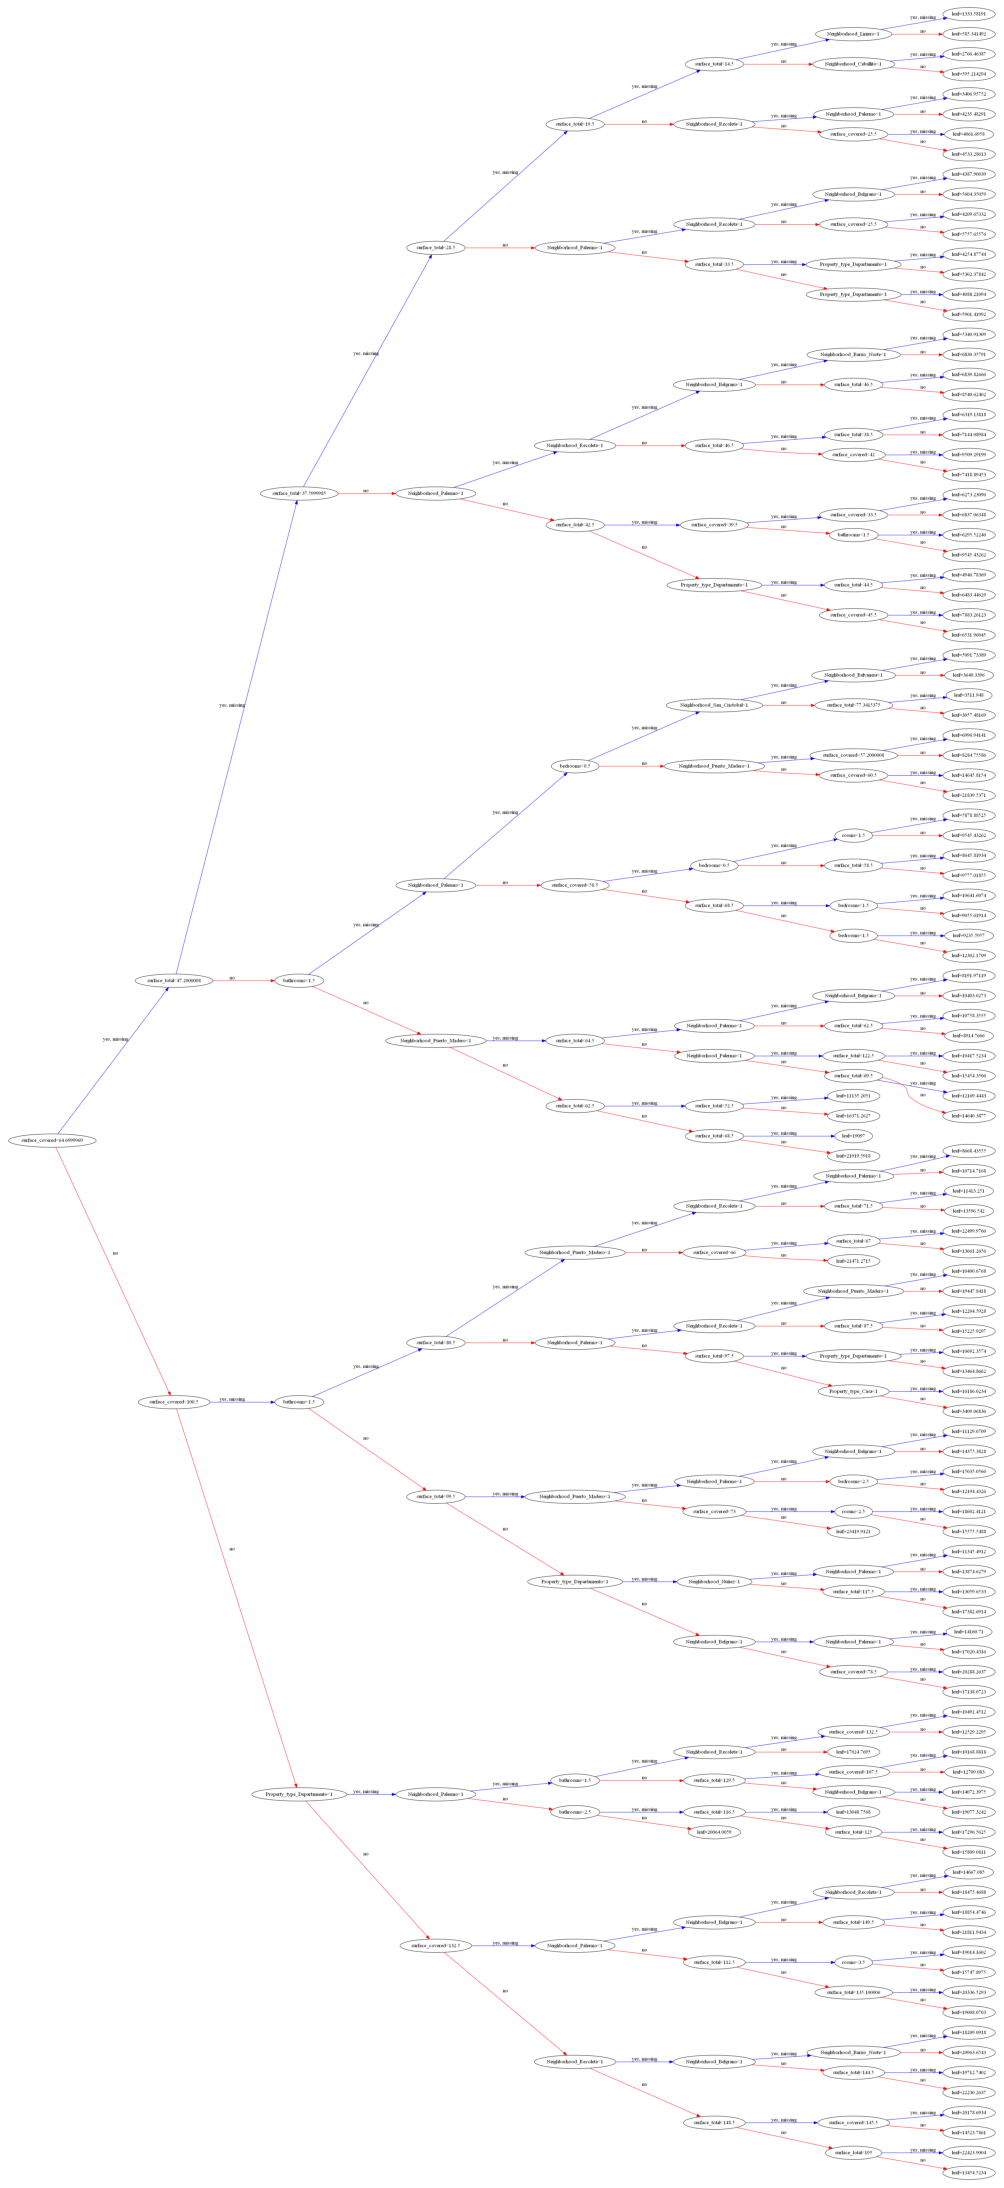

In [138]:
fig, ax = plt.subplots(figsize = (40, 40))
plot_tree(trees_xgb_l2, num_trees = 1, ax = ax, rankdir = 'LR')
plt.show()

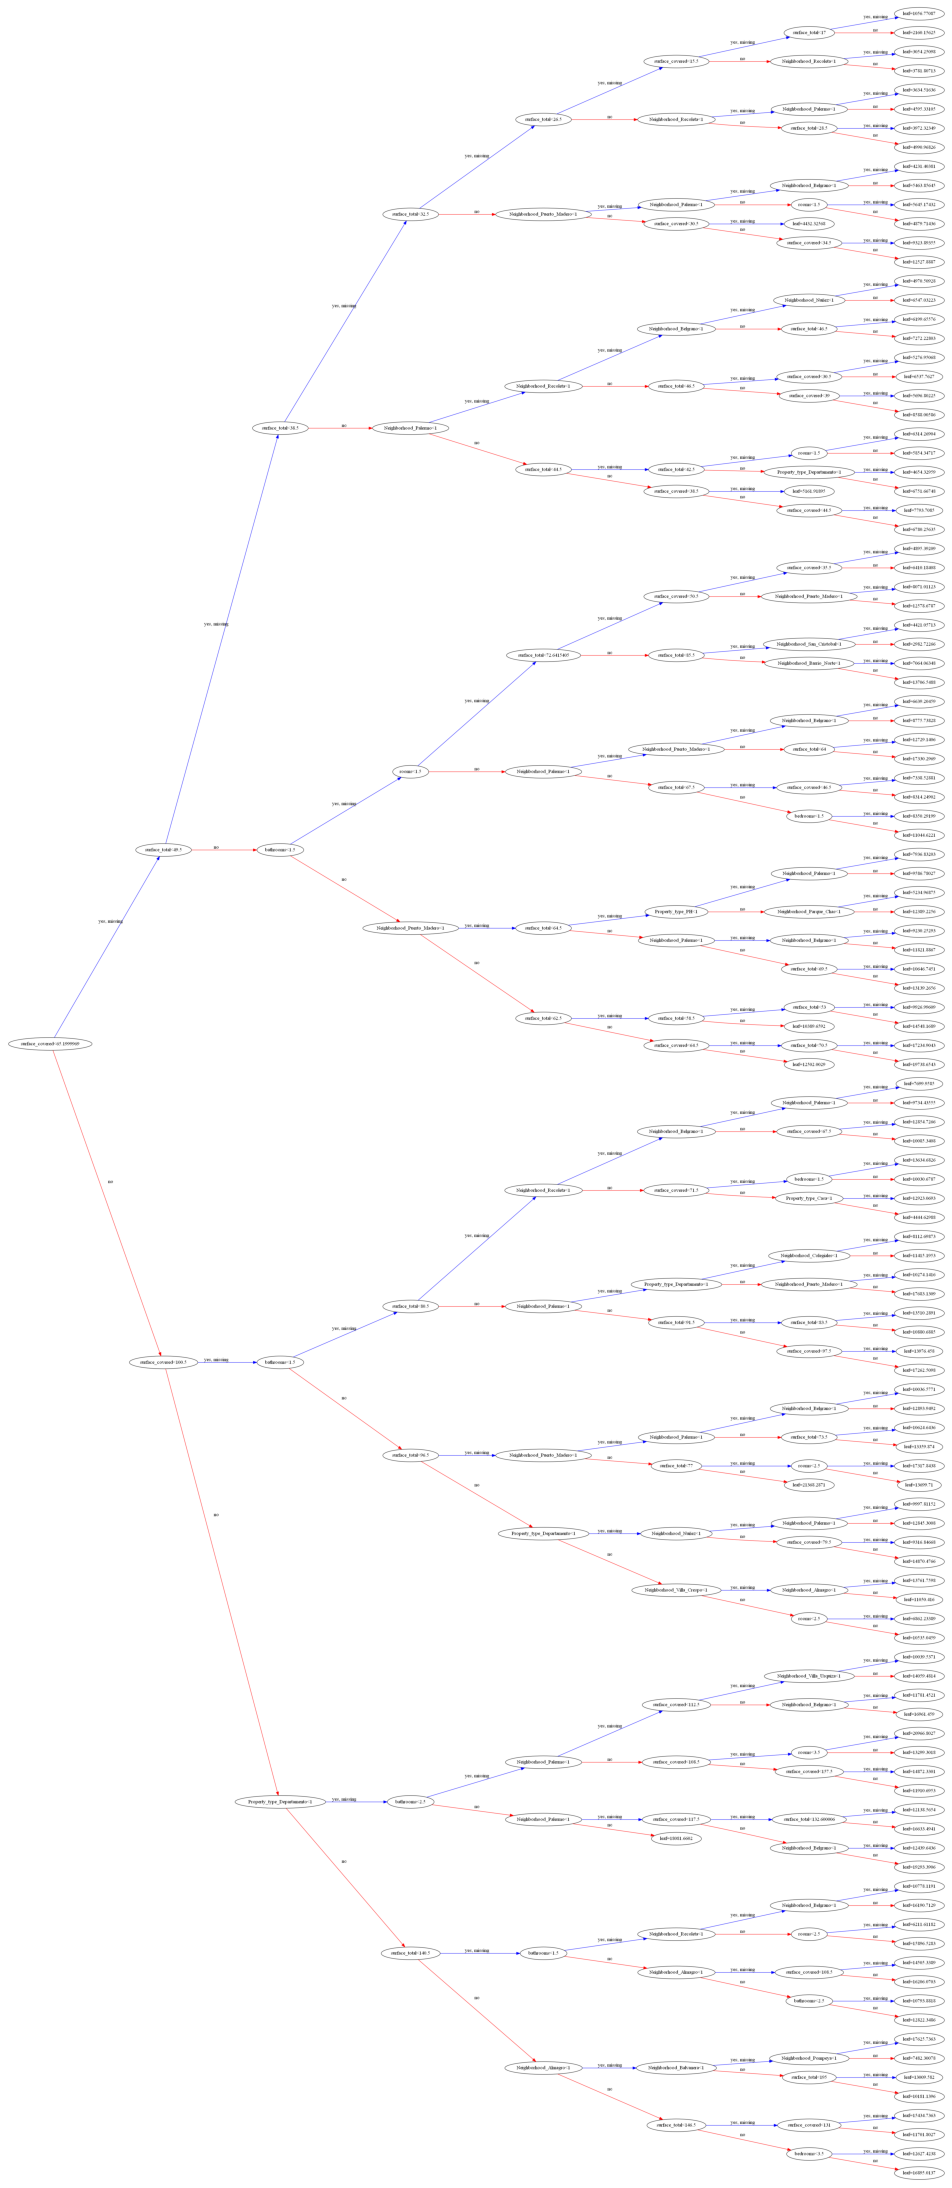

In [139]:
fig, ax = plt.subplots(figsize = (40, 40))
plot_tree(trees_xgb_l2, num_trees = 2, ax = ax, rankdir = 'LR')
plt.show()

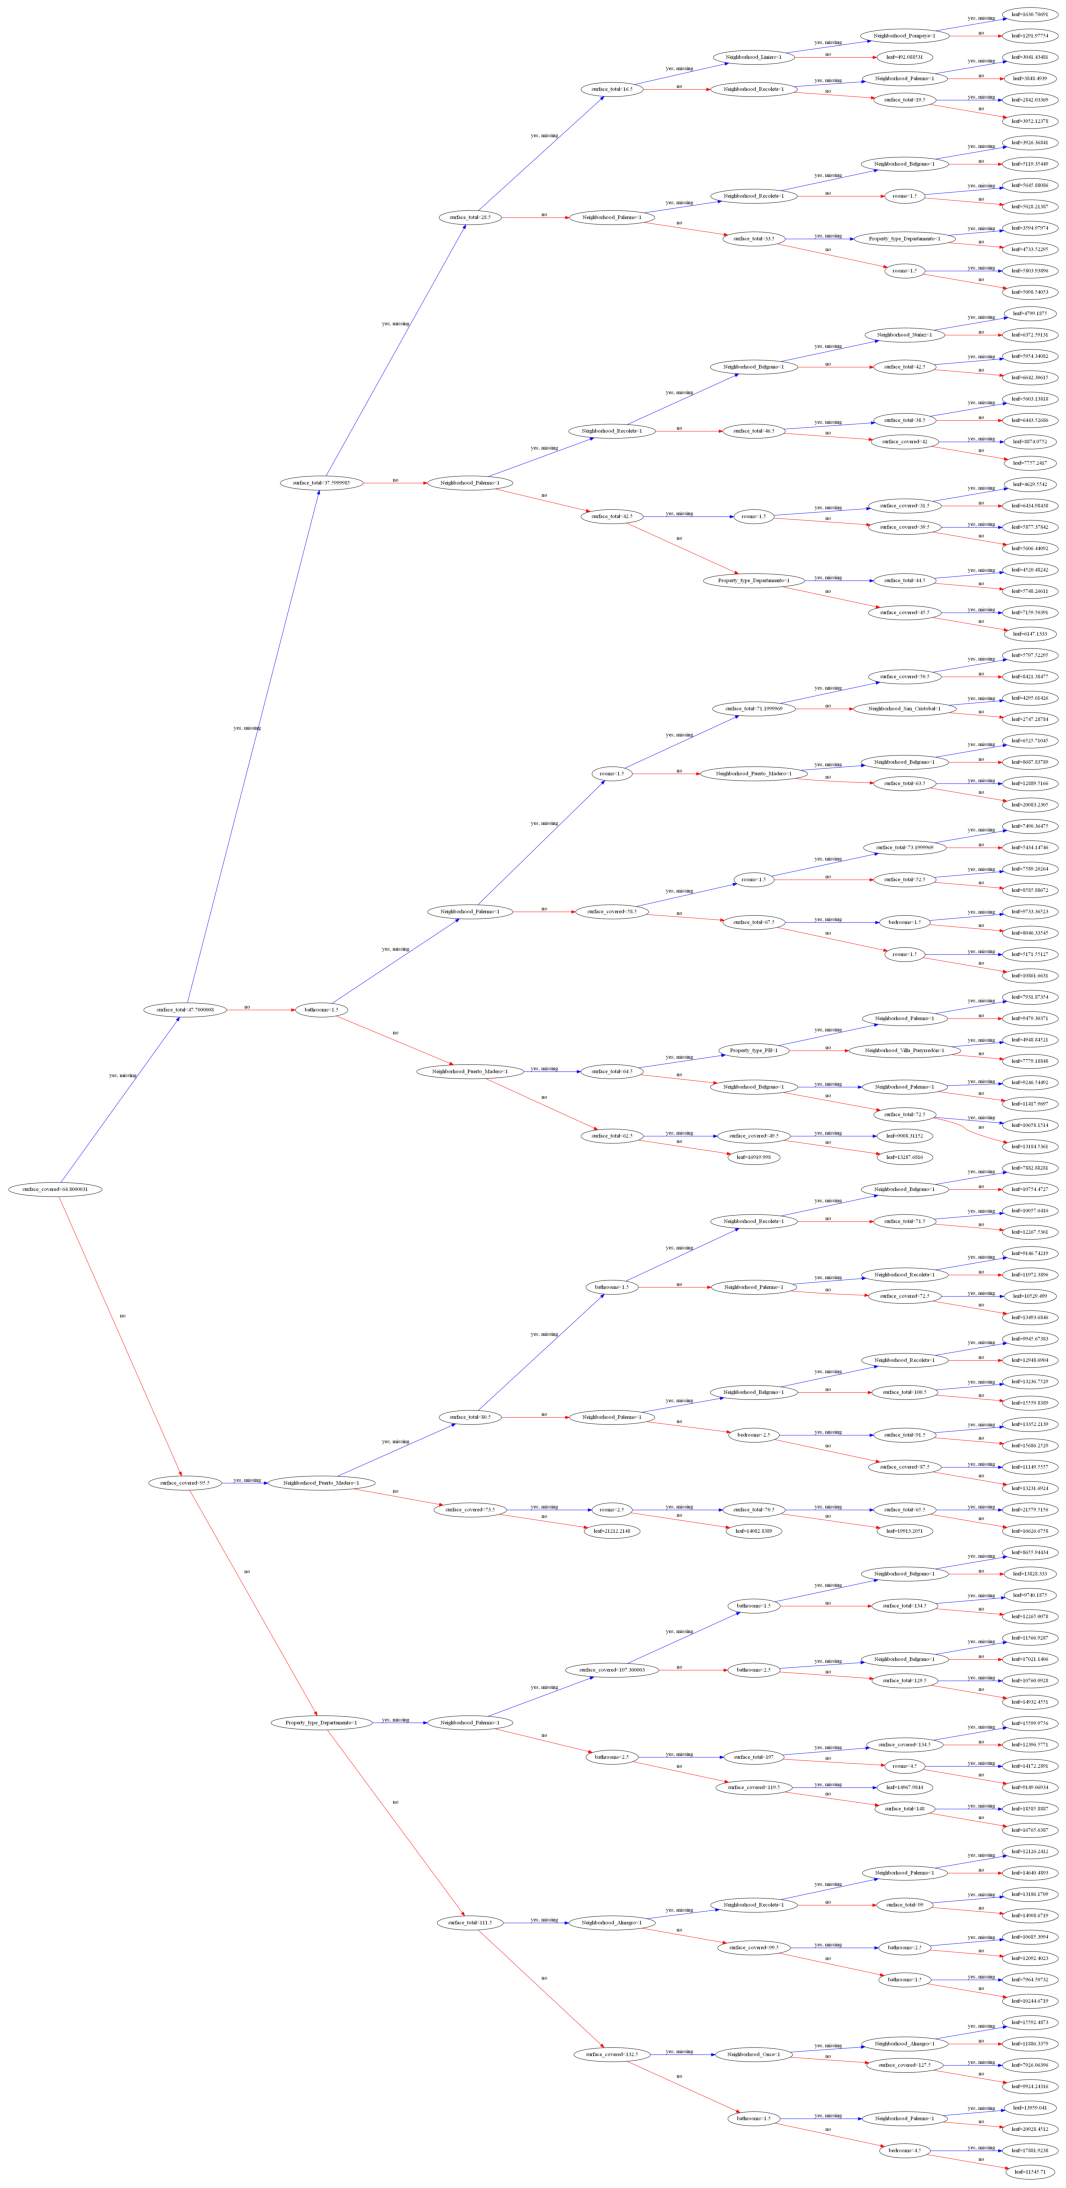

In [140]:
fig, ax = plt.subplots(figsize = (40, 40))
plot_tree(trees_xgb_l2, num_trees = 3, ax = ax, rankdir = 'LR')
plt.show()

Ahora, veamos tres árboles de `model_xgb_l1`.

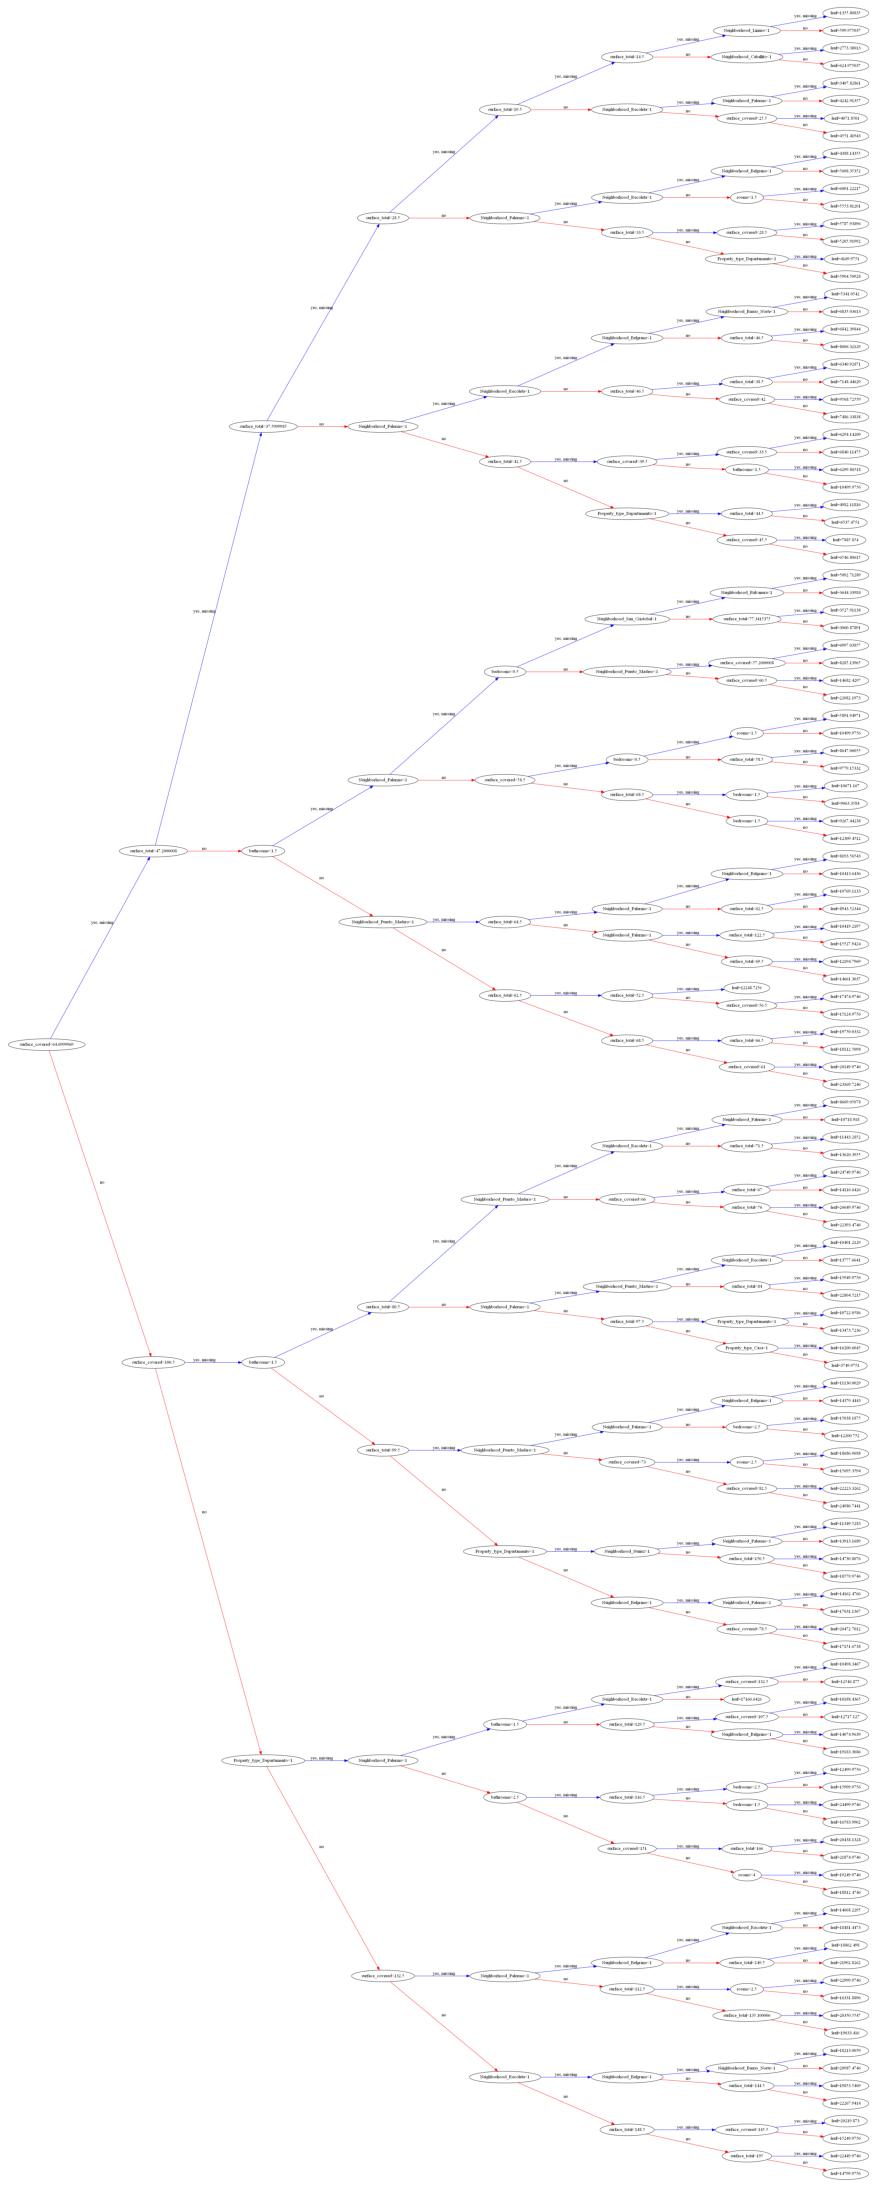

In [142]:
fig, ax = plt.subplots(figsize = (40, 40))
plot_tree(trees_xgb_l1, num_trees = 1, ax = ax, rankdir = 'LR')
plt.show()

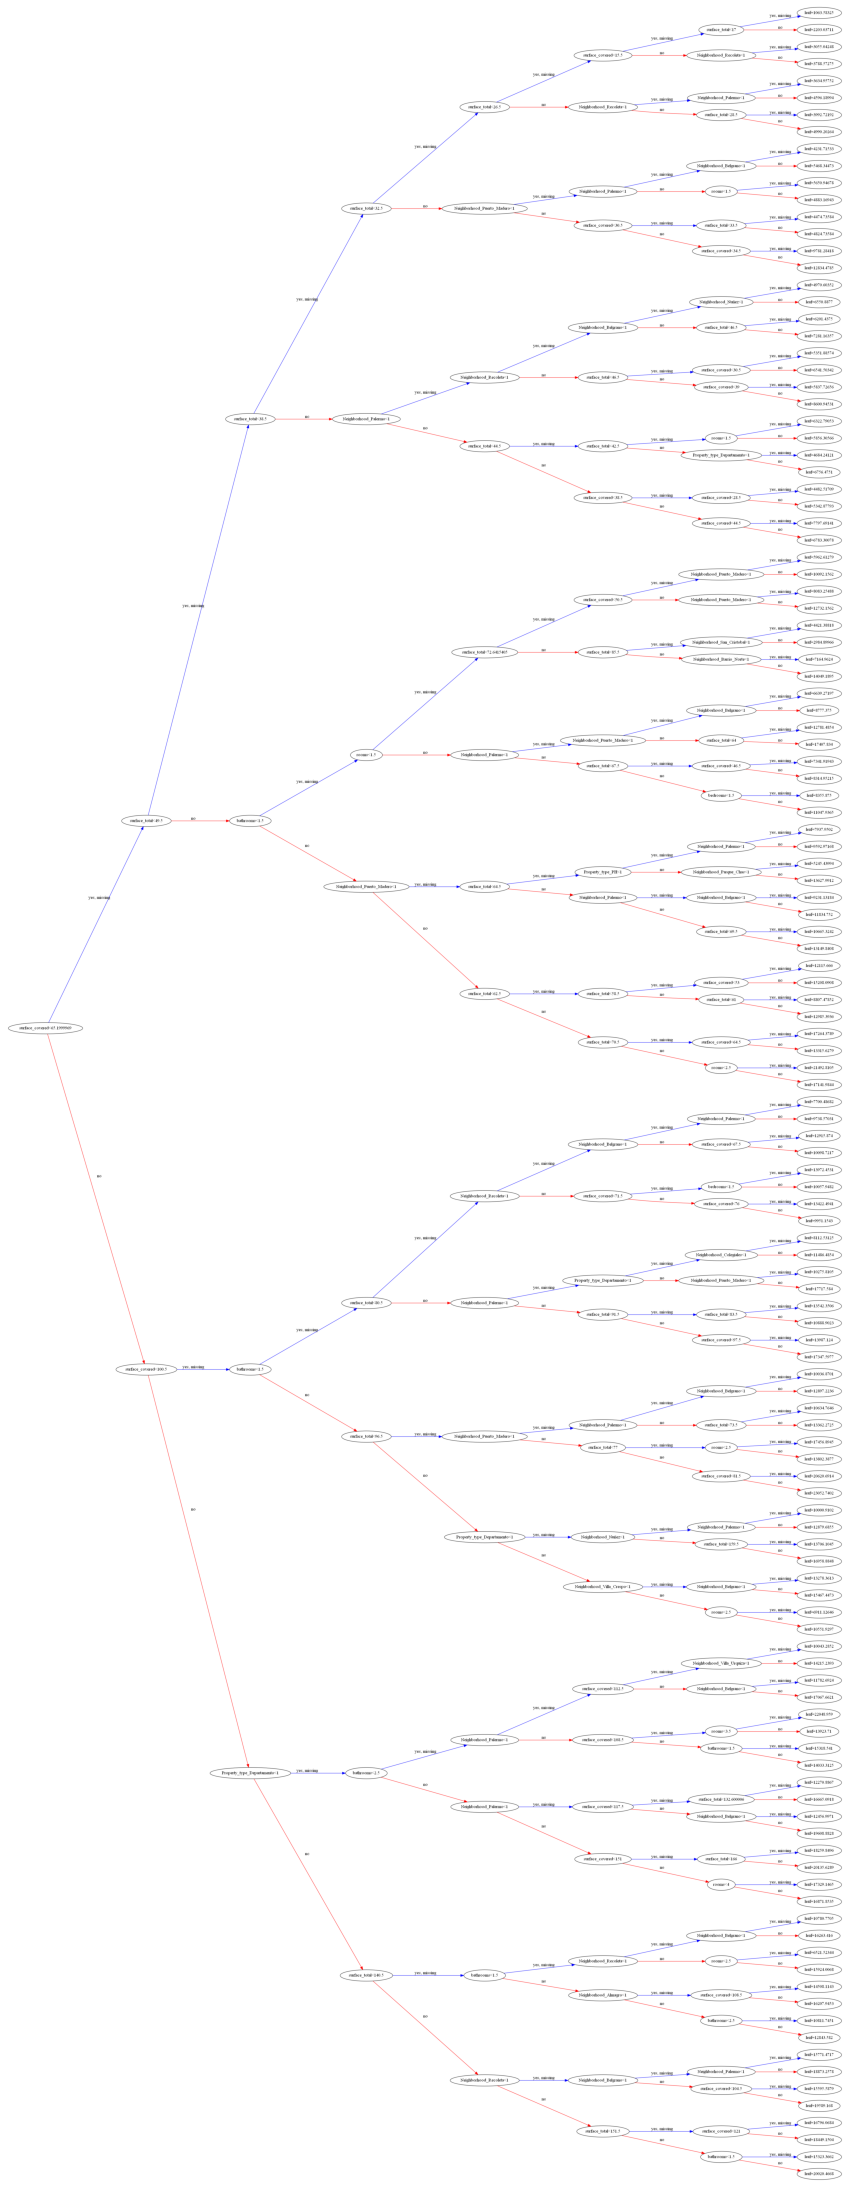

In [143]:
fig, ax = plt.subplots(figsize = (40, 40))
plot_tree(trees_xgb_l1, num_trees = 2, ax = ax, rankdir = 'LR')
plt.show()

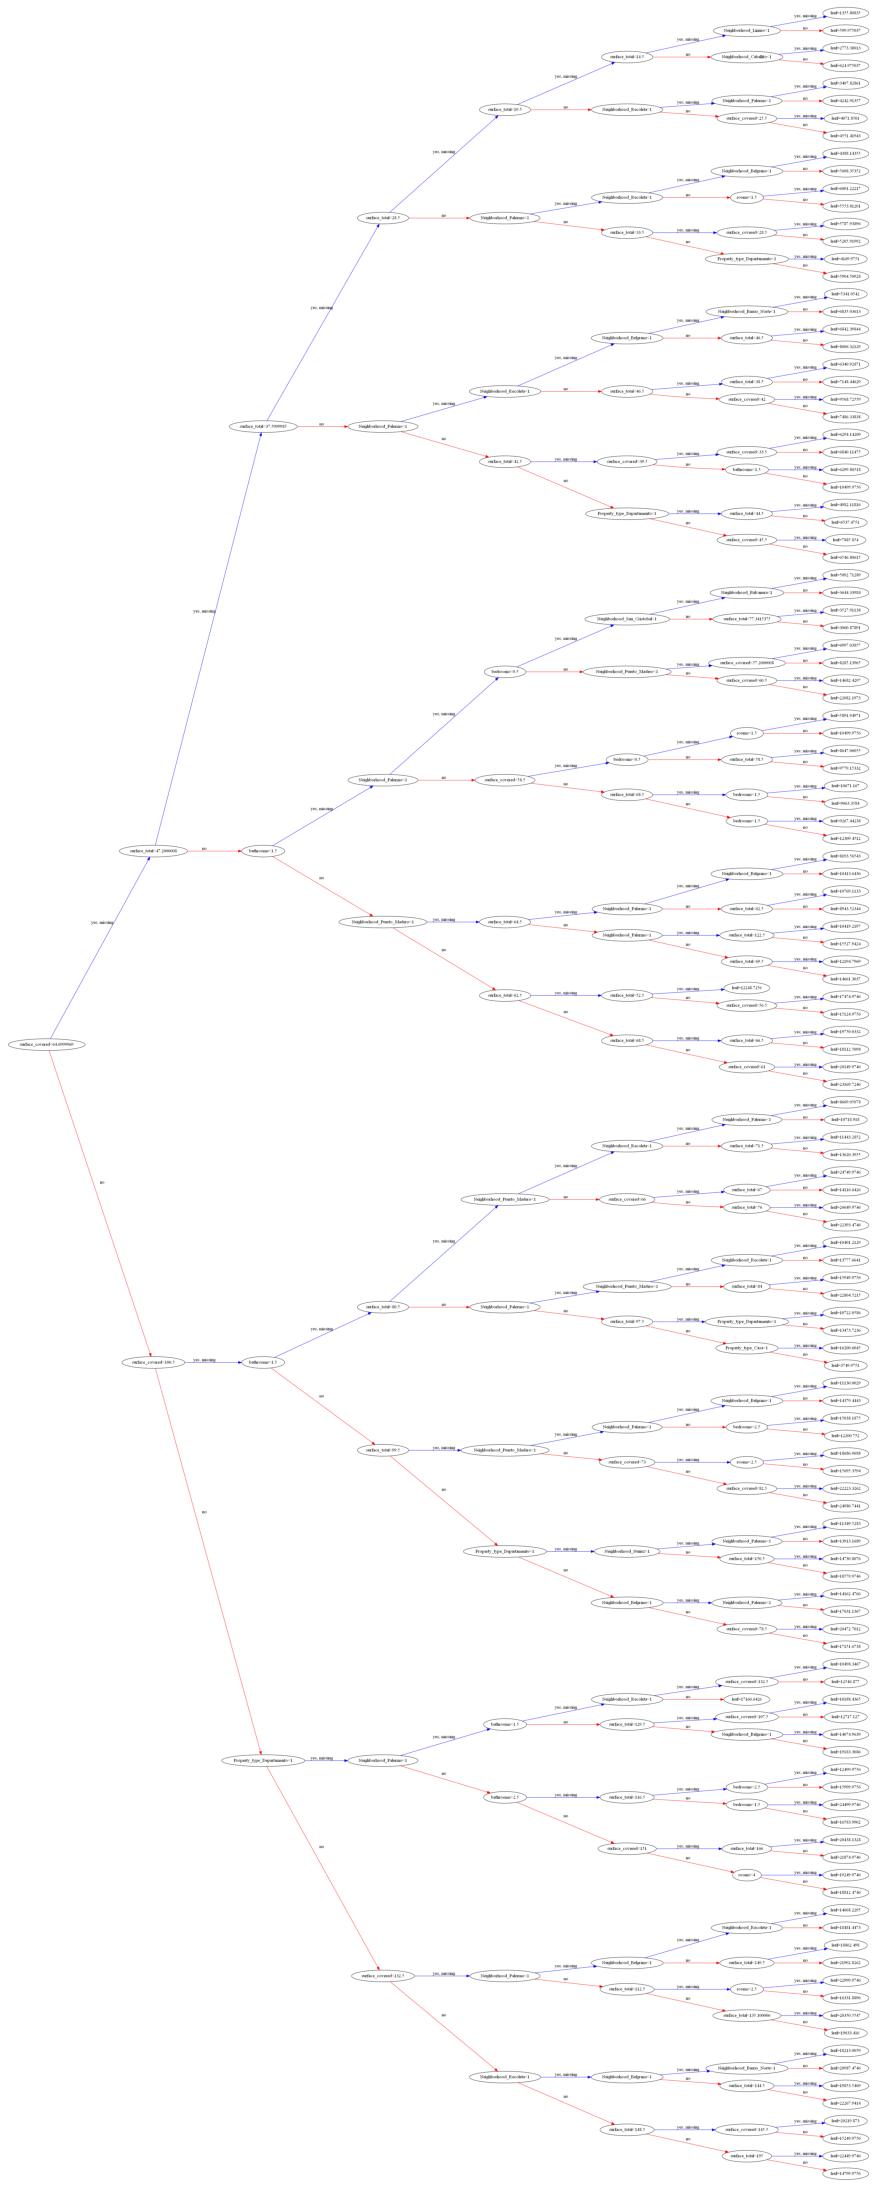

In [144]:
fig, ax = plt.subplots(figsize = (40, 40))
plot_tree(trees_xgb_l1, num_trees = 1, ax = ax, rankdir = 'LR')
plt.show()

### - Conclusiones

Al oprimizar hiperparámetros para el <b>XGBoost</b> la métrica sí mejoró (en un 10,22%). Sin embargo, cuando menos en términos de esta, no hubo diferencias usando `lambda` o `alpha`.

### - Comparación de desempeño entre los modelos estudiados

Definitivamente, el modelo que mejor optimiza la métrica es el <b>XGBoost</b> optimizando sus hiperparámetros mediante <b>RandomizedSearchCV</b>, con ganancias en términos de la métrica superirores al 12,9% respecto a cualquiera de los modelos de Regresión Lineal aquí estudiados.

Dado que el modelo `model_xgb_gs_l2` tiene una métrica ligerísimamente mejor a `model_xgb__gs_l1` y que parecen ser computacionalmente igual de costosos, se considera como el mejor de estos al primero.

`model_xgb_gs_l2` respecto a `model_xgb` arroja una ganancia respecto a la métrica de 13,33% aunque computacionalmente fue muchísimo más costoso que este último. Sin embargo, dada la mejora significativa en la métrica se considera que vale la pena utilizarlo.

En los diagramas de dispersión queda también patente lo arriba mencionado. Veamos los correspondientes para el modelo seleccionado en el proyecto anterior, para este modelo con los datos preprocesados adecuadamente y para los modelos seleccionados de Regresión Lineal y de `XGboost`.

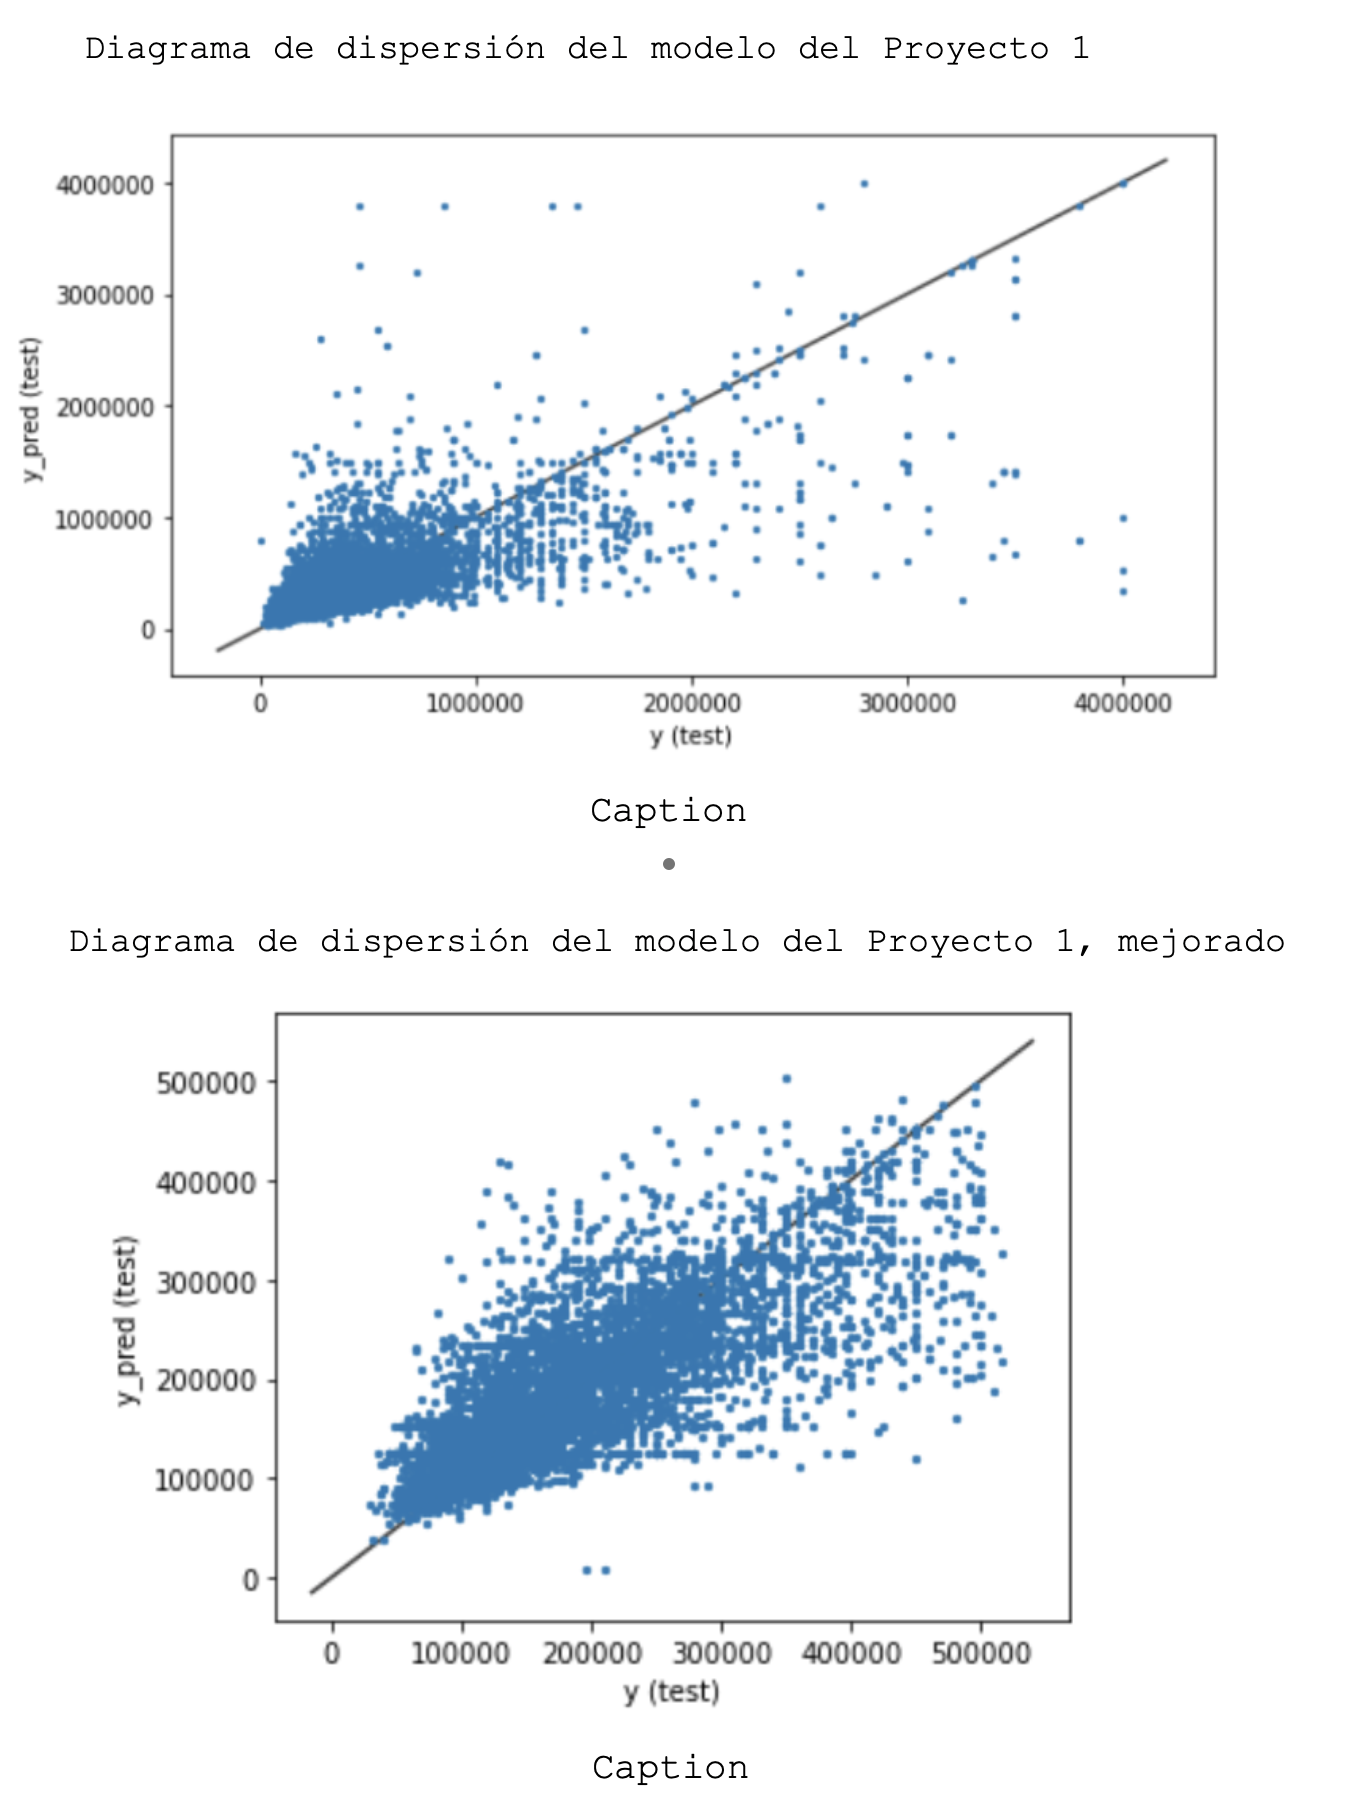

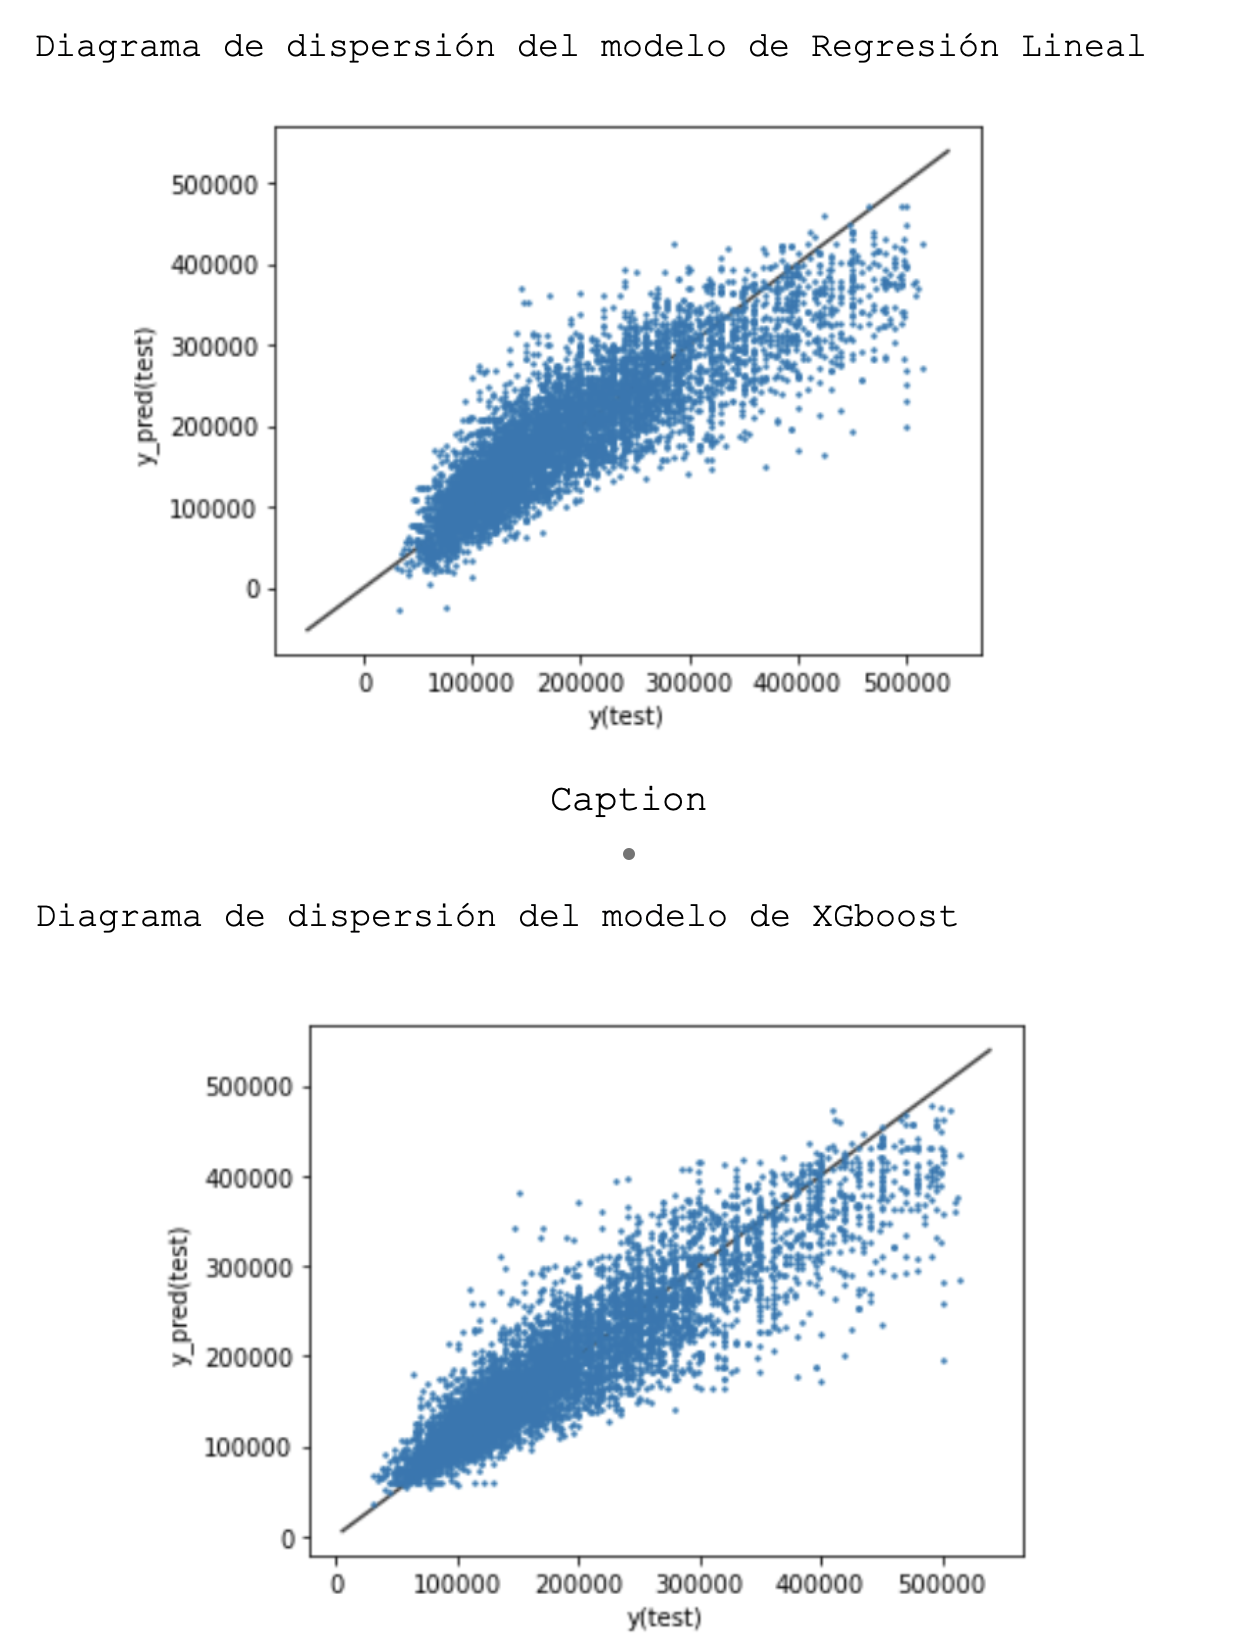

## Parte C - Interpretación de modelos.

### - Importancia de variables

En todos los modelos aquí estudiados, este análisis se hizo antes de evaluar cada uno de ellos. En resumen, esto es lo que se obtuvo:

- En la `Regresión Lineal` con atributos polinomiales y valores por defecto así como en las regularizaciónes `Ridge` y `Lasso` con sus valores por defecto las variables que más pesaron en el modelo fueron los barrios <i><b>Puerto Madero</i></b>, <i><b>Villa Soldati</i></b> y <i><b>Las Cañitas</i></b>.
- En la `Regresión Lineal` con sus hiperparámetros optimizados las variables que más peso tuvieron en el modelo fueron <i><b>rooms</i></b>, <i><b>rooms_bathrooms</i></b> y <i><b>rooms_bathrooms^2</i></b>.
- En las regularizaciones `Ridge` y `Lasso` con sus hiperparámetros optimizados las variables con mayor peso para ambos modelos fueron, nuevamente, los barrios <i><b>Puerto Madero</i></b>, <i><b>Villa Soldati</i></b> y <i><b>Las Cañitas</i></b> para la primera mientras que para `Lasso` este último barrio cambió por <i><b>Villa Lugano</b></i>.
- En el `XGboost` con sus valores por defecto así como en los dos con sus hiperparámetros optimizados, las variables que más peso tuvieron en el modelo fueron <i><b>surface_total</b></i>, <i><b>surface_covered</b></i> y <i><b>rooms</b></i>.

Respecto a los árboles individuales vistos de los modelos de `XGboost`, los atributos que consideraron más importantes fueron <i><b>surface_total</b></i>, <i><b>surface_covered</b></i> y <i><b>rooms</b></i>.

Estos árboles se diferencian entre sí tanto en algunas de las variables que aparecen en cada profundidad de ellos así como en la ganancia de sus hojas. Esto se debe a que en este tipo de ensambles, cada árbol aprende del anterior por lo que sus parámetros son más precisos.

De entre lo esperado al trabajar este proyecto fue el que el modelo del proyecto anterior mejoró significativamente al preprocesar los datos de una manera más óptima, que de entre los modelos estudiados los de `XGboost` tuvieran un mejor desempeño.

Dentro de lo inesperado, el que la métrica no varió fuertemente entre ninguno de los modelos (se esperaban mejoras más fuertes en las regularizaciones respecto a las regresiones y una diferencia mucho más considerable entre la métrica del mejor modelo respecto al peor) así como el que las variables de mayor impacto en la mayoría de las regresiones y regularizaciones fueran barrios y no variables numéricas (específicamente, se esperaba que en esos modelos también <i><b>surface_total</b></i> y <i><b>surface_covered</b></i> tuvieran el mayor peso).

Respecto a la distribución de los errores, en todos los modelos esta fue normal, como puede apreciarse en cada uno de los histogramas. De los diagramas de dispersión se desprende que la relación entre nuestra variable objetivo, <i><b>price</b></i>, y la precisión en la predicción de nuestros modelos es inversamente proporcional. Esto sugiere que una posible metodología para estudiar este <i>dataset</i> es dividirlo cuando menos en dos partes, tomando como parámetro para una primera división el punto a partir del cual las predicciones del modelo seleccionado, en nuestro caso `model_xgb_gs_l1`, comienzan a dispersarse más.